In [1]:
import torch
import numpy as np
from U_FNOB import *
from lploss import *
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO
import tensorflow as tf
from tensorflow.python.lib.io import file_io
from tqdm import tqdm
import torch.utils.data as data
import os
from io import StringIO
from google.cloud import storage
import imageio
import gc

2023-03-16 01:52:34.470883: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# Empty cache before starting
gc.collect()
torch.cuda.empty_cache()

In [3]:
# LOAD INPUT PARAMETER DATA
bucket_name = "us-digitaltwiner-pub-features"
storage_client = storage.Client()
bucket = storage_client.get_bucket(bucket_name)

blob = bucket.get_blob("srs_farea_ensemble_simulations_dataset/sampled_params_succ_status.csv")
params_string = blob.download_as_text()
params_string = StringIO(params_string)
sim_parameters = pd.read_csv(params_string, index_col=0)
sim_parameters = sim_parameters.rename({"@serial_number@": "sim_id","@sim_path@": "path", "@Perm@": "permeability","@Por@": "porosity", "@alpha@": "alpha","@sr@":"residual water content","@m@":"m", "@Rech_hist@": "recharge history","@Rech_mid@": "recharge mid-century", "@Rech_late@": "recharge late-century", "@seepage@": "seepage","@seepage_conc@":"seepage concentration","@cap_rate@":"cap rate",  "@successful@":"successful"}, axis=1)
sim_parameters.index = sim_parameters["sim_id"]
sim_parameters.drop("sim_id", axis=1, inplace=True)
sim_parameters['path'] = sim_parameters['path'].str.replace(r'/global/scratch/users/satyarth/Projects/ensemble_simulation_runs/', '')
sim_parameters = sim_parameters[sim_parameters["successful"]==True].drop("successful", axis=1)
# for recharge combination
order = ['path','permeability','porosity','alpha','residual water content','m','recharge history','seepage','seepage concentration','cap rate', 'recharge mid-century','recharge late-century']
sim_parameters = sim_parameters[order]

In [4]:
input_path = 'input_recurrent.npy'
output_path = 'output_recurrent.npy'
meta_path = 'meta_data_recurrent.txt'

data_path = 'us-digitaltwiner-pub-features/srs_farea_ensemble_simulations_dataset/'
f_input = BytesIO(file_io.read_file_to_string("gs://" + data_path + input_path, binary_mode=True)) 
f_output = BytesIO(file_io.read_file_to_string("gs://" + data_path + output_path, binary_mode=True))
input_array = torch.from_numpy(np.load(f_input)) 
output_array = torch.from_numpy(np.load(f_output))

# size of array from the input
ns, nz, nx, nt, nc = input_array.shape
no = output_array.shape[-1]
nc = nc - 3

# calculate the statistics of output_array
output_array_mean = np.mean(output_array.numpy(),axis = 0)
output_array_std = np.std(output_array.numpy(),axis = 0)
output_array_max = np.max(output_array.numpy(),axis = 0)
output_array_min = np.min(output_array.numpy(),axis = 0)

# meta_data
f = (BytesIO(file_io.read_file_to_string("gs://" + data_path + meta_path, binary_mode=True)))
lines = f.readlines()
input_names = str(lines[0]).split('\'')[1].split('\\n')[0].split(', ')
time_steps = np.array(str(lines[1]).split('\'')[1].split('\\n')[0].split(', '),dtype = 'float64')
time_steps = np.array(time_steps, dtype = 'int64')
input_min = np.array(str(lines[2]).split('\'')[1].split('\\n')[0].split(', '),dtype = 'float64')
input_max = np.array(str(lines[3]).split('\'')[1].split('\\n')[0].split(', '),dtype = 'float64')
output_names = str(lines[4]).split('\'')[1].split('\\n')[0].split(', ')

tritium_MCL = 7e-13
# Custom min and max values per variable for rescaling
rescale_factors = {
    0 : {
        'min': np.nanmin(output_array[:,:,:,:,0]),
        'max': np.nanmax(output_array[:,:,:,:,0])/2
    },
    1 : {
        'min': np.nanmin(output_array[:,:,:,:,1]),
        'max': np.nanmax(output_array[:,:,:,:,1])/5
    },
    2 : {
        'min': np.nanmin(output_array[:,:,:,:,2]),
        'max': np.nanmax(output_array[:,:,:,:,2])
    },
    3 : {
        'min': np.nanmin(output_array[:,:,:,:,3]),
        'max': np.nanmax(output_array[:,:,:,:,3])
    },
    4 : {
        'min': np.nanmin(output_array[:,:,:,:,4]),
        'max': np.nanmax(output_array[:,:,:,:,4])
    },
    5 : {
        'min': tritium_MCL*0.2,
        'max': 9e-9
    },
    6 : {
        'min': np.nanmin(output_array[:,:,:,:,6]),
        'max': np.nanmax(output_array[:,:,:,:,6])
    }
}

# Rescale input
input_max_values = np.nanmax(input_array.reshape(-1,nc+3),axis = 0).reshape(1,1,1,1,-1)
input_array = input_array/input_max_values

# Input nan -> 0
input_array[np.isnan(input_array)] = 0

# Rescale output_array between 0 and 1.

scaled_output = output_array.detach().clone()

for i in range(no):
    scaled_output[:,:,:,:,i][scaled_output[:,:,:,:,i]<rescale_factors[i]['min']] = rescale_factors[i]['min']
    #if(i==5):
    scaled_output[:,:,:,:,i][scaled_output[:,:,:,:,i]>rescale_factors[i]['max']] = rescale_factors[i]['max']
    scaled_output[:,:,:,:,i] = (scaled_output[:,:,:,:,i] - rescale_factors[i]['min'])/(rescale_factors[i]['max']-rescale_factors[i]['min'])

scaled_output[np.isnan(scaled_output)] = 0

# Current training
selected_idx = np.array([0,1,2,5])
scaled_output_4 = scaled_output[:,:,:,:,selected_idx]
output_names_4 = list(np.array(output_names)[selected_idx])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755953518/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1391.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:82: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755953518/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1391.)


In [5]:
# LOAD MODEL
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load('final_models/UFNOB_model_best_combination_150epochs')
model.to(device)

UFNO3d(
  (conv1): SimpleBlock3d(
    (fc0): Linear(in_features=11, out_features=36, bias=True)
    (conv0): SpectralConv3d()
    (conv1): SpectralConv3d()
    (conv2): SpectralConv3d()
    (conv3): SpectralConv3d()
    (conv4): SpectralConv3d()
    (conv5): SpectralConv3d()
    (w0): Conv1d(36, 36, kernel_size=(1,), stride=(1,))
    (w1): Conv1d(36, 36, kernel_size=(1,), stride=(1,))
    (w2): Conv1d(36, 36, kernel_size=(1,), stride=(1,))
    (w3): Conv1d(36, 36, kernel_size=(1,), stride=(1,))
    (w4): Conv1d(36, 36, kernel_size=(1,), stride=(1,))
    (w5): Conv1d(36, 36, kernel_size=(1,), stride=(1,))
    (unet3): U_net(
      (conv1): Sequential(
        (0): Conv3d(36, 36, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Dropout(p=0, inplace=False)
      )
      (conv2): Sequential(
        (0): Co

In [6]:
batch_size = 4
torch_dataset = torch.utils.data.TensorDataset(input_array, scaled_output_4)
dataset_sizes = [np.int(np.int(ns*0.8)/batch_size)*batch_size, np.int((ns-np.int(np.int(ns*0.8)/batch_size)*batch_size)/2),np.int((ns-np.int(np.int(ns*0.8)/batch_size)*batch_size)/2)]
train_data, val_data, test_data = data.random_split(torch_dataset, dataset_sizes ,generator=torch.Generator().manual_seed(0))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

params_train = sim_parameters.iloc[train_data.indices]
params_val = sim_parameters.iloc[val_data.indices]
params_test = sim_parameters.iloc[test_data.indices]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
output_names_4 = ['Darcy velocity (x)', 'Darcy velocity (z)', 'Hydraulic head', 'Tritium concentration']
output_units_4 = [ 'm/s', 'm/s', 'm','mol/L']

In [8]:
# PERFORM INFERENCE
data_type = 'Test'

if(data_type=='Train'):
    data_loader = train_loader
    samples = dataset_sizes[0]
    input_params = params_train
    bs = 4
if(data_type=='Val'):
    data_loader = val_loader
    samples = dataset_sizes[1]
    input_params = params_val
    bs = 4
if(data_type=='Test'):
    data_loader = test_loader
    samples = dataset_sizes[2]
    input_params = params_test
    bs = 1

y_true_all = np.zeros((samples,nz,nx,nt,4))
y_pred_all = np.zeros((samples,nz,nx,nt,4))
i = 0
for x, y in data_loader:
    x, y = x.to(device), y.to(device)
    y_pred = model(x.float())
    y_true_all[i:(i+bs),:] = y.cpu().detach().numpy()
    y_pred_all[i:(i+bs),:] = y_pred.cpu().detach().numpy()
    i = i+bs

In [9]:
mask_time_series = (input_array[0,:,:,0:1,0]!=0).reshape(1, nz, nx, 1).repeat(dataset_sizes[2],1,1,4).cpu().detach().numpy()

In [10]:
# Calculate the the mre through time 
mse_test_time_series = np.zeros(nt)
for t in range(nt):
    mse_test_time_series[t] = (np.linalg.norm(y_true_all[:,:,:,t,:][mask_time_series]-y_pred_all[:,:,:,t,:][mask_time_series], 2)/np.linalg.norm(y_true_all[:,:,:,t,:][mask_time_series],2))

In [11]:
np.save('mse_test_time_series_3D.npy', mse_test_time_series)

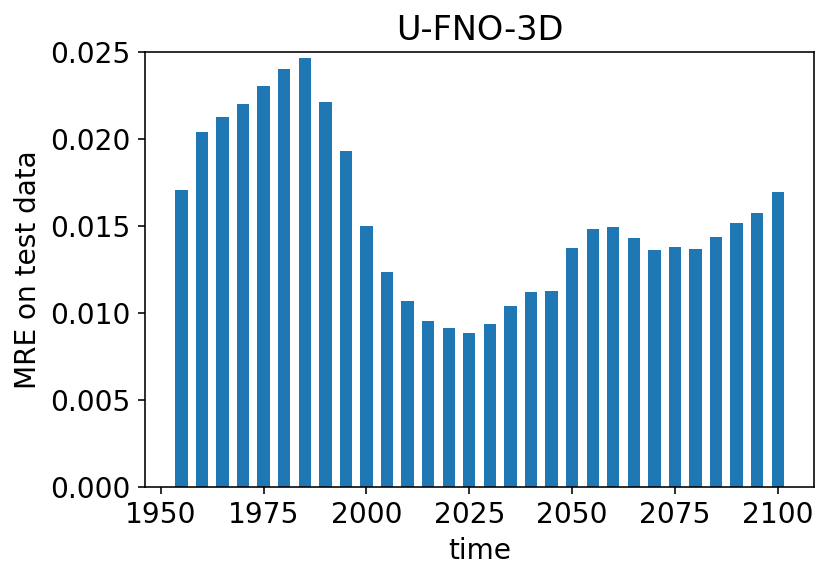

In [146]:
plt.bar(time_steps,mse_test_time_series,width = 3,color = 'C0')
plt.xlabel('time')
plt.ylabel('MRE on test data')
plt.ylim(0,0.25
plt.title('U-FNO-3D')
plt.savefig('Figures/MRE_UFNO_3D_time_series.png', format='png',dpi = 400,bbox_inches = "tight")

In [9]:
# REVERSE RESCALE
selected_idx = np.array([0,1,2,5])
for i in range(len(selected_idx)):
    if(i==5):
        i=3
    y_true_all[:,:,:,:,i] = y_true_all[:,:,:,:,i] * (rescale_factors[selected_idx[i]]['max']-rescale_factors[selected_idx[i]]['min']) + rescale_factors[selected_idx[i]]['min']
    y_pred_all[:,:,:,:,i] = y_pred_all[:,:,:,:,i] * (rescale_factors[selected_idx[i]]['max']-rescale_factors[selected_idx[i]]['min']) + rescale_factors[selected_idx[i]]['min']

diff_all = y_true_all-y_pred_all

In [16]:
vis_mask = ((x[0,:,:,0,0]!=0).cpu().detach().numpy())*1.0
vis_mask[vis_mask==0] = np.nan

mask = (input_array[0,:,:,0:1,0]!=0).reshape(nz, nx, 1).repeat(1,1,nt).cpu().detach().numpy()

In [11]:
def visualize_sample_at_time_t(sample_num, output_var, time, var_min=None, var_max=None, save=False, path='', diff_min=None, diff_max=None, show_param=False, param_name= ""):
    fig, ax = plt.subplots(1,3, figsize=(20,5), dpi=200)
    font_size = 15
    aspect = 6
    
    if(var_min==None):
        var_min = np.nanmin(y_true_all[sample_num,:,:,:,output_var]*mask)
    if(var_max==None):
        var_max = np.nanmax(y_true_all[sample_num,:,:,:,output_var]*mask)
    if(diff_min==None):
        diff_min = np.nanmin(diff_all[sample_num,:,:,:,output_var]*mask)
    if(diff_max==None):
        diff_max = np.nanmax(diff_all[sample_num,:,:,:,output_var]*mask)

    left = ax[0].imshow((y_true_all[sample_num, :,:,time, output_var]*vis_mask).reshape(nz,nx), aspect=aspect, origin ='lower', vmin=var_min, vmax=var_max)
    middle = ax[1].imshow((y_pred_all[sample_num, :,:,time, output_var]*vis_mask).reshape(nz,nx), aspect=aspect, origin ='lower',vmin=var_min, vmax=var_max)
    right = ax[2].imshow((diff_all[sample_num, :,:,time, output_var]*vis_mask).reshape(nz,nx), aspect=aspect, origin ='lower', cmap = 'RdBu_r', vmin=diff_min, vmax=diff_max)
    
    # TEXT BOX SETTINGS
    if(show_param):
        value = input_params.iloc[sample_num][param_name]
        textstr = "$\\bf{"+param_name.replace(' ', '\ ').capitalize()+"}$" + f":\n {value:.4E}"
        props = dict(boxstyle='round', facecolor='whitesmoke', alpha=0.5)
        ax[0].text(0.01, 1.2, textstr, transform=ax[0].transAxes, fontsize=font_size-2,
                verticalalignment='top', bbox=props)


    # TITLES
    fig.suptitle("{}\n\nSample {} of {} simulations\n{}".format(time_steps[time],sample_num+1, samples, output_names_4[output_var]), fontsize=font_size, fontweight="bold", y=1)

    subtitles = ["Ground Truth", "Prediction", "Difference"]
    for i in range(ax.shape[0]):
        ax[i].axis('off')
        ax[i].set_title(subtitles[i], y=-0.1)

    # COLORBAR SETTINGS
    p0 = ax[0].get_position().get_points().flatten()
    p1 = ax[1].get_position().get_points().flatten()
    p2 = ax[2].get_position().get_points().flatten()
    ax_cbar = fig.add_axes([p0[0], 0.1, p1[2]-p0[0], 0.05])
    fig.colorbar(left, cax=ax_cbar, orientation='horizontal').set_label(label="{} ({})".format(output_names_4[output_var], output_units_4[output_var]), size=font_size, labelpad=15)
    ax_cbar1 = fig.add_axes([p2[0], 0.1, p2[2]-p2[0], 0.05])
    fig.colorbar(right, cax=ax_cbar1, orientation='horizontal').set_label(label="{} ({})".format(output_names_4[output_var], output_units_4[output_var]), size=font_size, labelpad=15)
    if(save):
        sub_folder = str("{}__Sample_{}_of_{}".format(output_names_4[output_var], sample_num, samples)).replace(" ", "")
        file_name = str("Time_{}__{}__Sample_{}_of_{}.png".format(time_steps[time], output_names_4[output_var], sample_num, samples)).replace(" ", "")
        if not os.path.exists(path+'/'+sub_folder):
            os.makedirs(path+'/'+sub_folder)
        plt.ioff()
        plt.savefig(path+'/'+sub_folder+'/'+file_name, bbox_inches='tight')

In [12]:
def create_sim_sequence(sample_num, output_var, path, var_min=None, var_max=None, save=False, diff_min=None, diff_max=None, show_param=False, param_name= ""):
    for t in tqdm(range(time_steps.shape[0])):
        visualize_sample_at_time_t(sample_num = sample_num, output_var = output_var, time = t, save=True, path=path,var_min=var_min, var_max=var_max, diff_min=diff_min, diff_max=diff_max, show_param=show_param, param_name= param_name)
def create_sim_animation(source_path, destination_path, fps=4):
    images = []
    for file_name in sorted(os.listdir(source_path)):
        if file_name.endswith('.png'):
            file_path = os.path.join(source_path, file_name)
            images.append(imageio.imread(file_path))
            
    imageio.mimsave(destination_path, images, fps=fps)

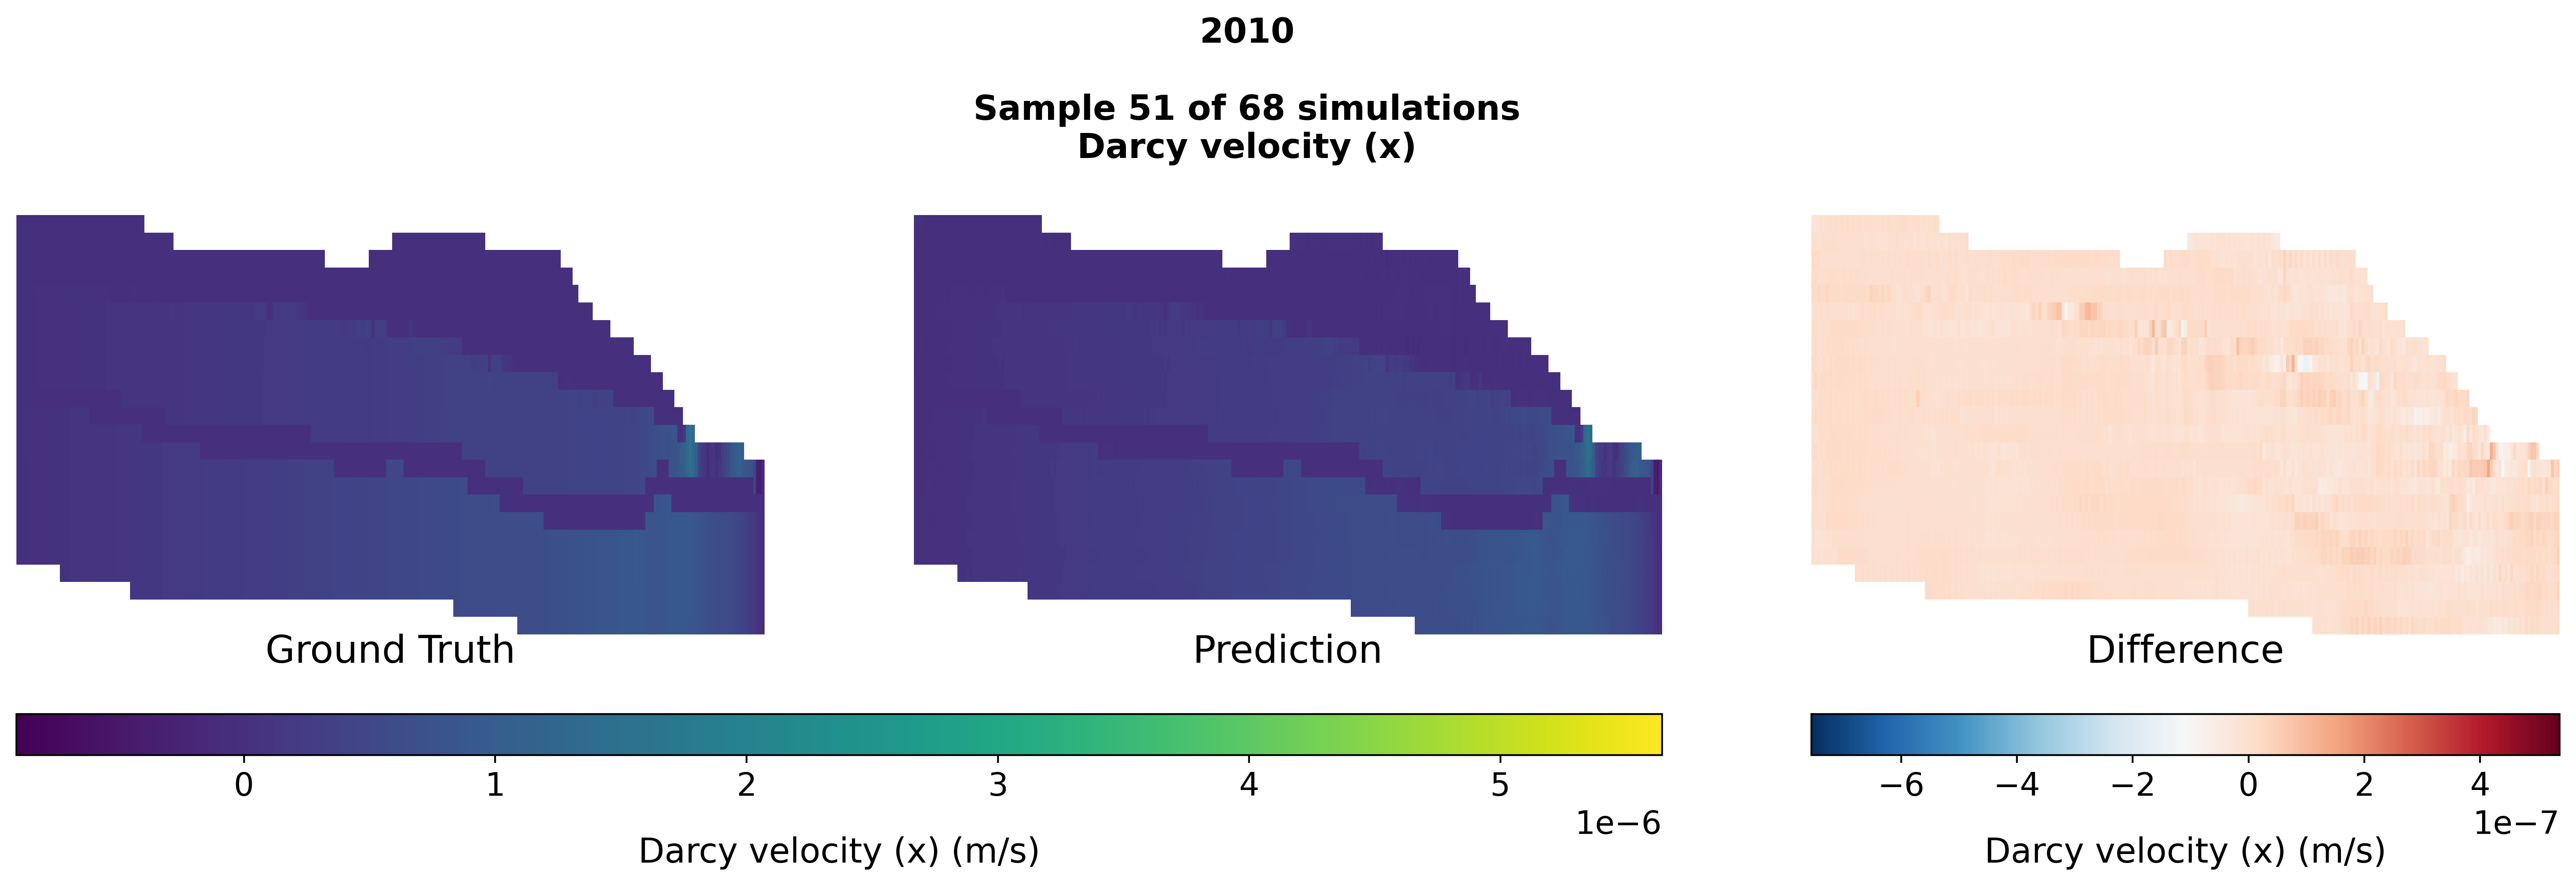

In [112]:
sample_num = 50
output_var = 0
visualize_sample_at_time_t(sample_num=sample_num, output_var = output_var,time =11, show_param=False, param_name='seepage concentration', diff_min=None, diff_max=None)

In [111]:
time_steps[[0,6,14]]

array([1955, 1985, 2025])

In [107]:
sample_num = 50#0,50

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.rcParams['font.size'] = 14

plt.figure(figsize = [10,10])

i = 1

var_max_list = [2e-6,1e-7,100,9e-9]
diff_list = [4e-7,8e-8,2,1.5e-9]

time  = 14 # 0,6,14
for output_var in range(4):
    #for time in [1,3,5]:
    ax = plt.subplot(4, 3, i)
    var_min = 0
    var_max = var_max_list[output_var]
    plt.imshow((y_true_all[sample_num, :,:,time, output_var]*vis_mask).reshape(nz,nx), aspect=4, origin ='lower', vmin=var_min, vmax=var_max)
    plt.axis('off')
    plt.colorbar(shrink = 0.7)
    #plt.title(output_names_4[output_var]+' ('+output_units_4[output_var]+')')
    i = i+1
    ax = plt.subplot(4, 3, i)
    plt.imshow((y_pred_all[sample_num, :,:,time, output_var]*vis_mask).reshape(nz,nx), aspect=4, origin ='lower',vmin=var_min, vmax=var_max)
    plt.axis('off')
    i = i+1
    #plt.colorbar(shrink = 0.7,orientation = 'horizontal')
    #plt.title(output_names_4[output_var]+output_units_4[output_var])
    
    diff_min = -diff_list[output_var]
    diff_max = diff_list[output_var]
    ax = plt.subplot(4, 3, i)
    plt.imshow((diff_all[sample_num, :,:,time, output_var]*vis_mask).reshape(nz,nx), aspect=4, origin ='lower', cmap = 'RdBu_r', vmin=diff_min, vmax=diff_max)
    plt.axis('off')
    i = i+1
    plt.colorbar(shrink = 0.7)
    #plt.title(output_names_4[output_var]+output_units_4[output_var])

In [14]:
parent_folder = 'Visualizations'
figures_folder = 'Figures'
animation_folder = 'Animations'

if not os.path.exists(parent_folder):
    os.makedirs(parent_folder)
if not os.path.exists(parent_folder+'/'+figures_folder):
    os.makedirs(parent_folder+'/'+figures_folder)
if not os.path.exists(parent_folder+'/'+animation_folder):
    os.makedirs(parent_folder+'/'+animation_folder)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:07<00:00,  1.49it/s]
/home/aurelien_meray_gmail_com/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  if __name__ == "__main__":


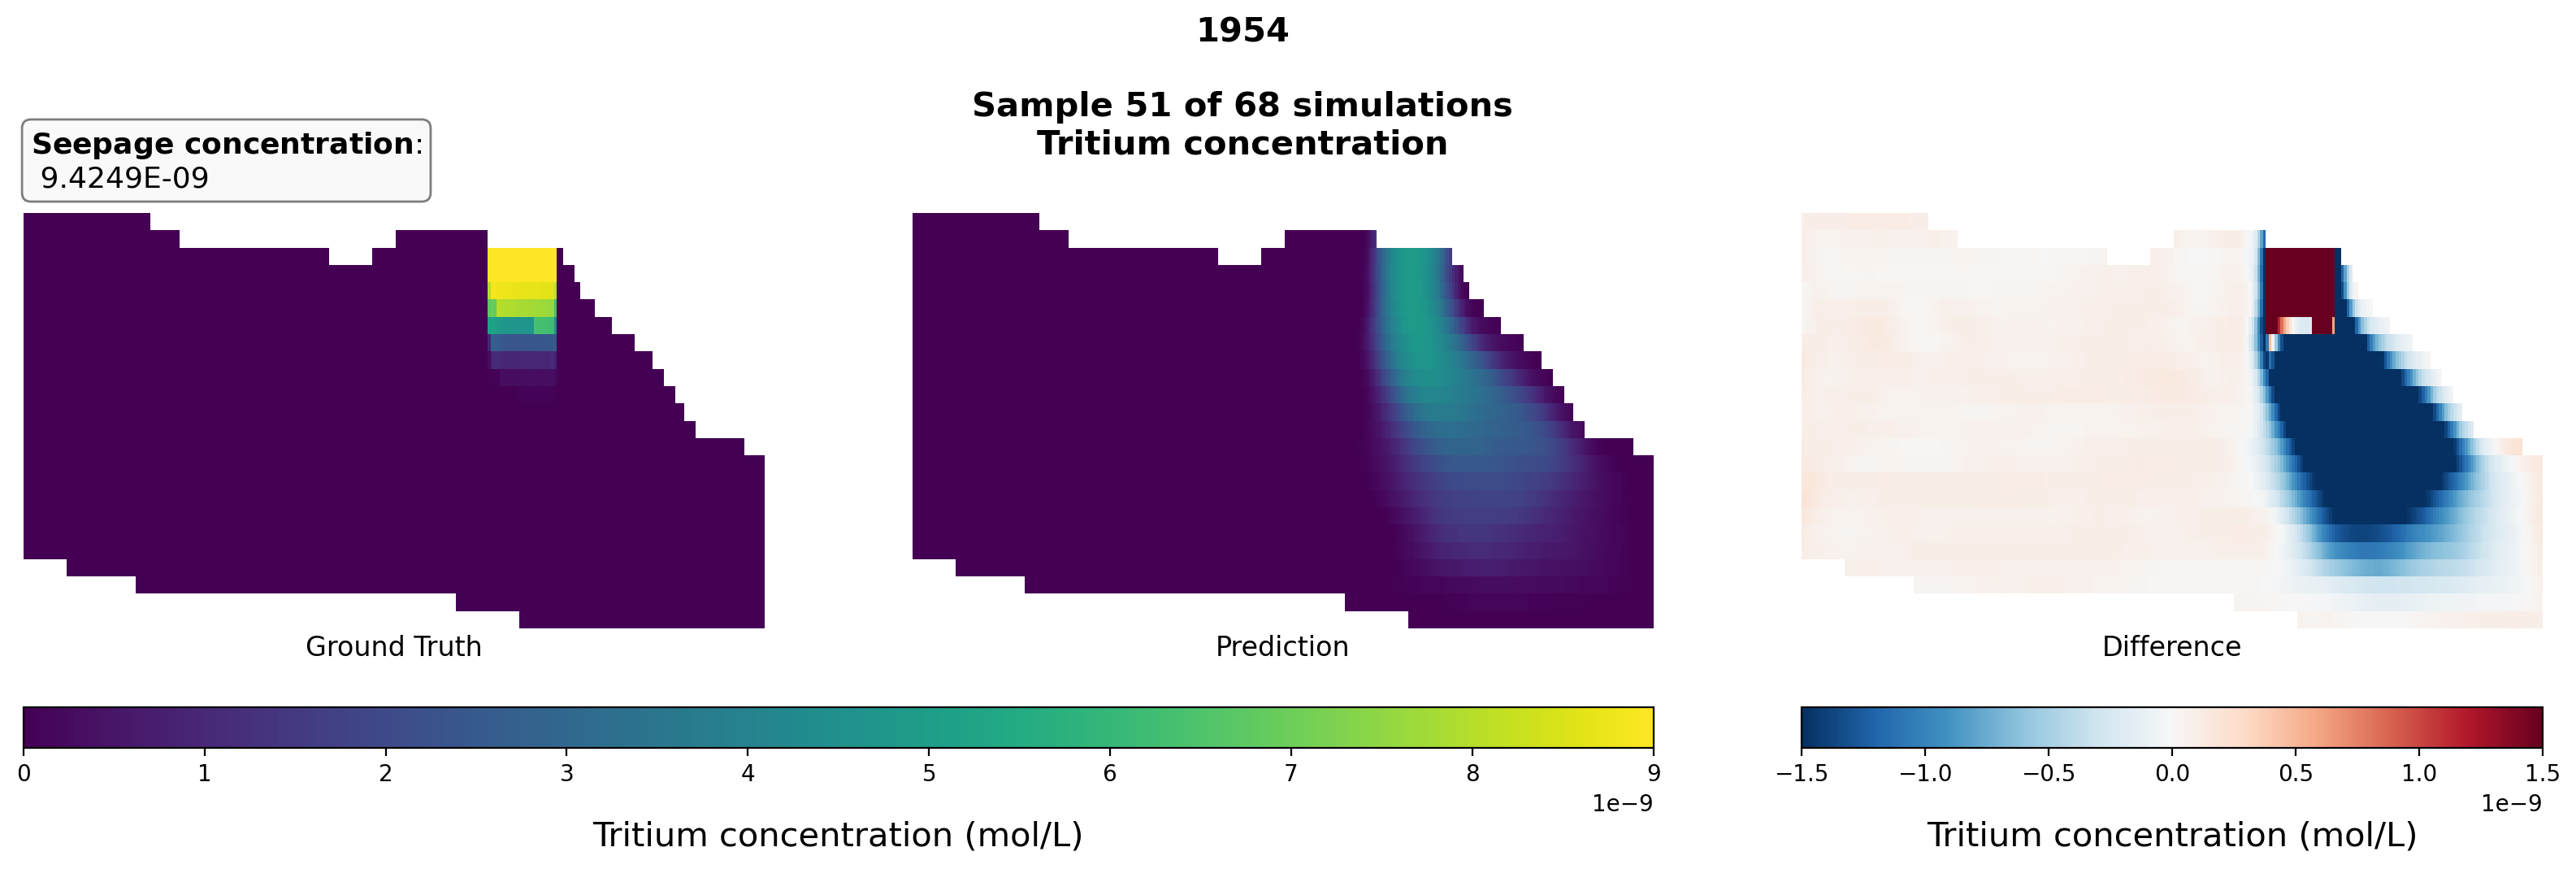

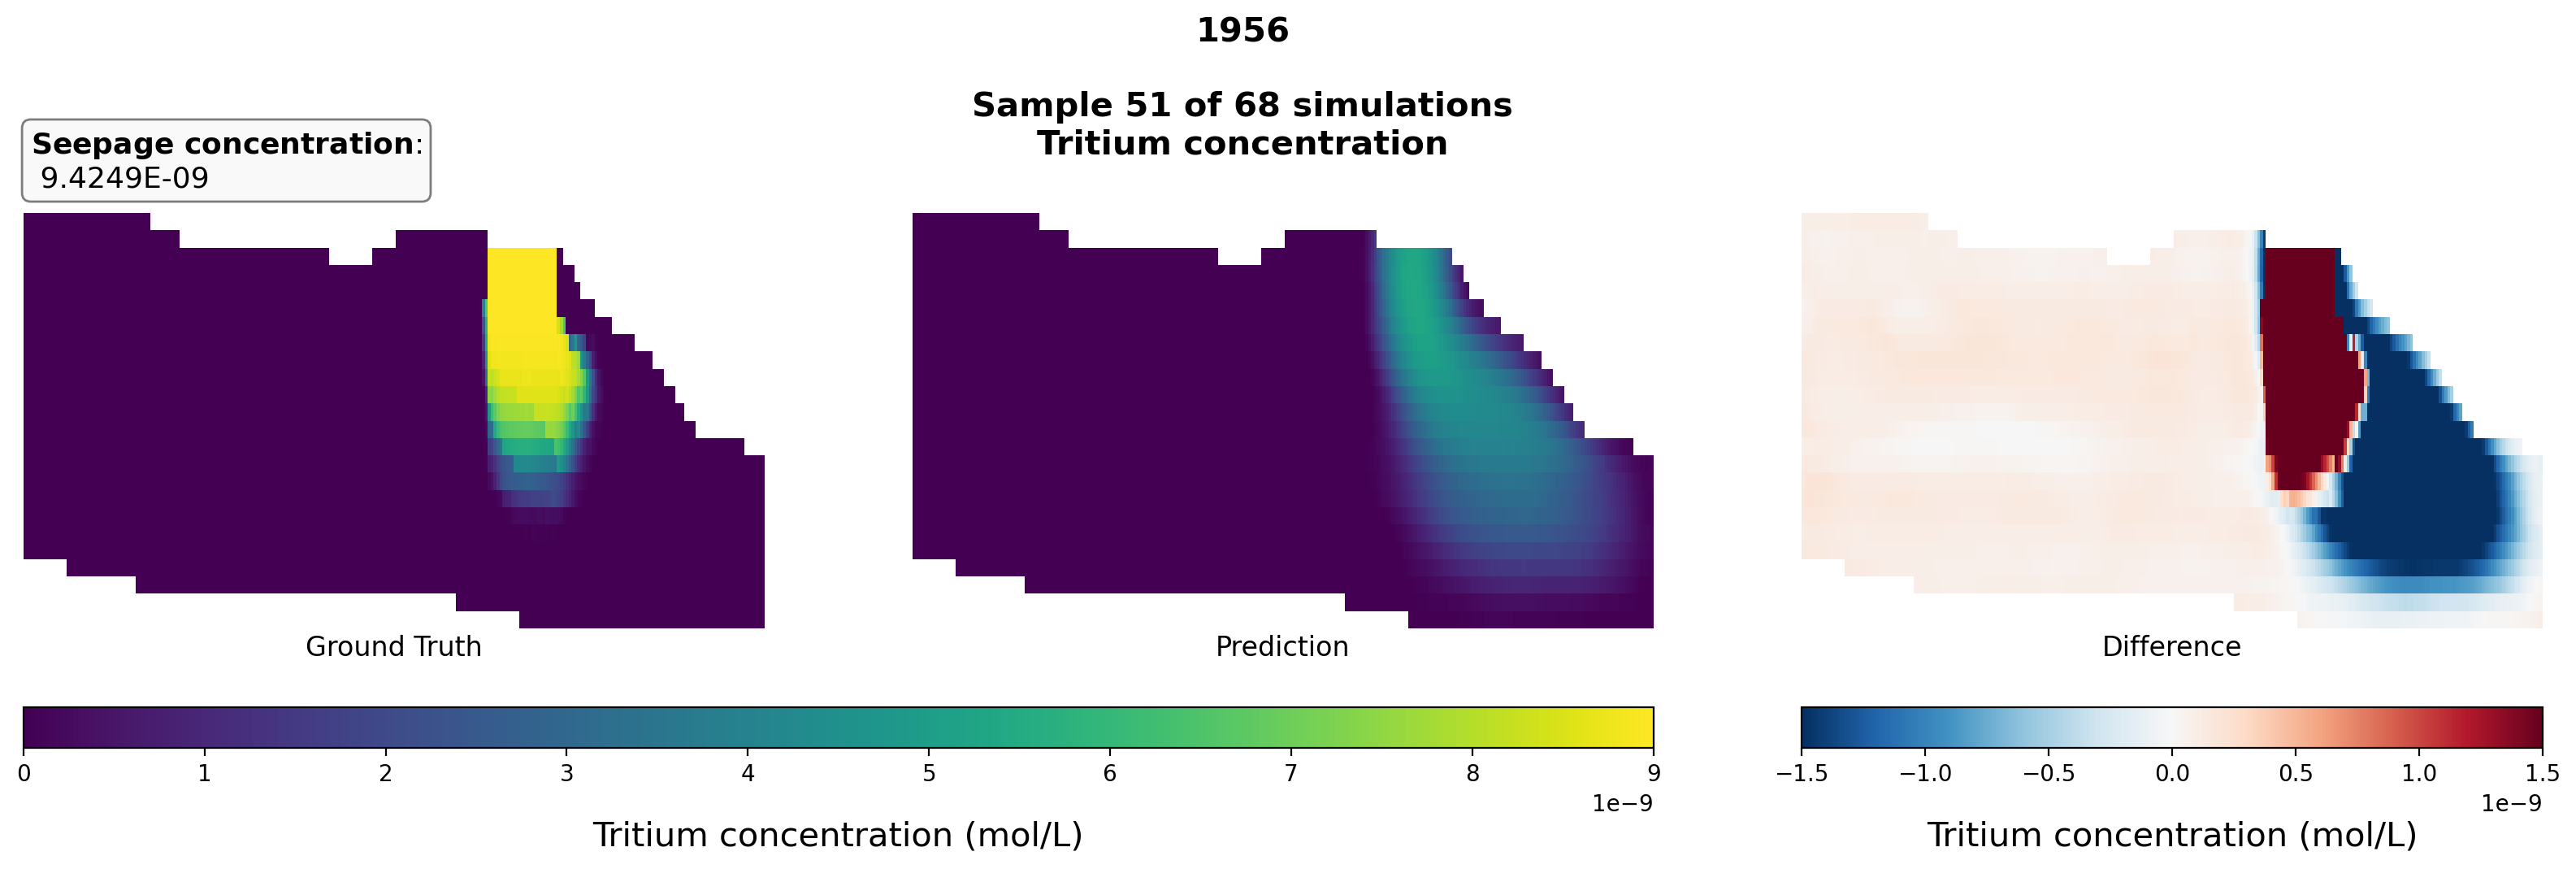

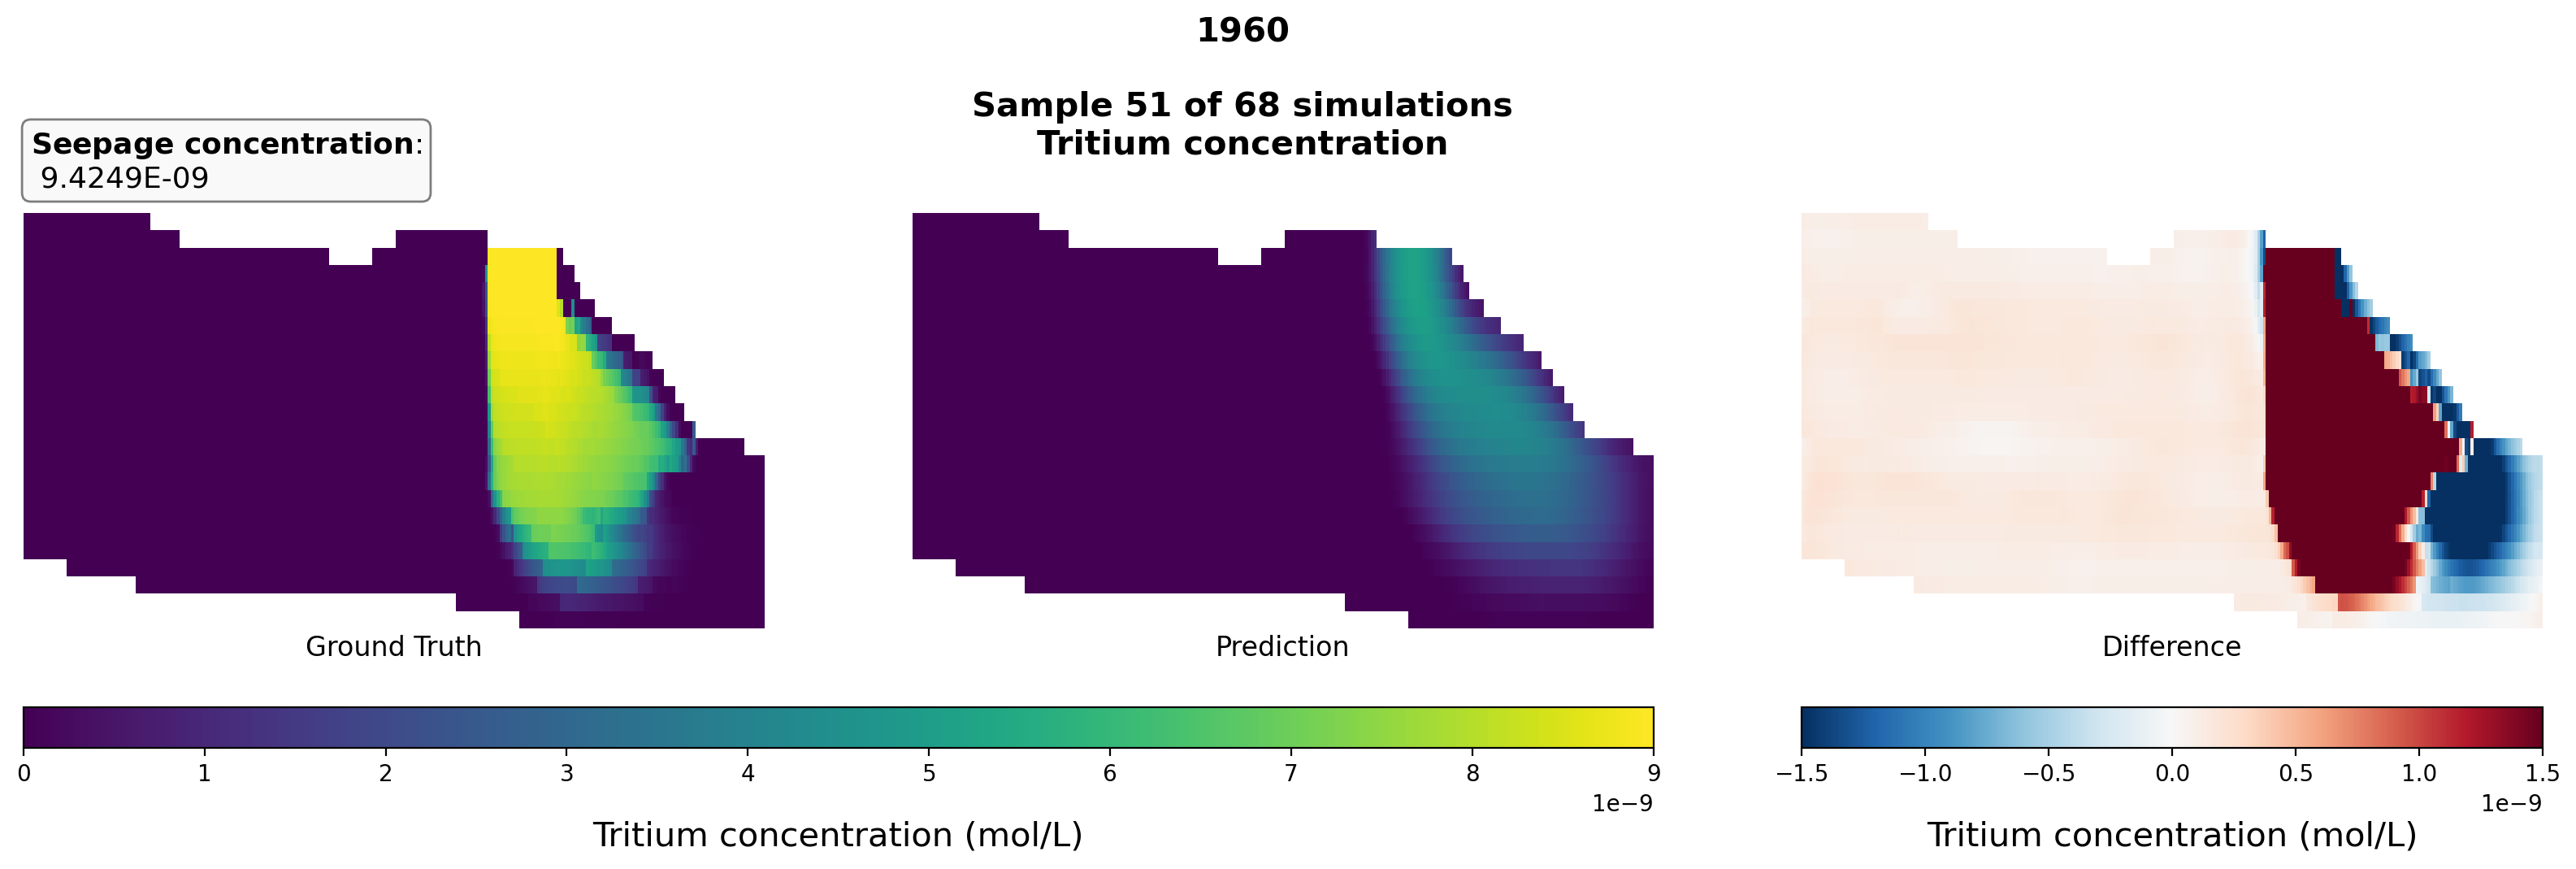

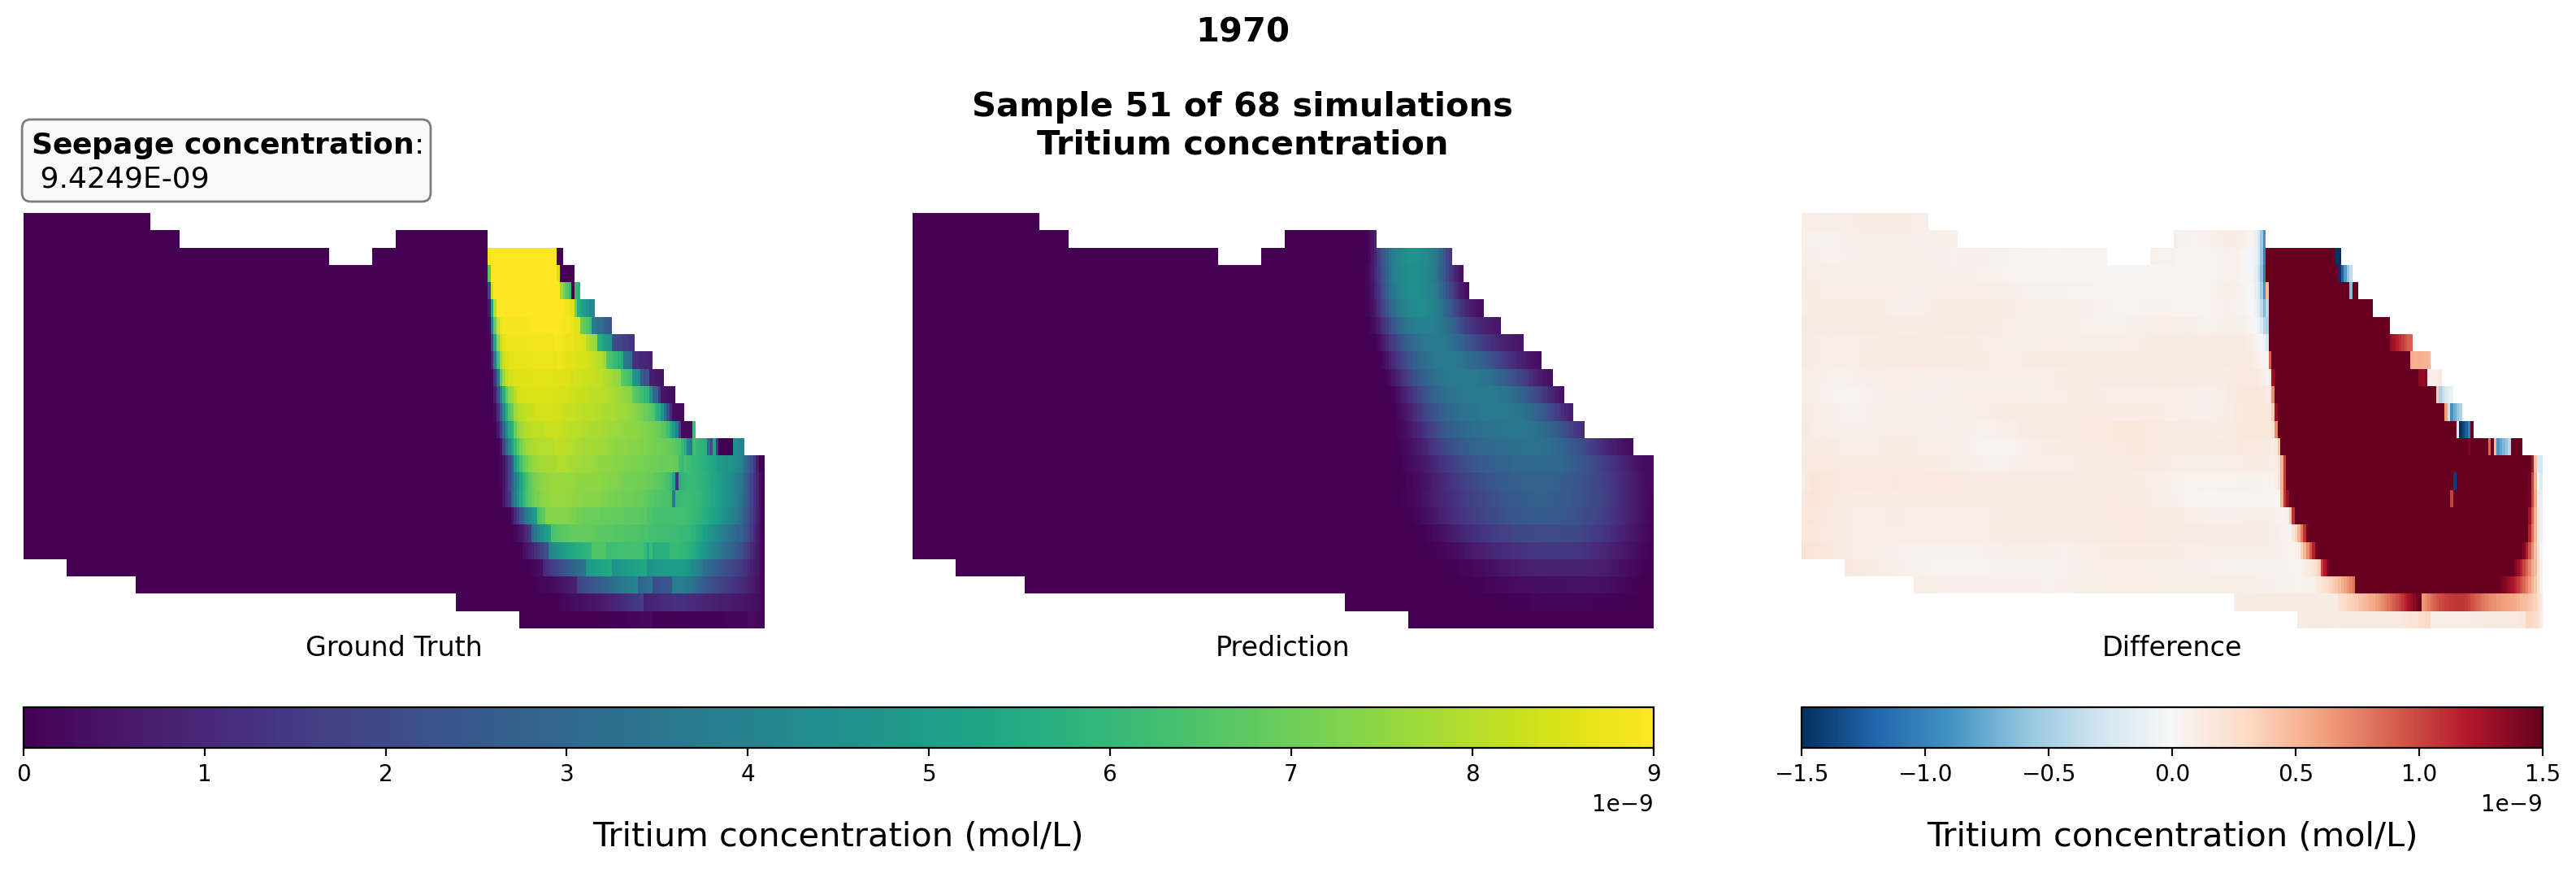

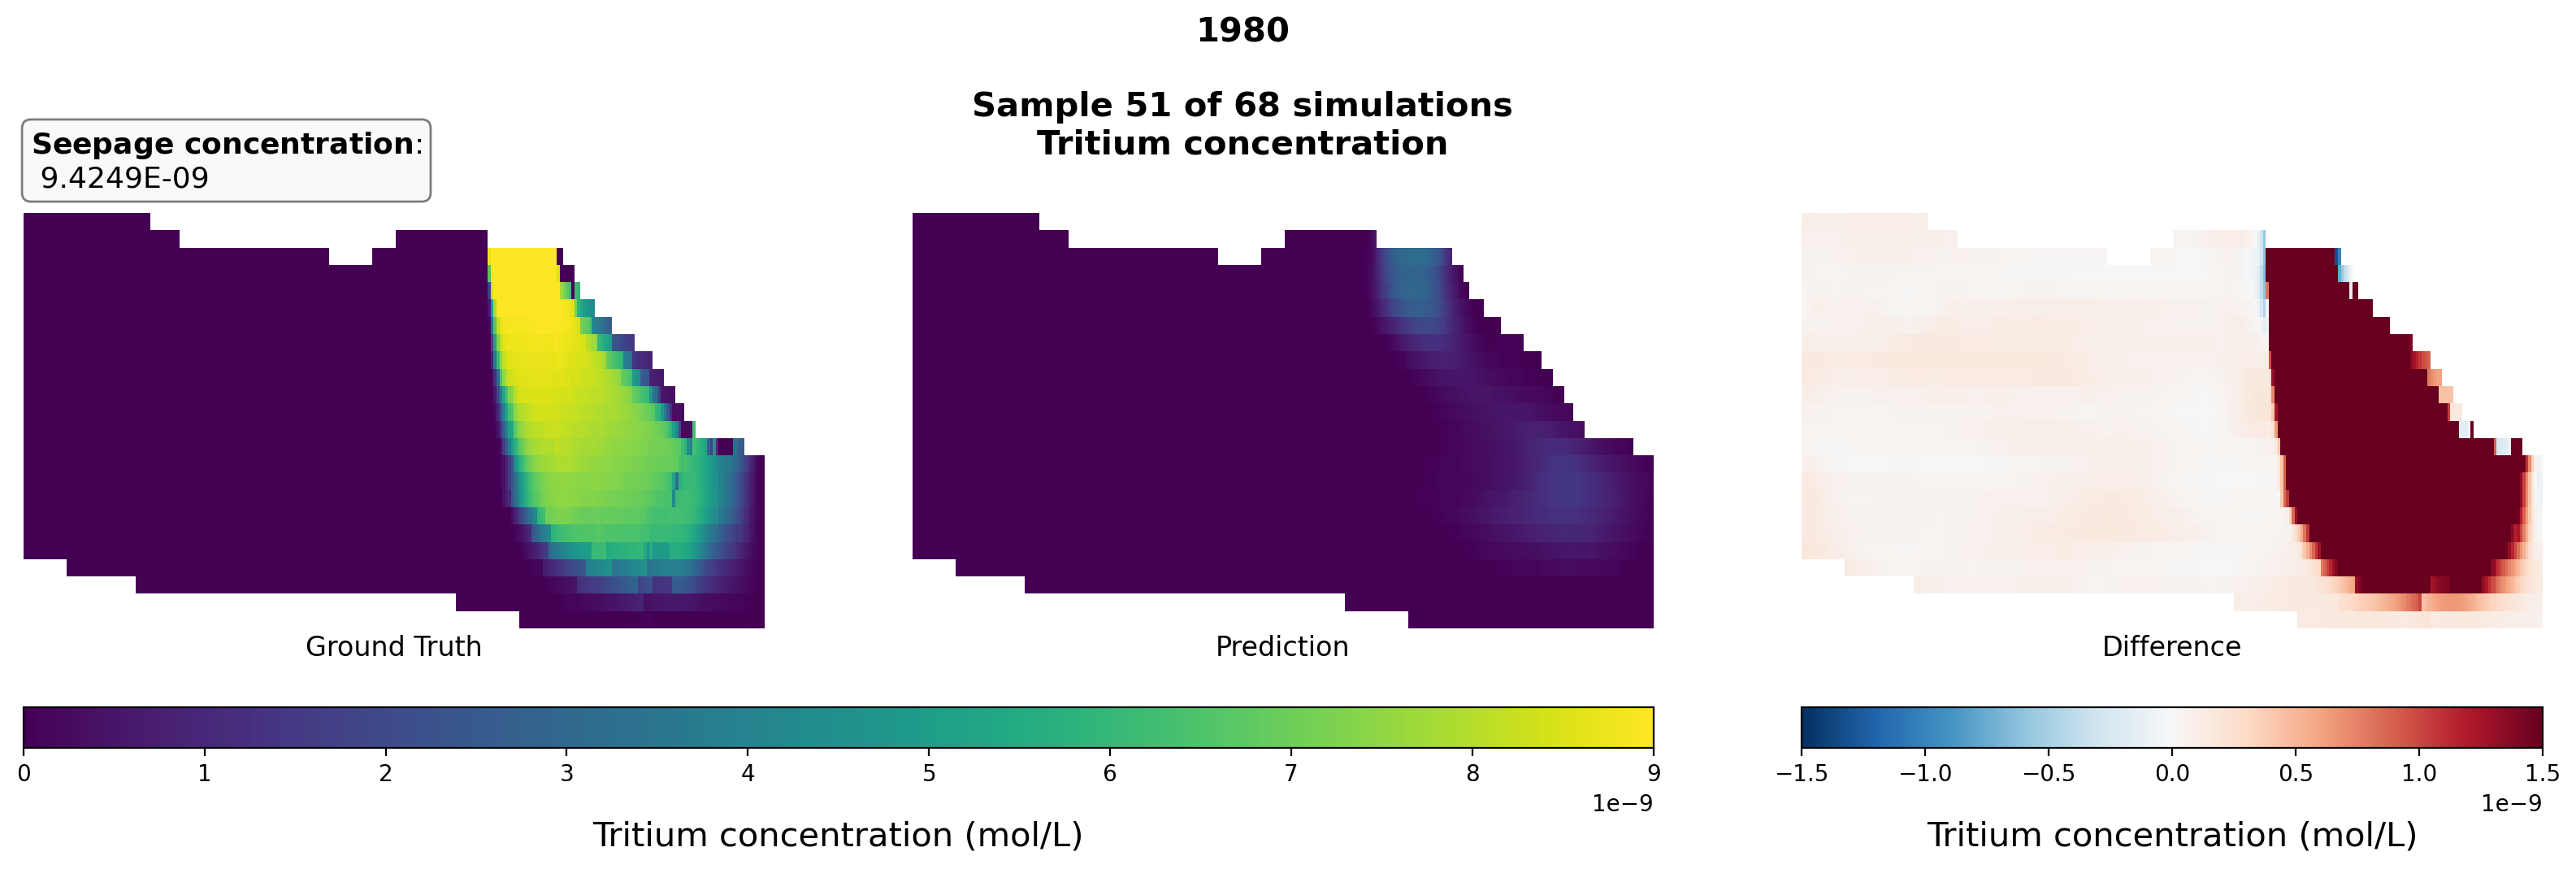

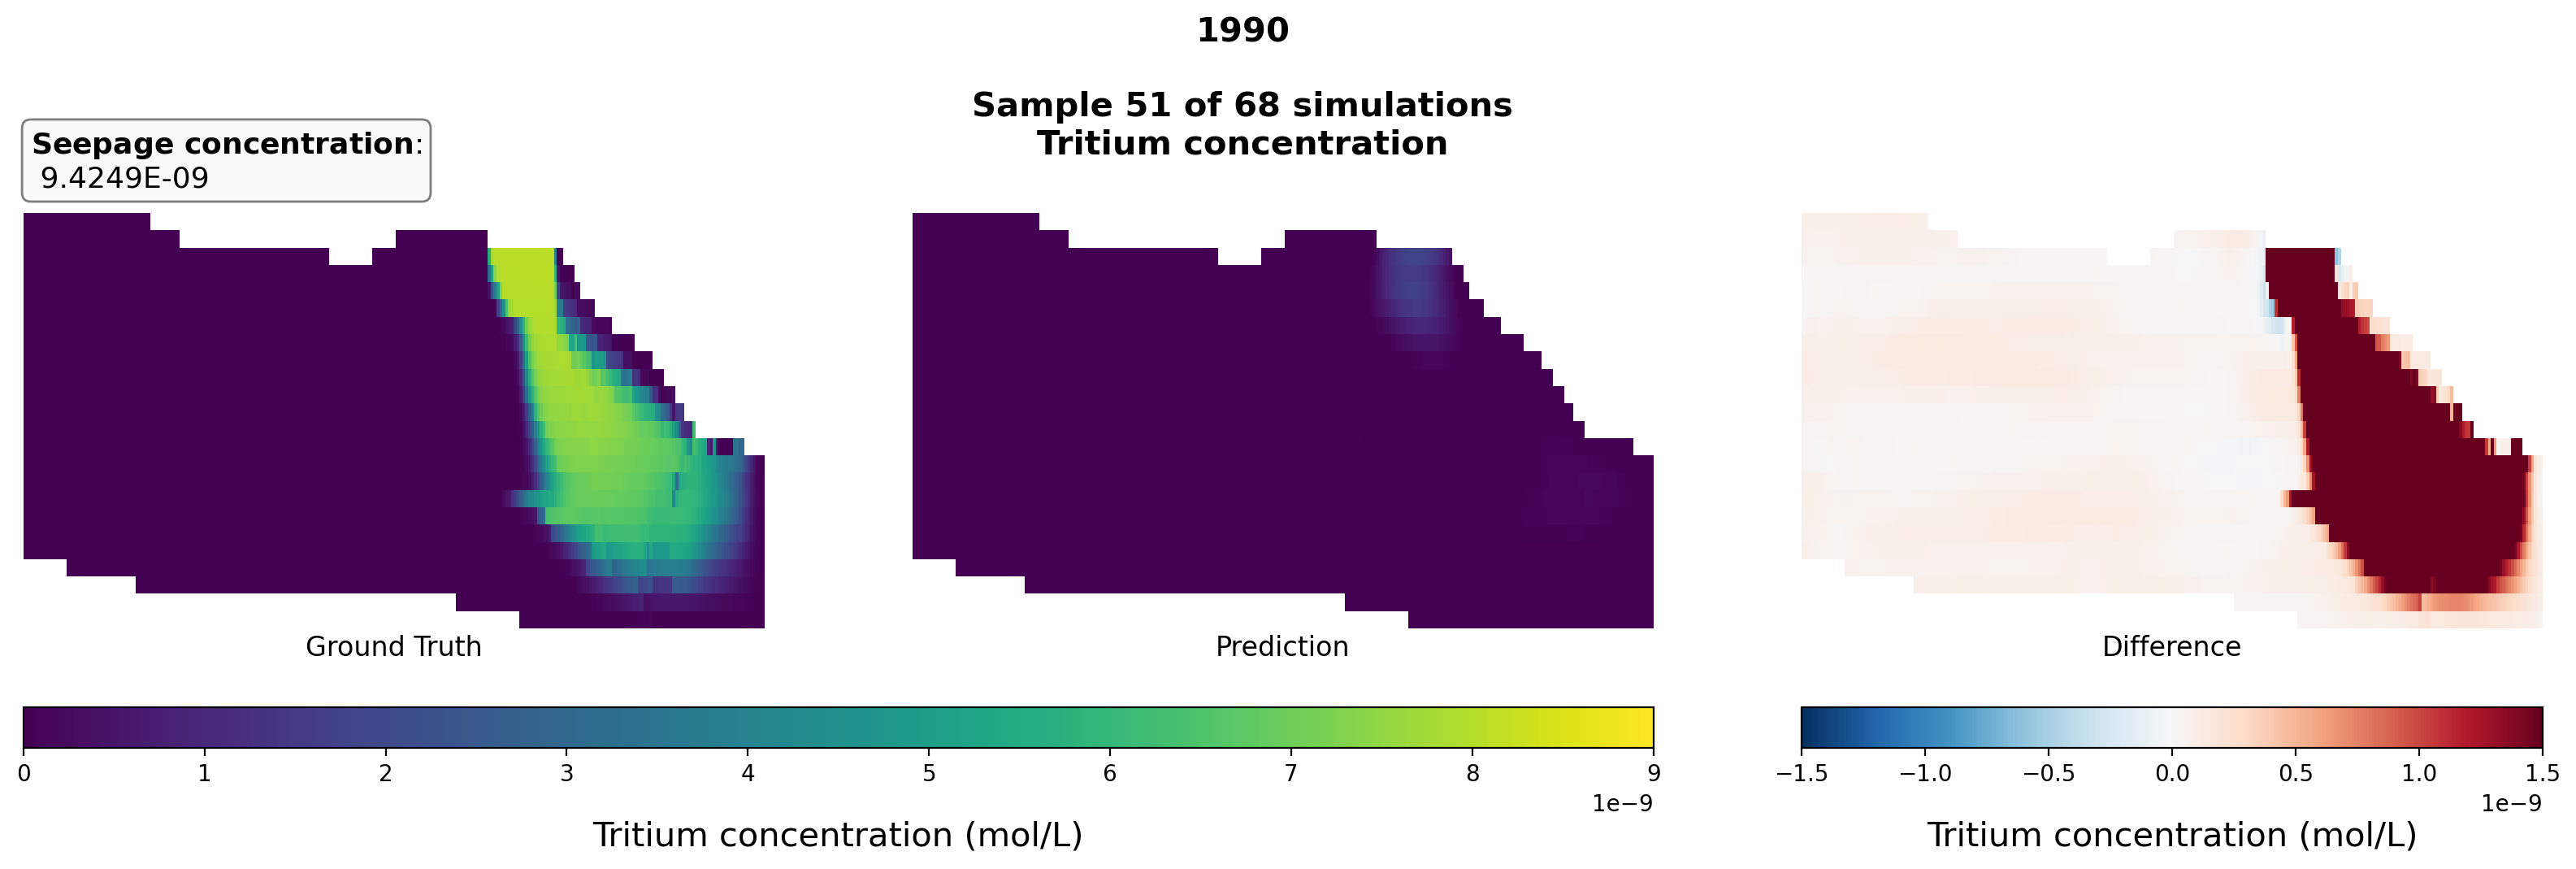

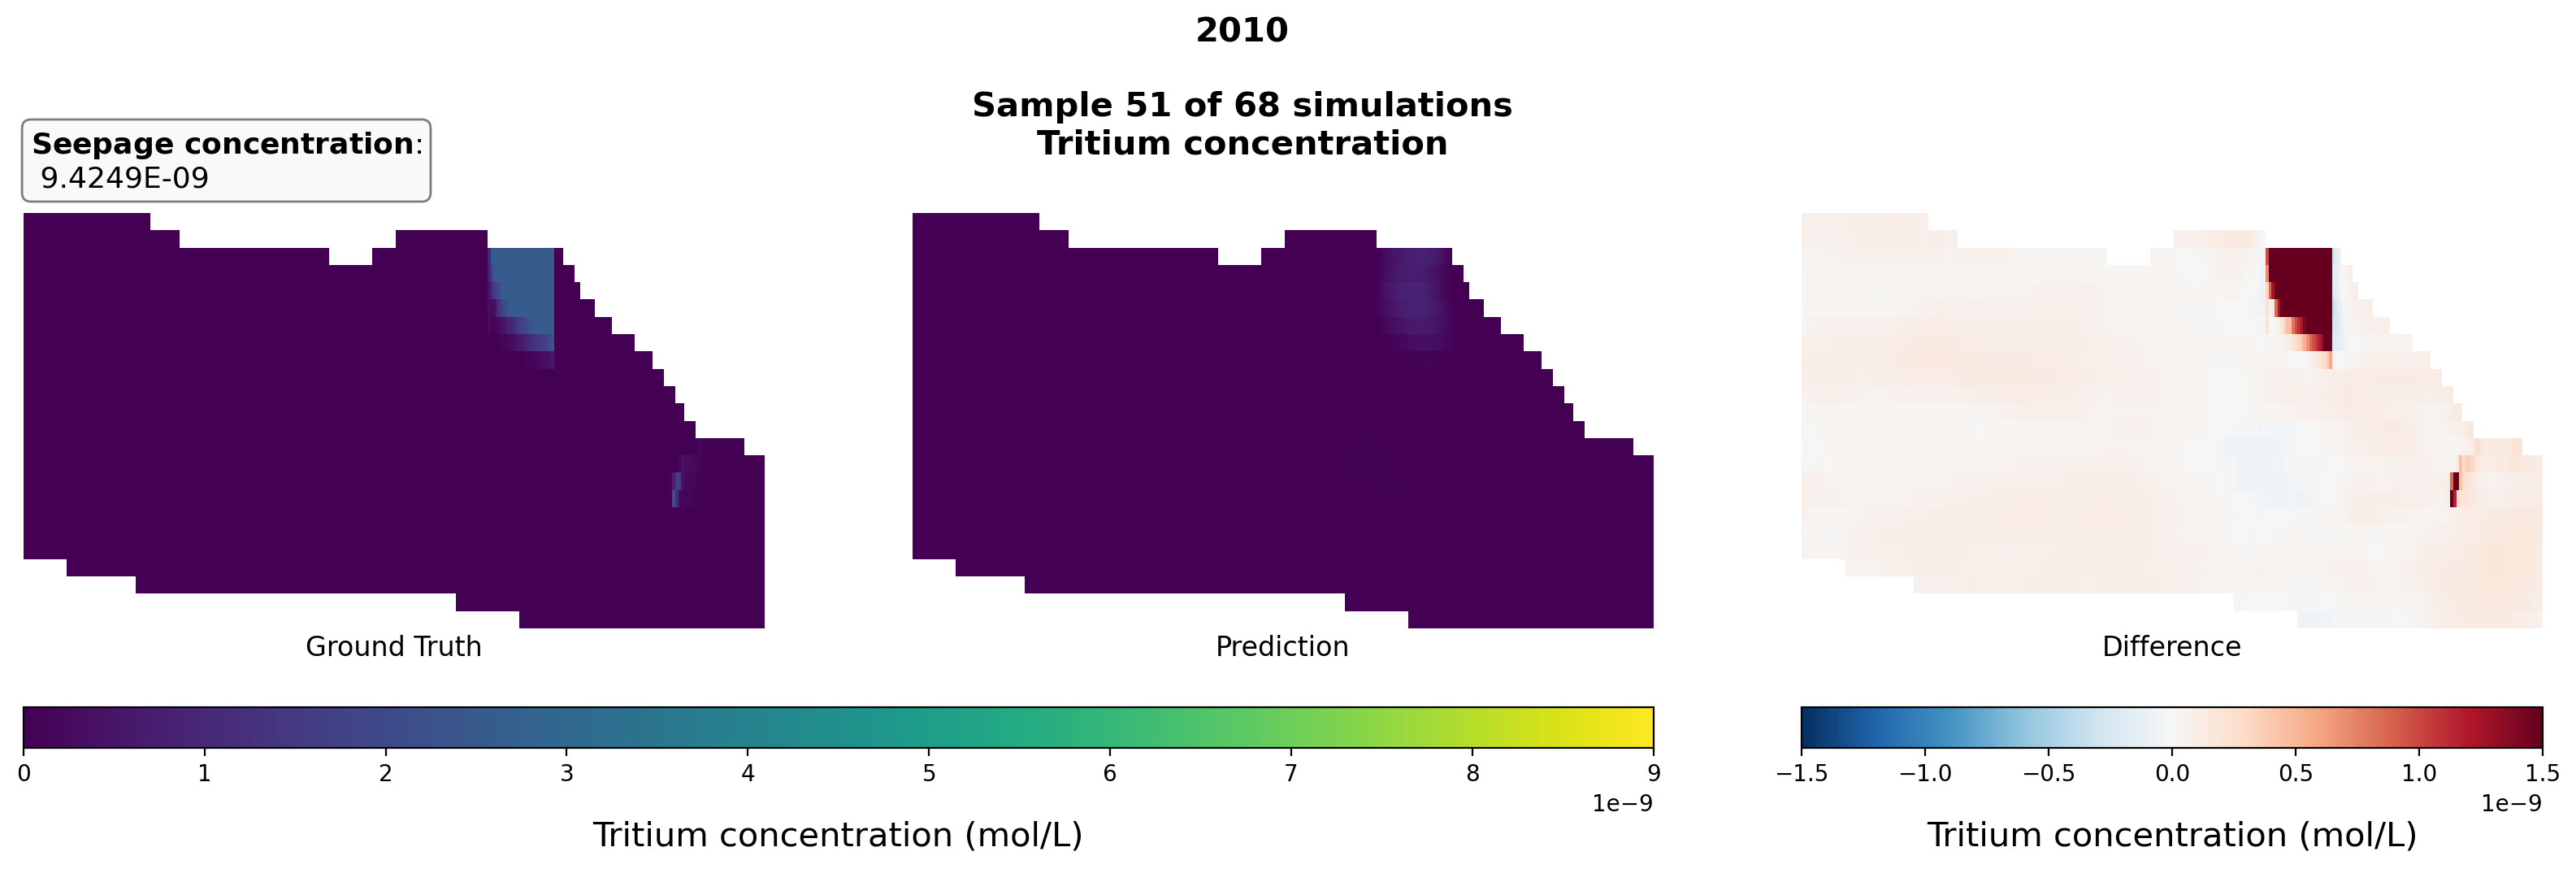

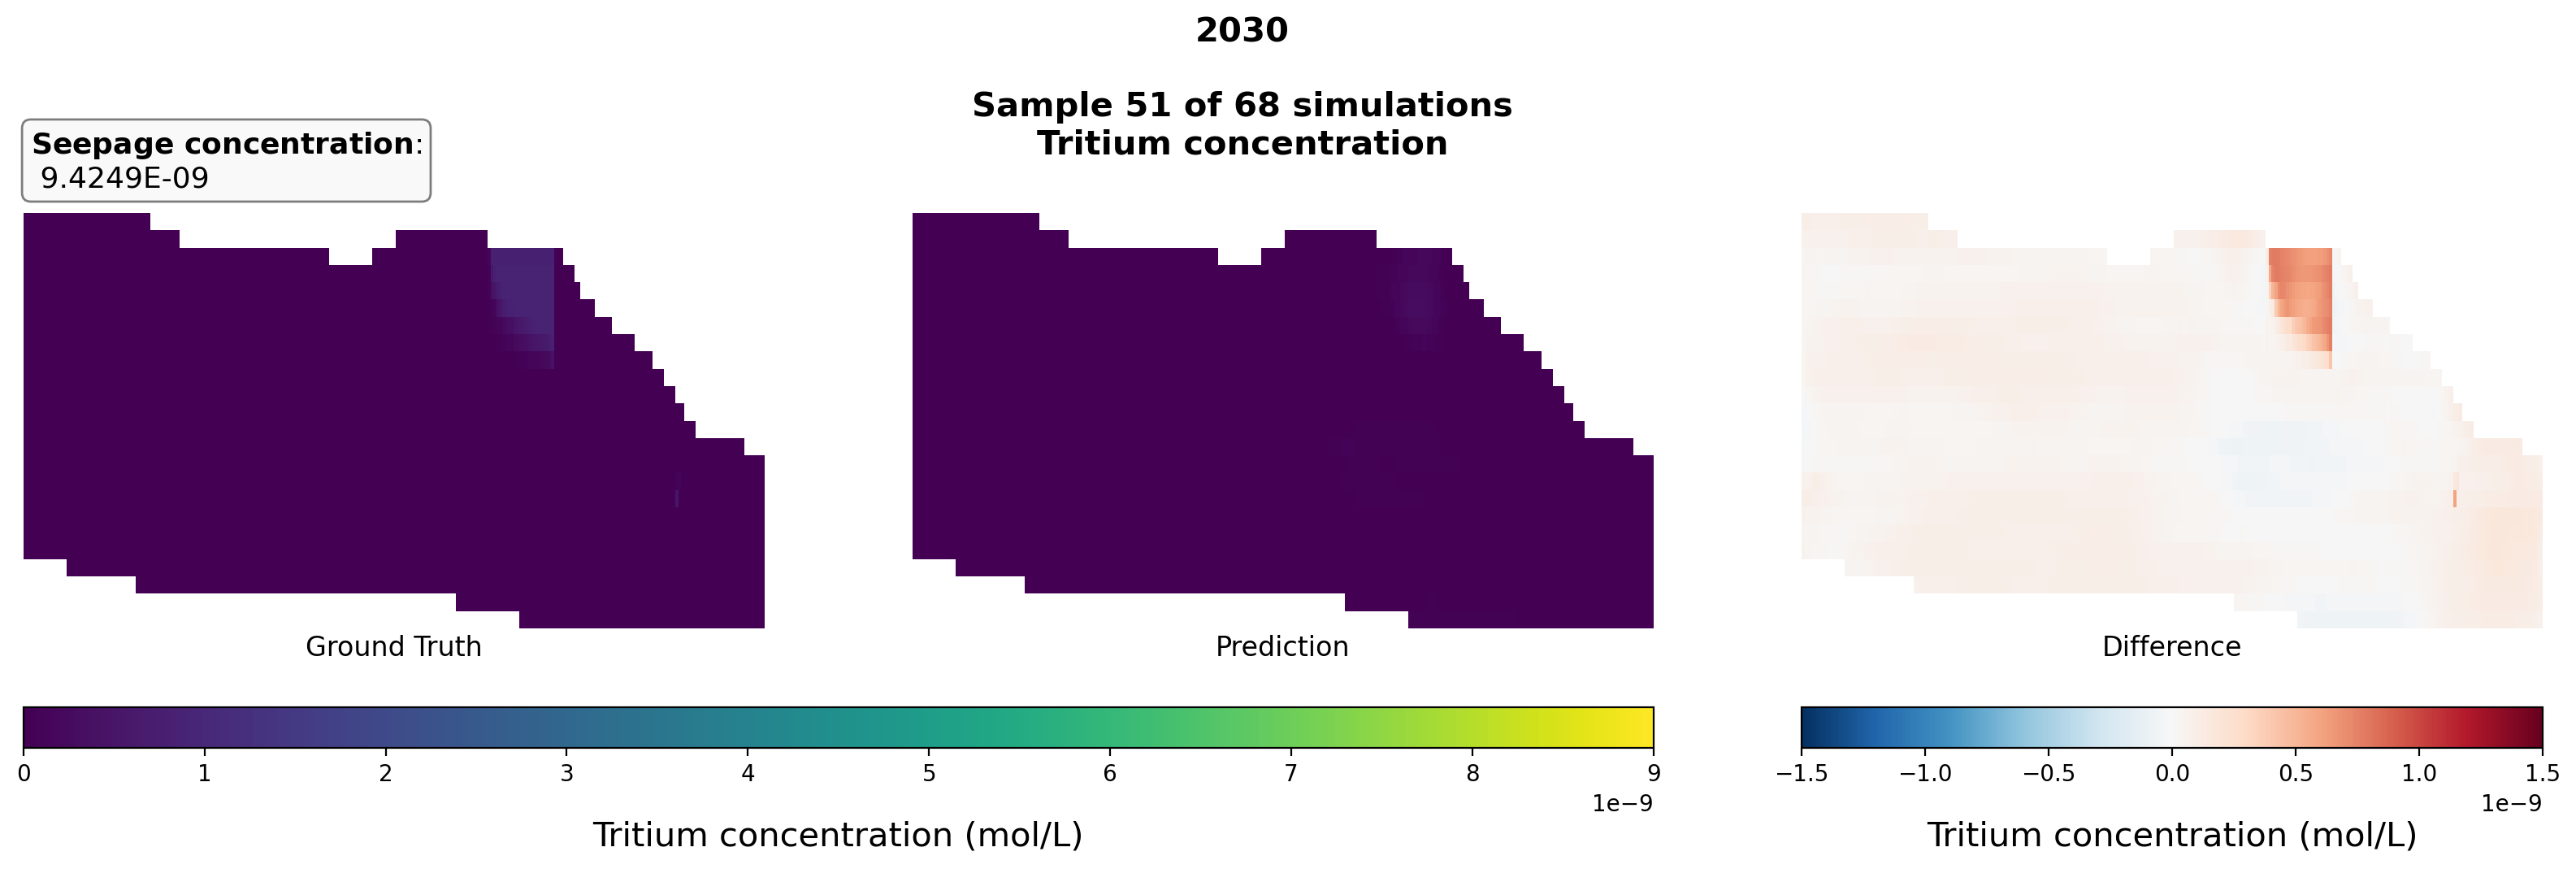

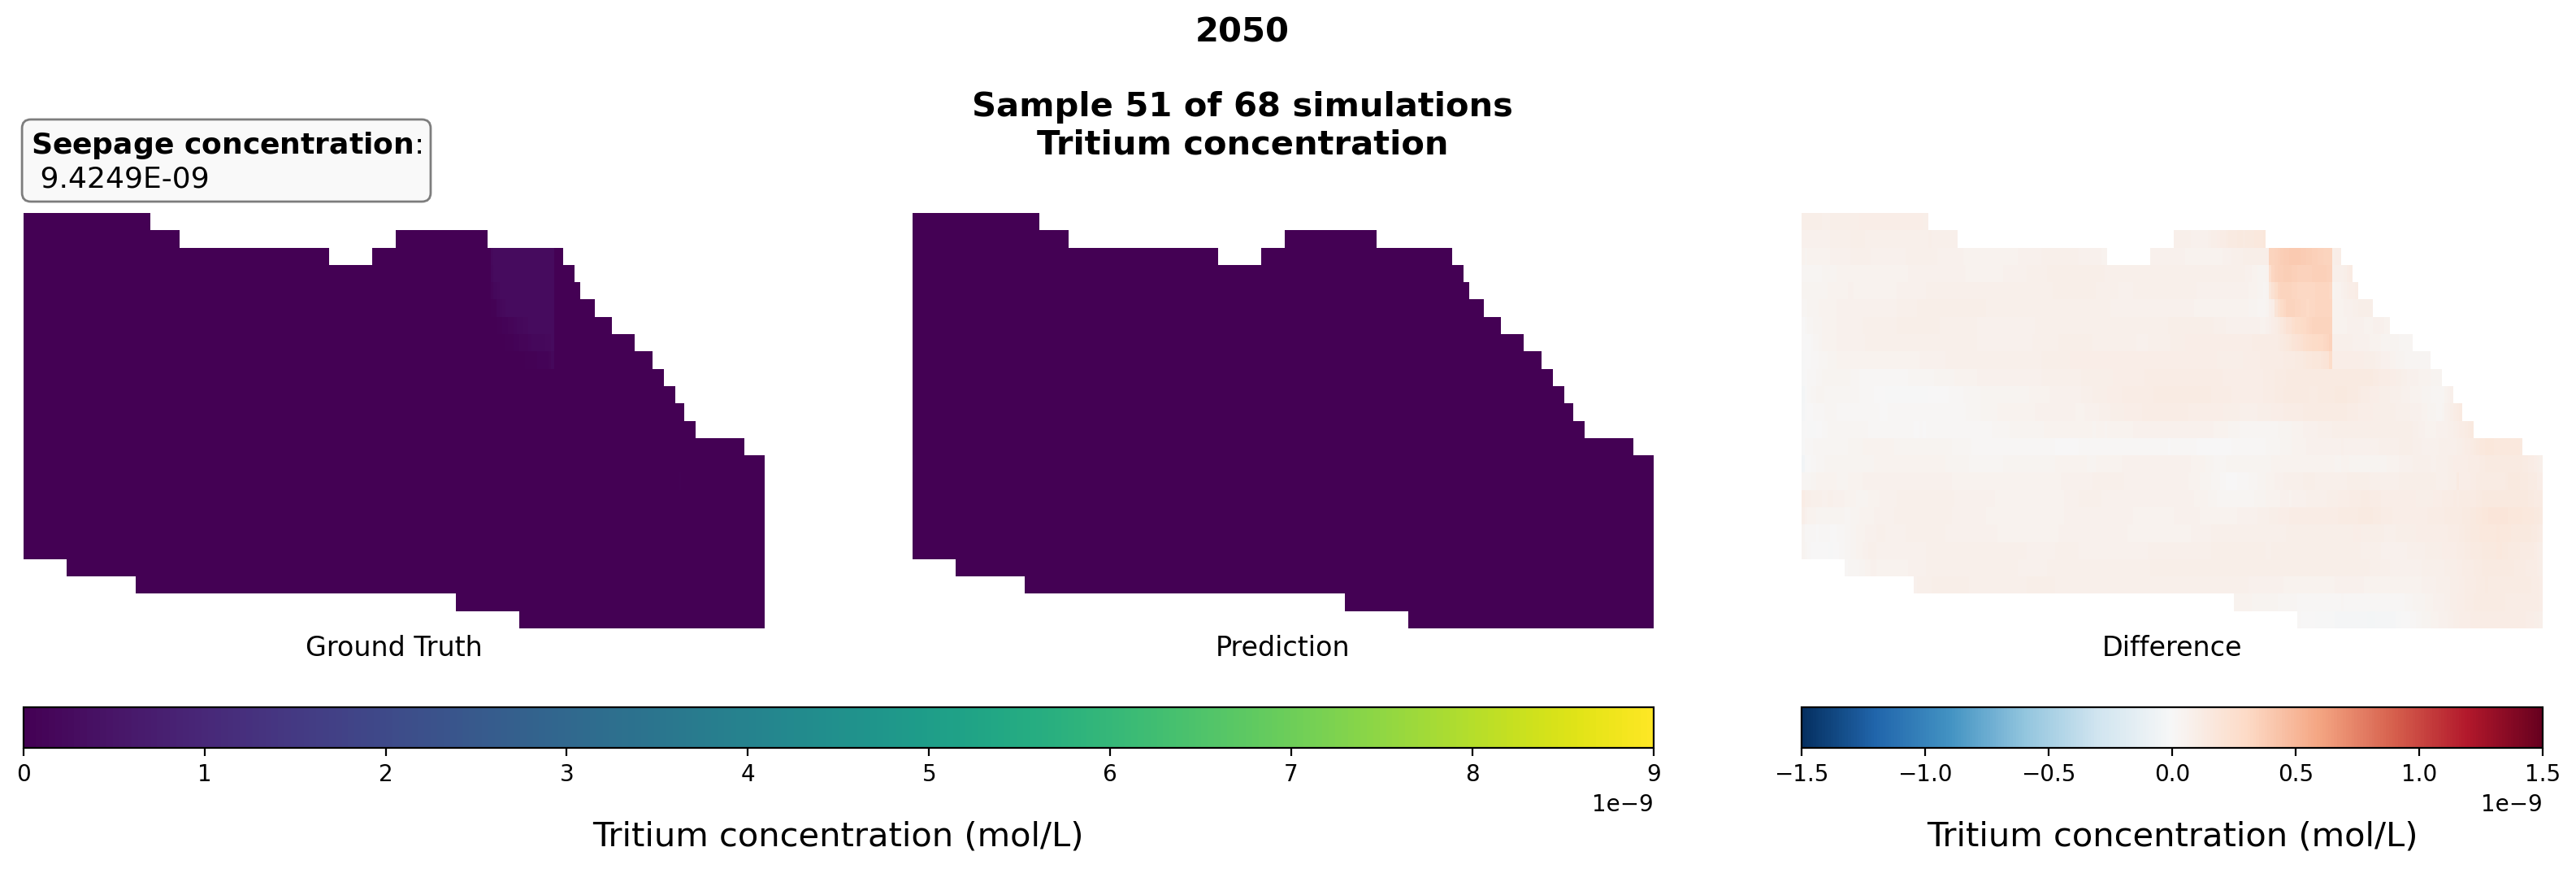

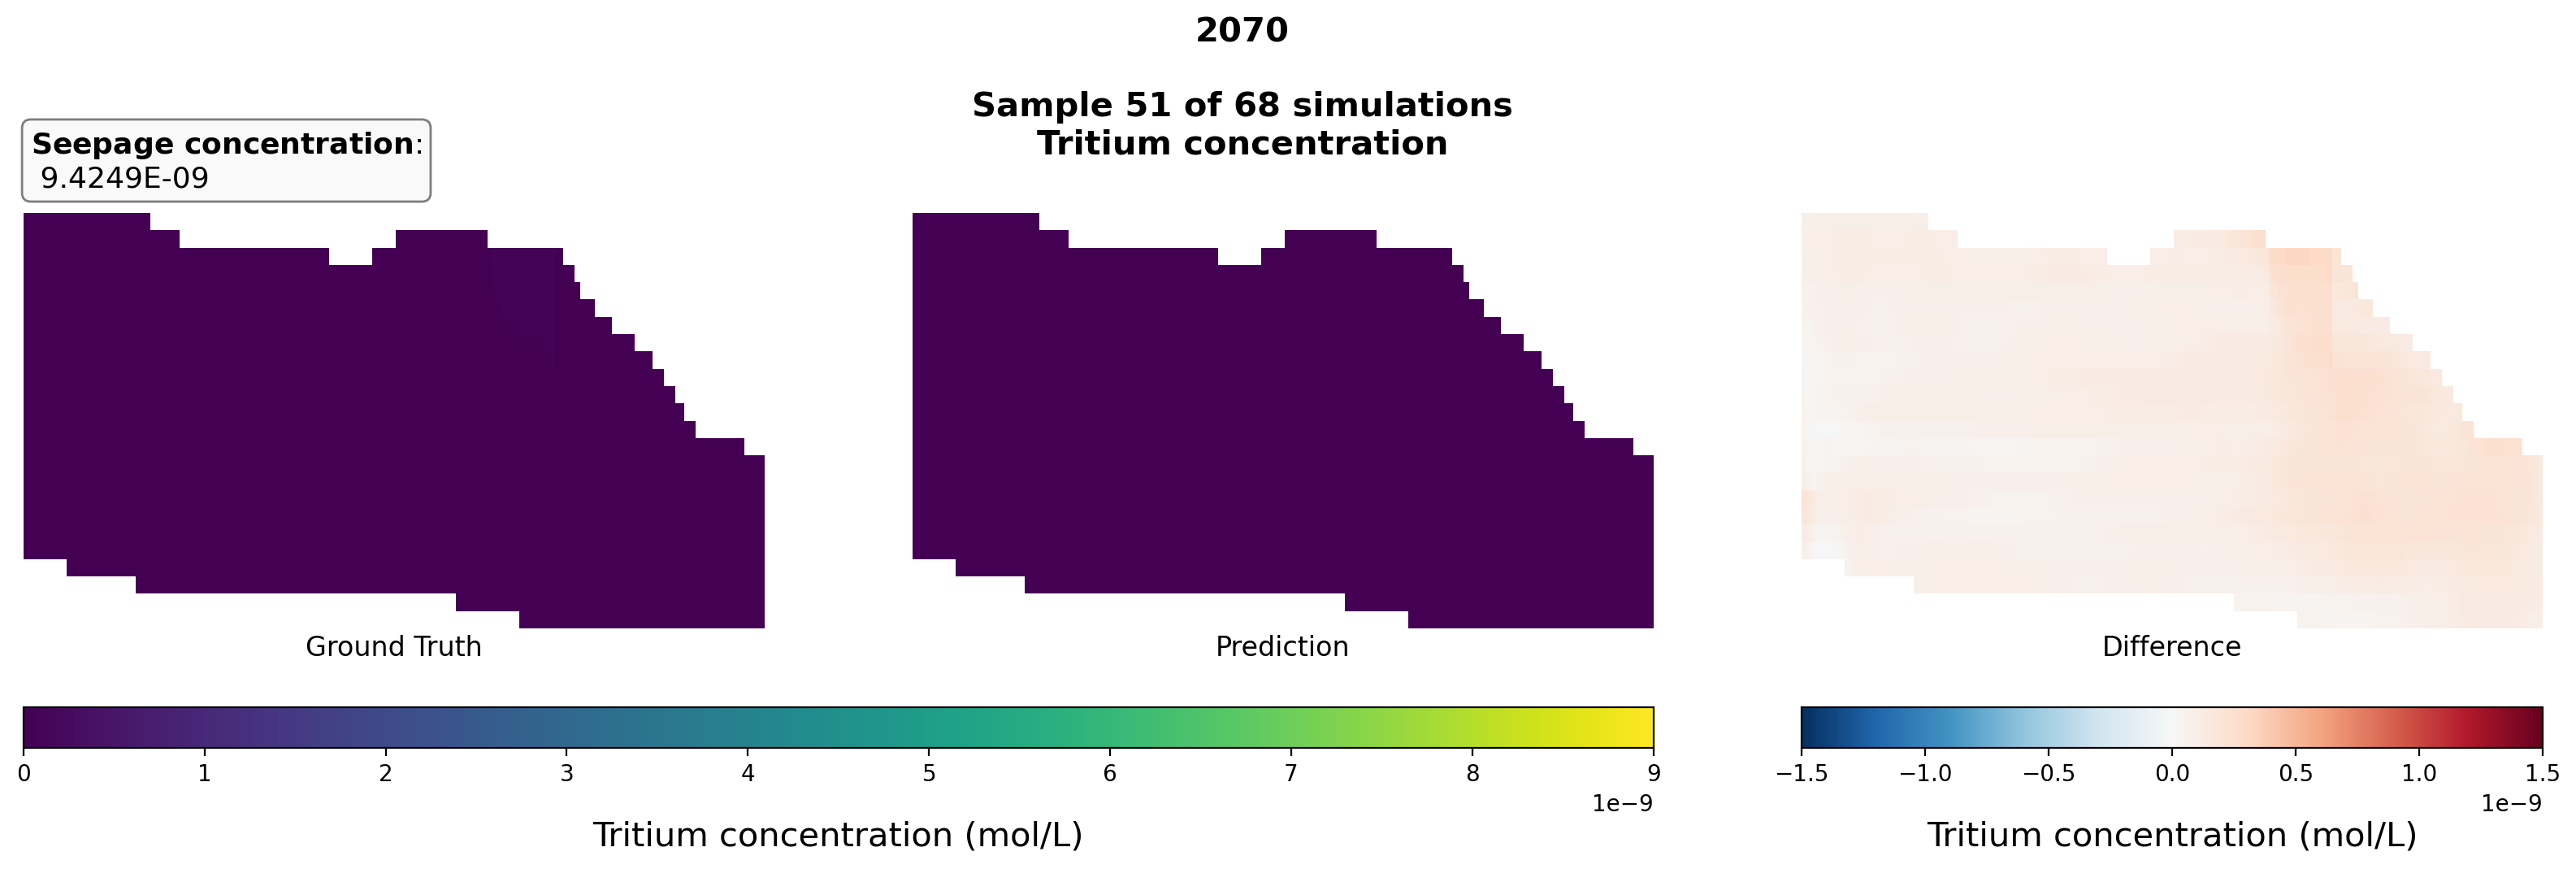

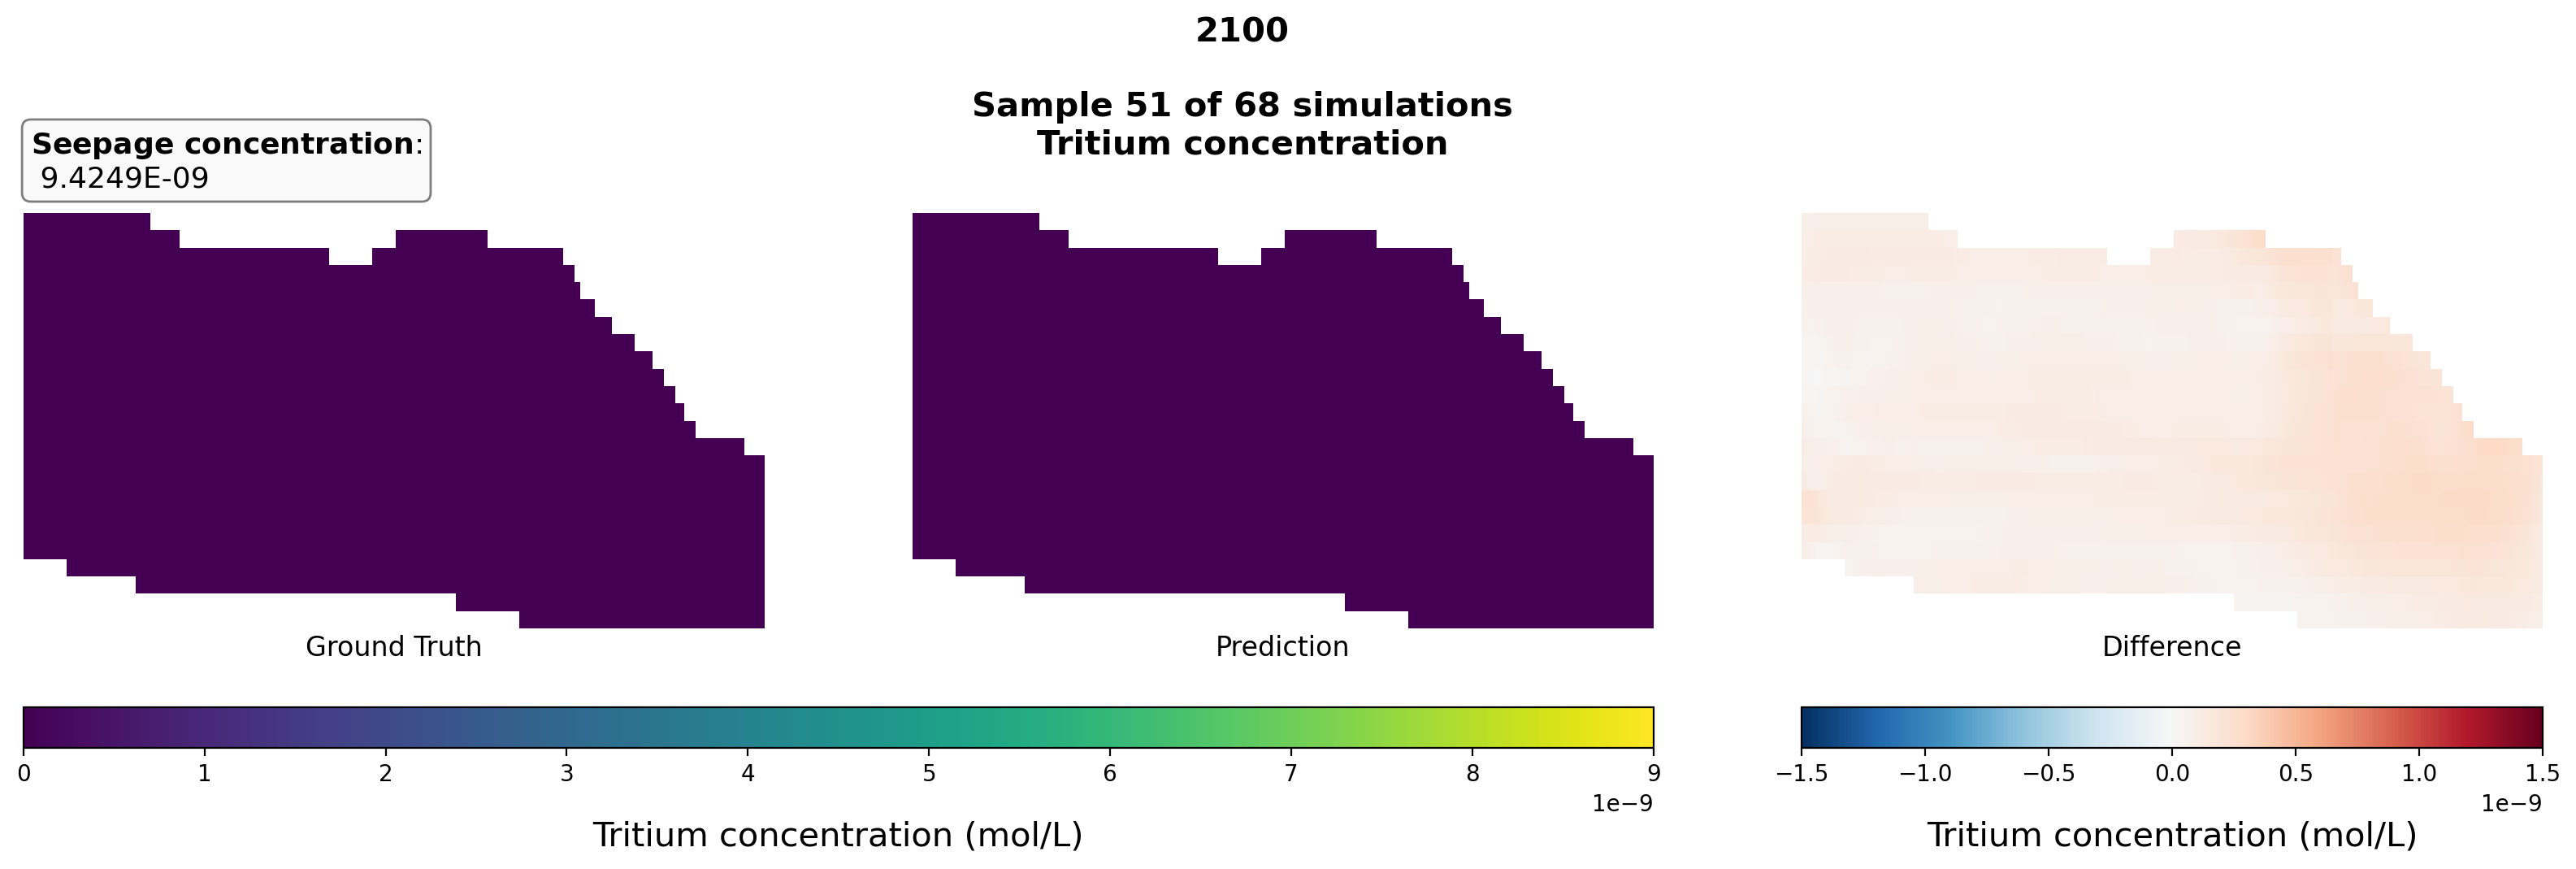

In [15]:
sample_num = 50
output_var = 3
diff_min = -1.5e-9
diff_max = 1.5e-9 

path = parent_folder+'/'+figures_folder
sub_folder = str("{}__Sample_{}_of_{}".format(output_names_4[output_var], sample_num, samples)).replace(" ", "")
animation_file_name = ("UFNO-3D_{}__Sample_{}_of_{}.gif".format(output_names_4[output_var], sample_num, samples)).replace(" ", "")
create_sim_sequence(sample_num, output_var, path, show_param=True, param_name='seepage concentration', diff_min=diff_min, diff_max=diff_max)
create_sim_animation(source_path=path+'/'+sub_folder, destination_path=parent_folder+'/'+animation_folder+'/'+animation_file_name)

# Inference with different parameters

In [11]:
def change_input_sample_value(sample_num=30, values = [3e-12],name = ['permeability']):
    input_max_recover = np.zeros(sim_parameters.shape[1]-1)
    input_max_recover[:8] = input_max_values.reshape(-1)[:8]
    input_max_recover[8] = input_max_recover[6]
    input_max_recover[9:] = input_max_recover[5]

    default_input_values = np.array(sim_parameters.values[:,1:sim_parameters.shape[1]],dtype = 'float64')[sample_num,:]/input_max_recover
    default_input_values = pd.DataFrame(default_input_values.reshape(1,-1),columns = sim_parameters.columns[1:])
    
    
    test_input = torch.clone(input_array[sample_num:(sample_num+1),:,:,:,:]).numpy()
    for idx,changed_name in enumerate(name):
        i = np.where(default_input_values.columns==changed_name)[0][0]
        test_input[test_input==default_input_values[default_input_values.columns[i]].values] = values[idx]/input_max_recover[i]

    return torch.from_numpy(test_input)

In [12]:
def visualization_change_parameters(sample_num=30, output_var=3, time=5, static_val=1e-5, var_val_max=2e-5, interval=1e-6, parameter_to_change='recharge mid-century', path=path, diff_min=-1e-10, diff_max=1e-10, fps=4):
    variable_val = np.arange(static_val+interval, var_val_max, interval)
    print(f"Number of frames: {len(variable_val)}, \n{variable_val}")

    x_static = change_input_sample_value(sample_num=sample_num, values = [1e-5,static_val,1e-5],name = ['recharge history', parameter_to_change,'recharge late-century'])
    y_static =  model(x_static.float().to(device)).cpu().detach().numpy()
    x = torch.zeros((1,nz,nx,nt,sim_parameters.columns[1:].shape[0], len(variable_val)))
    y = torch.zeros((nz,nx,nt,4, len(variable_val)))
    for i in range(len(variable_val)):
        x[:,:,:,:,:,i] = change_input_sample_value(sample_num=sample_num, values = [1e-5,variable_val[i],1e-5],name = ['recharge history', parameter_to_change,'recharge late-century'])
        y[:,:,:,:,i] =  model((x[:,:,:,:,:,i]).float().to(device)).cpu().detach()
    # REVERSE RESCALE
    selected_idx = np.array([0,1,2,5])
    for j in range(len(selected_idx)):
        if(i==5):
            i=3
        y_static[:,:,:,j] = y_static[:,:,:,j] * (rescale_factors[selected_idx[j]]['max']-rescale_factors[selected_idx[j]]['min']) + rescale_factors[selected_idx[j]]['min']
        y[:,:,:,j,:] = y[:,:,:,j,:] * (rescale_factors[selected_idx[j]]['max']-rescale_factors[selected_idx[j]]['min']) + rescale_factors[selected_idx[j]]['min']
    
    
    def visualize_sample(sample_num, output_var, time, static_val, change_val, y_static, y_change, diff, path='', var_min=None, var_max=None, save=False, diff_min=None, diff_max=None, show_param=False, param_name= "", fps=4):
        fig, ax = plt.subplots(1,3, figsize=(20,5), dpi=200)
        font_size = 15
        aspect = 6
        
        if(var_min==None):
            var_min = np.nanmin(y[ :,:,time, output_var,:])
        if(var_max==None):
            var_max = np.nanmax(y[ :,:,time, output_var,:])


        left = ax[0].imshow((y_static[ :,:,time, output_var]*vis_mask).reshape(nz,nx), aspect=aspect, origin ='lower', vmin=var_min, vmax=var_max)
        middle = ax[1].imshow((y_change[ :,:,time, output_var]*vis_mask).reshape(nz,nx), aspect=aspect, origin ='lower',vmin=var_min, vmax=var_max)
        right = ax[2].imshow((diff[ :,:,time, output_var]*vis_mask).reshape(nz,nx), aspect=aspect, origin ='lower', cmap = 'RdBu_r', vmin=diff_min, vmax=diff_max)
        
        # TEXT BOX SETTINGS
        if(show_param):
            value = input_params.iloc[sample_num][param_name]
            textstr = "$\\bf{"+param_name.replace(' ', '\ ').capitalize()+"}$" + f":\n {value:.4E}"
            props = dict(boxstyle='round', facecolor='whitesmoke', alpha=0.5)
            ax[0].text(0.01, 1.2, textstr, transform=ax[0].transAxes, fontsize=font_size-2,
                    verticalalignment='top', bbox=props)


        # TITLES
        fig.suptitle("{}\n\n {}".format(time_steps[time], output_names_4[output_var]), fontsize=font_size, fontweight="bold", y=1)

        subtitles = [f"{parameter_to_change}:\n{static_val: .2E}", f"{parameter_to_change}:\n{change_val:.2E}", "Difference\n"]
        for i in range(ax.shape[0]):
            ax[i].axis('off')
            ax[i].set_title(subtitles[i], y=-0.2)

        # COLORBAR SETTINGS
        p0 = ax[0].get_position().get_points().flatten()
        p1 = ax[1].get_position().get_points().flatten()
        p2 = ax[2].get_position().get_points().flatten()
        ax_cbar = fig.add_axes([p0[0], 0.1, p1[2]-p0[0], 0.05])
        fig.colorbar(left, cax=ax_cbar, orientation='horizontal').set_label(label="{} ({})".format(output_names_4[output_var], output_units_4[output_var]), size=font_size, labelpad=15)
        ax_cbar1 = fig.add_axes([p2[0], 0.1, p2[2]-p2[0], 0.05])
        fig.colorbar(right, cax=ax_cbar1, orientation='horizontal').set_label(label="{} ({})".format(output_names_4[output_var], output_units_4[output_var]), size=font_size, labelpad=15)
        if(save):
            sub_folder = str("UFNO-3D__time_{}__{}__{}__max_{}".format(time_steps[time],output_names_4[output_var], parameter_to_change, var_val_max)).replace(" ", "")
            file_name = str("Time_{}__{}__Sample_{}_of_{}__val_{}.png".format(time_steps[time], output_names_4[output_var], sample_num, samples, change_val)).replace(" ", "")
            if not os.path.exists(path+'/'+sub_folder):
                os.makedirs(path+'/'+sub_folder)
            plt.ioff()
            plt.savefig(path+'/'+sub_folder+'/'+file_name, bbox_inches='tight')
    
    def create_sim_animation(source_path, destination_path, fps=4):
        images = []
        for file_name in sorted(os.listdir(source_path)):
            if file_name.endswith('.png'):
                file_path = os.path.join(source_path, file_name)
                images.append(imageio.imread(file_path))
                
        imageio.mimsave(destination_path, images, fps=4)

    for i in tqdm(range(len(variable_val))):
    # for i in range(1):
        change_val = variable_val[i]
        y_change = y[:,:,:,:,i]
        diff = y_change - y_static
        # print(static_val, change_val)
        visualize_sample(sample_num, output_var, time, static_val, change_val, y_static, y_change, diff, path, save=True,diff_min=diff_min, diff_max=diff_max)
    

    path = parent_folder+'/'+figures_folder
    sub_folder = str("UFNO-3D__time_{}__{}__{}__max_{}".format(time_steps[time],output_names_4[output_var], parameter_to_change, var_val_max)).replace(" ", "")
    animation_file_name = str("UFNO-3D__time_{}__{}__{}__max_{}.gif".format(time_steps[time], output_names_4[output_var], parameter_to_change, var_val_max)).replace(" ", "")
    create_sim_animation(source_path=path+'/'+sub_folder, destination_path=parent_folder+'/'+animation_folder+'/'+animation_file_name, fps=fps)

NameError: name 'path' is not defined

Number of frames: 24, 
[1.2e-05 1.4e-05 1.6e-05 1.8e-05 2.0e-05 2.2e-05 2.4e-05 2.6e-05 2.8e-05
 3.0e-05 3.2e-05 3.4e-05 3.6e-05 3.8e-05 4.0e-05 4.2e-05 4.4e-05 4.6e-05
 4.8e-05 5.0e-05 5.2e-05 5.4e-05 5.6e-05 5.8e-05]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:14<00:00,  1.68it/s]
/home/aurelien_meray_gmail_com/.local/lib/python3.7/site-packages/ipykernel_launcher.py:77: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


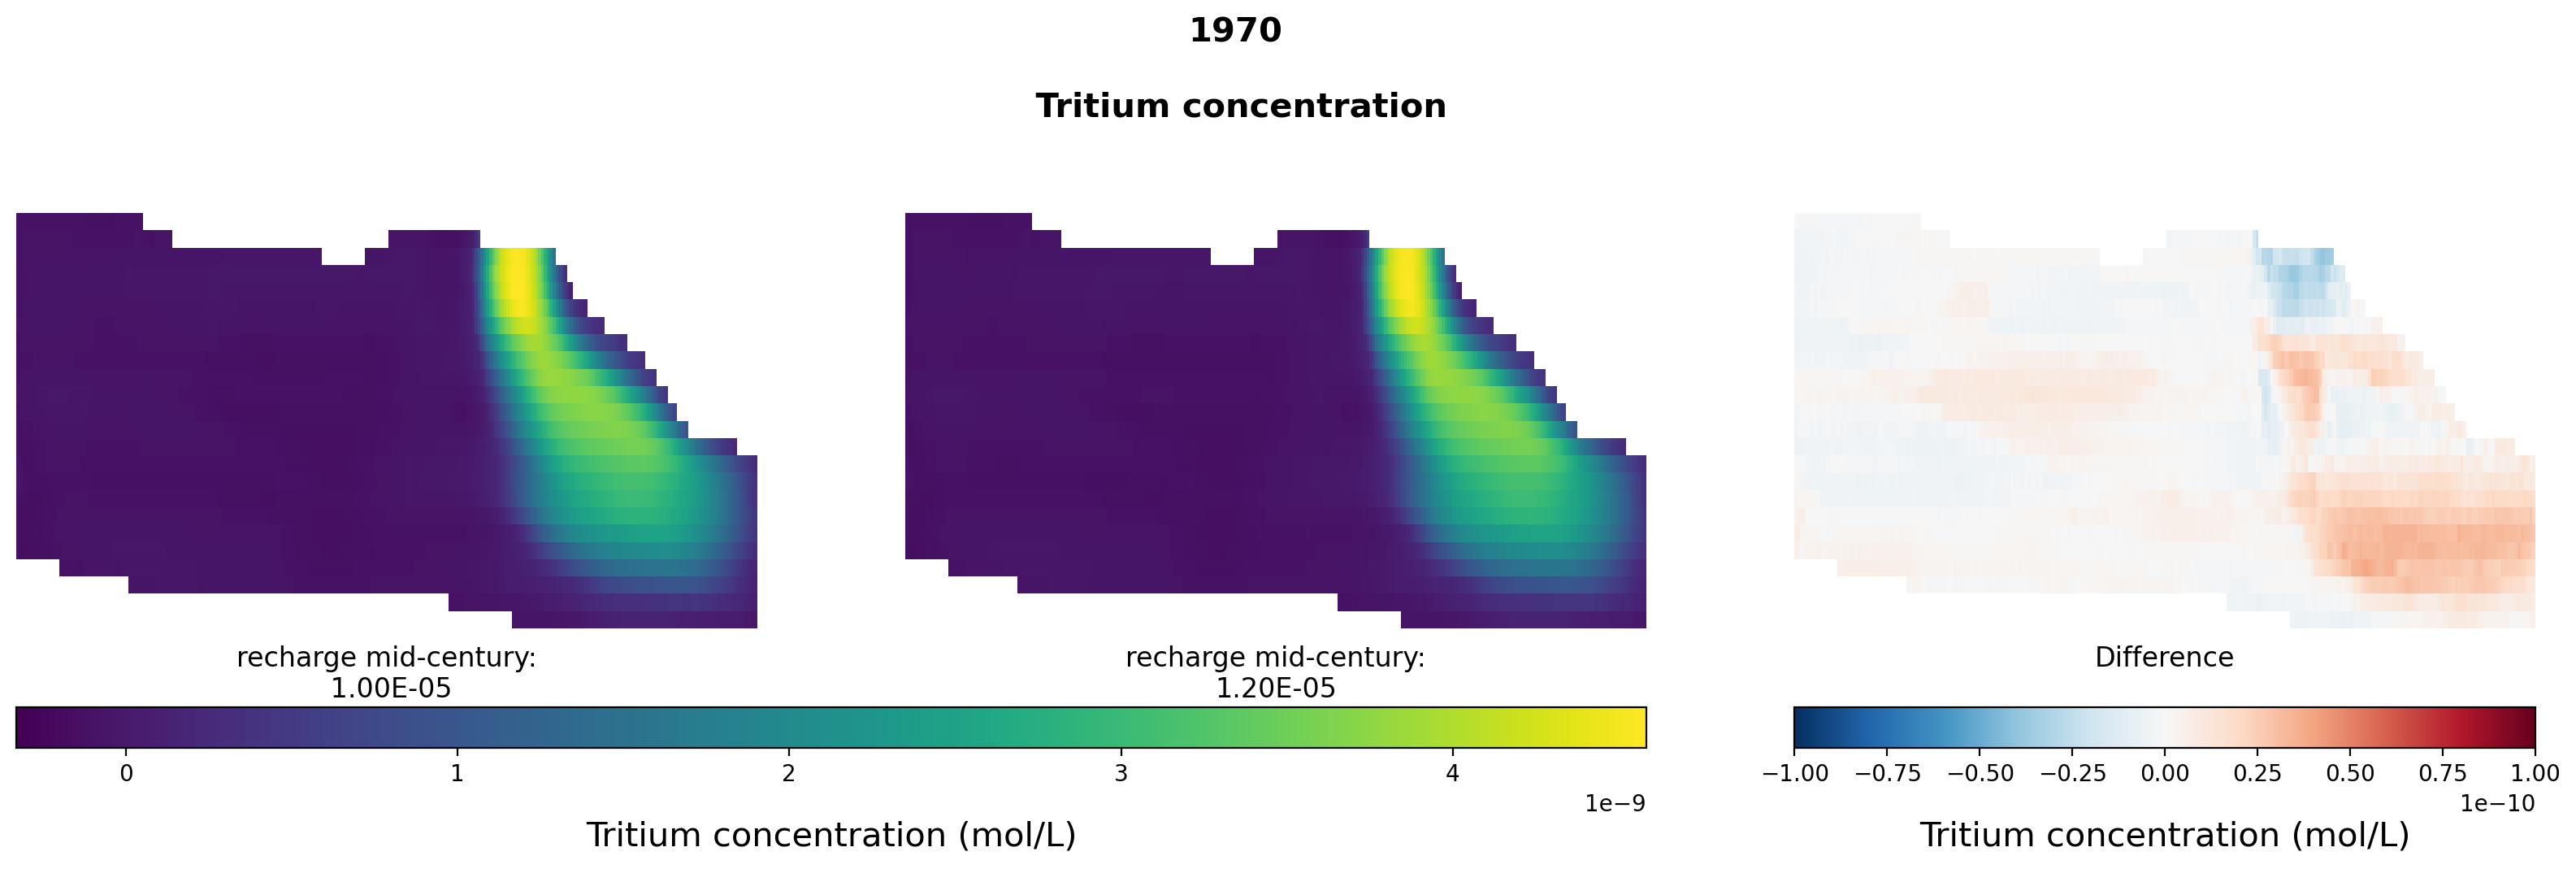

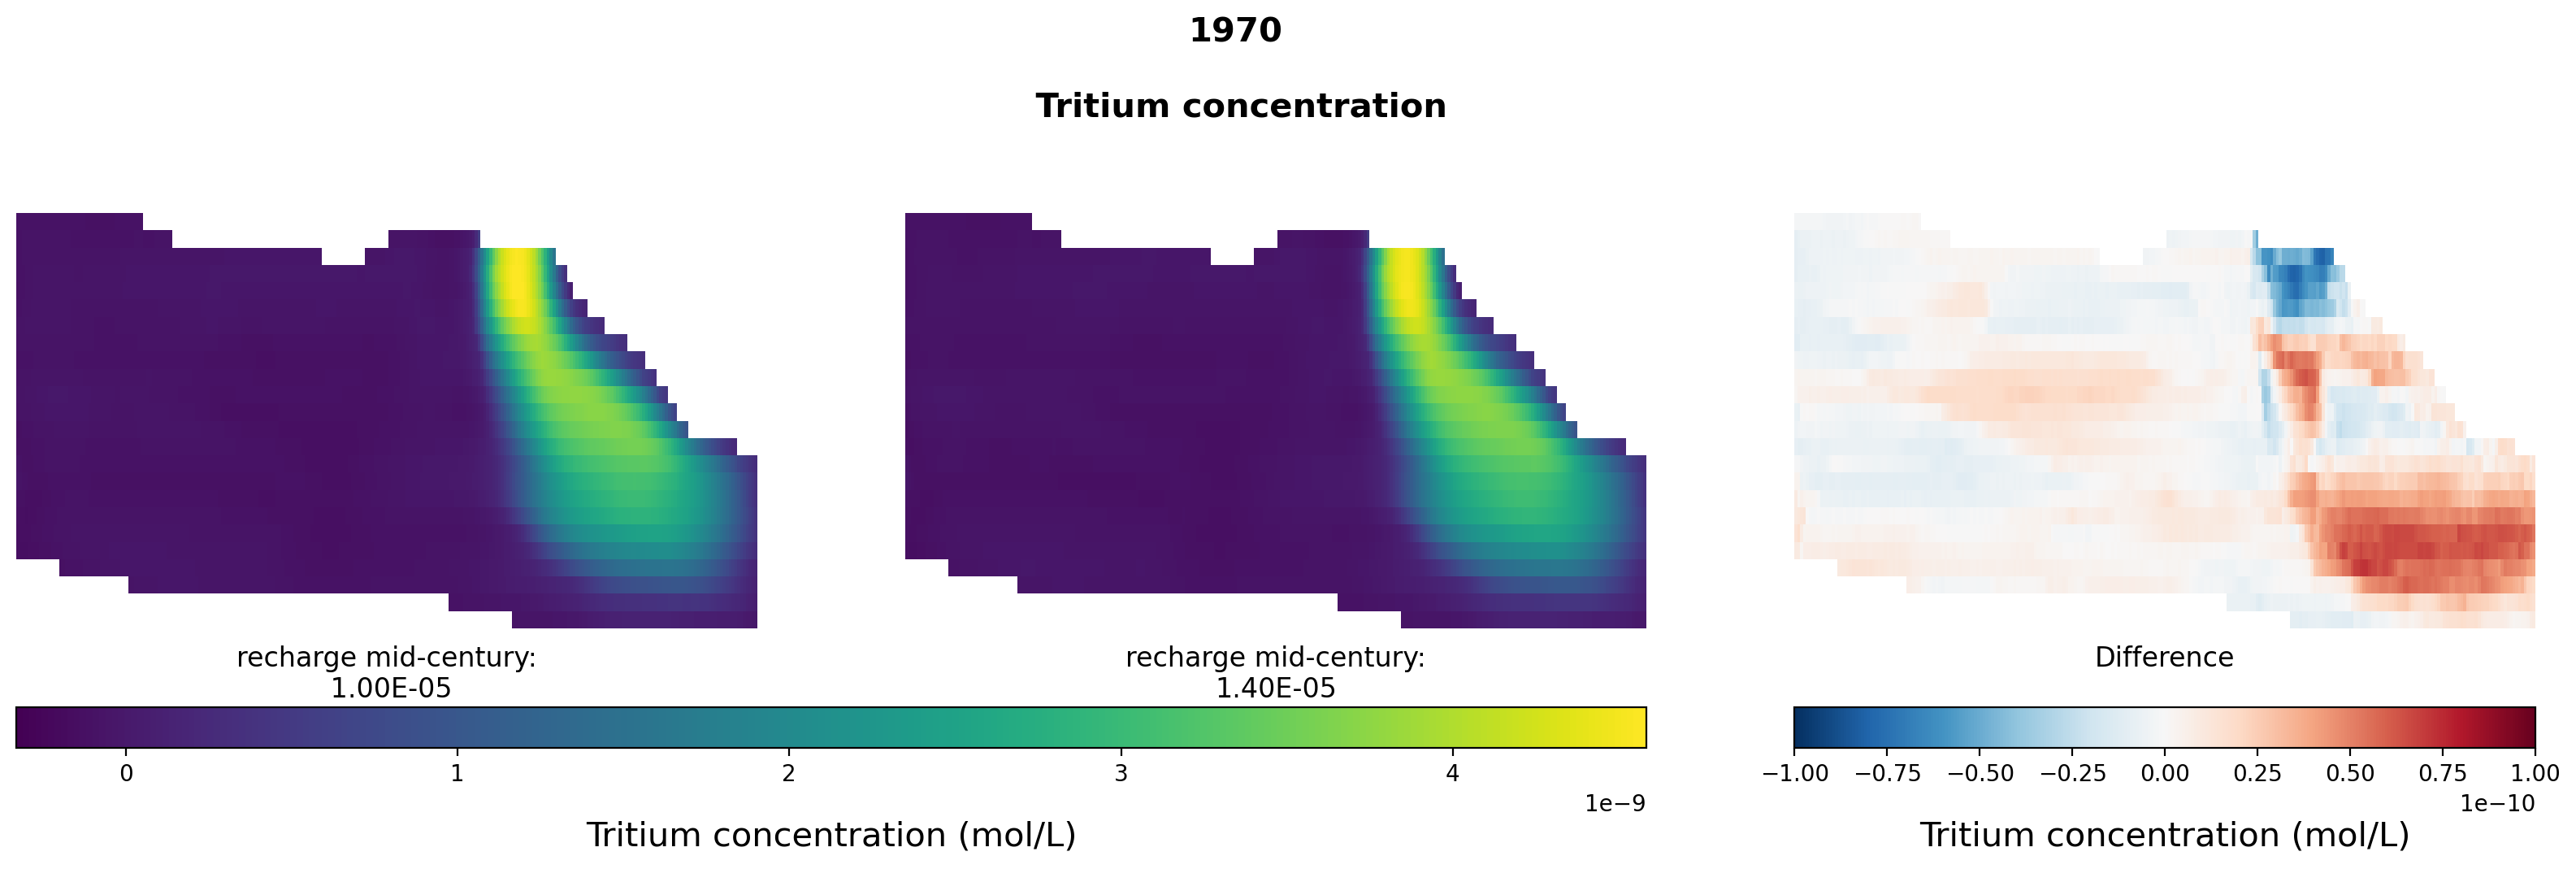

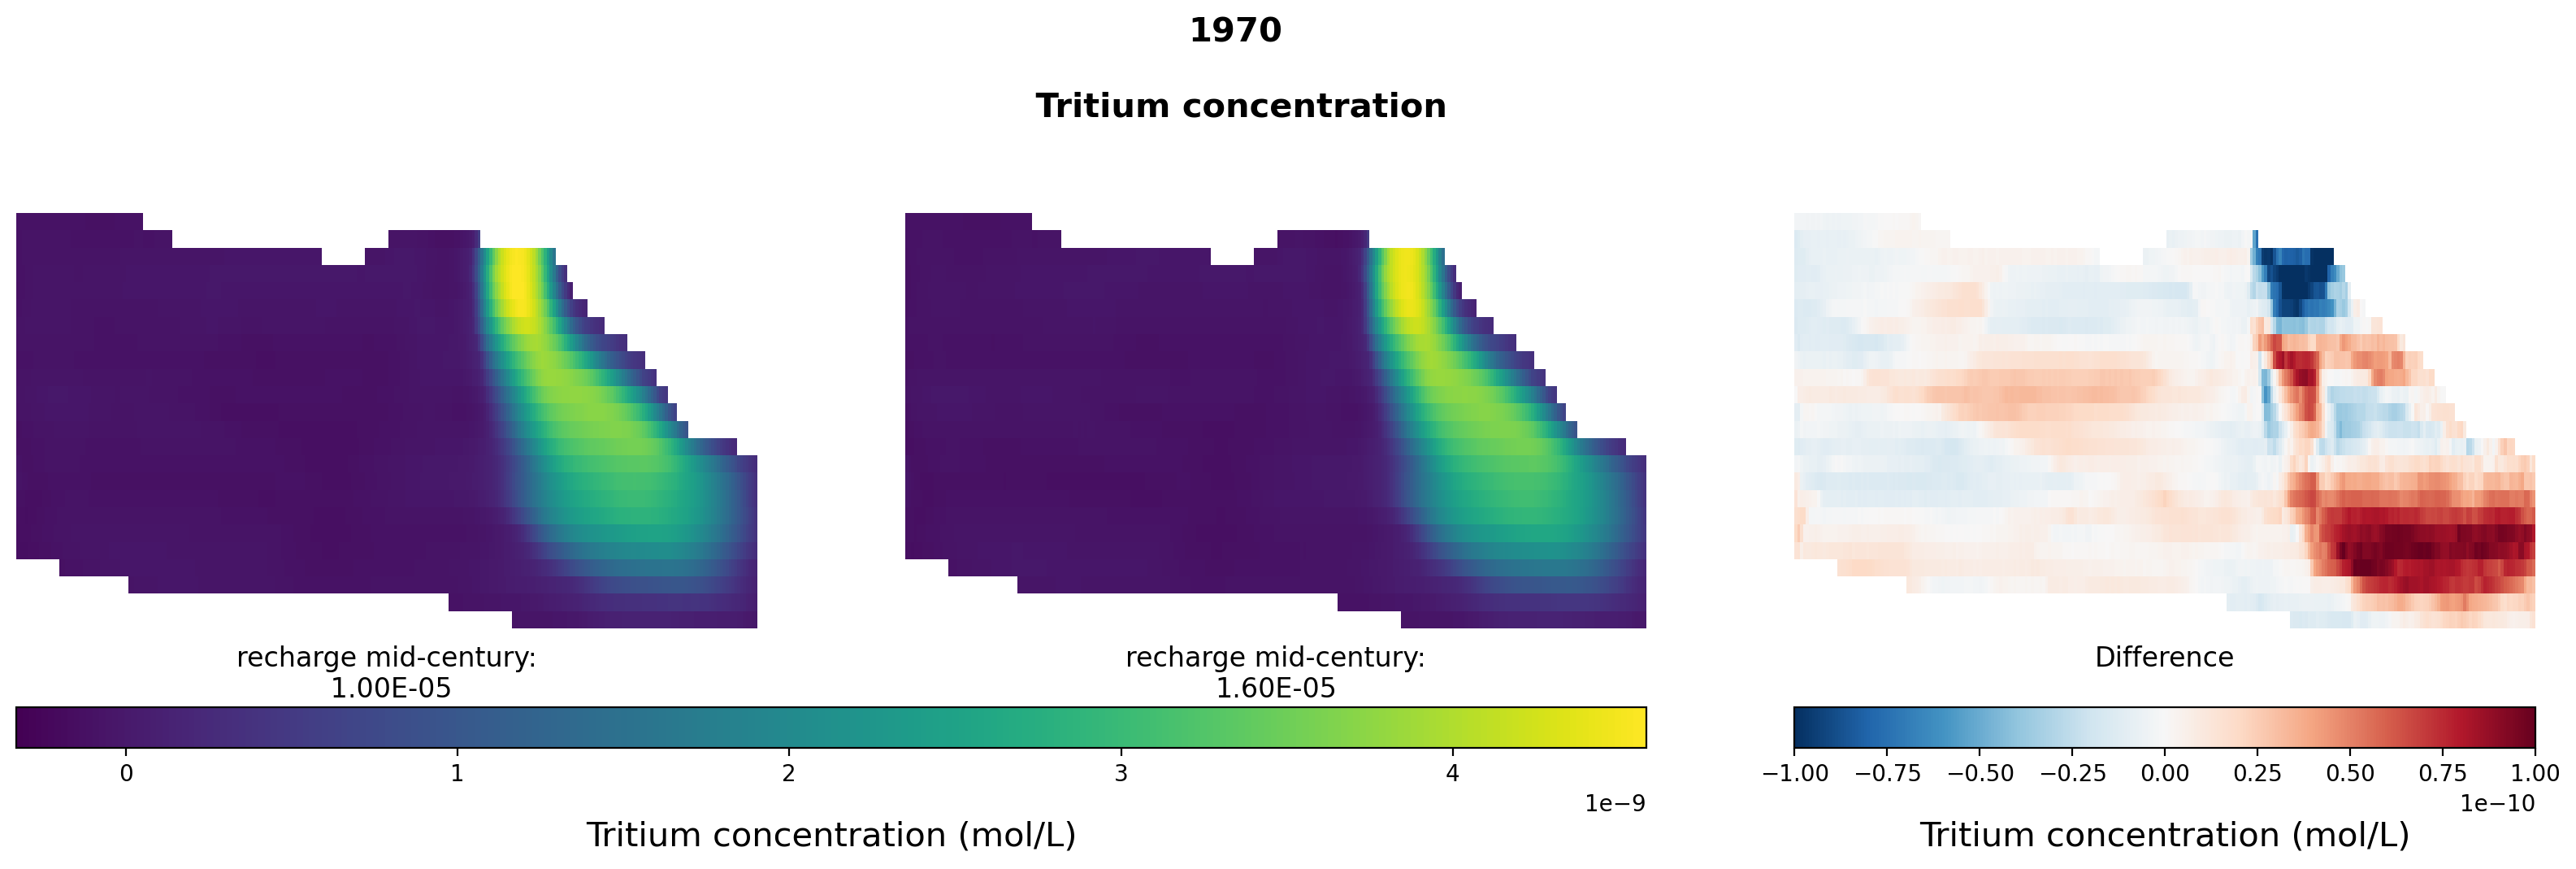

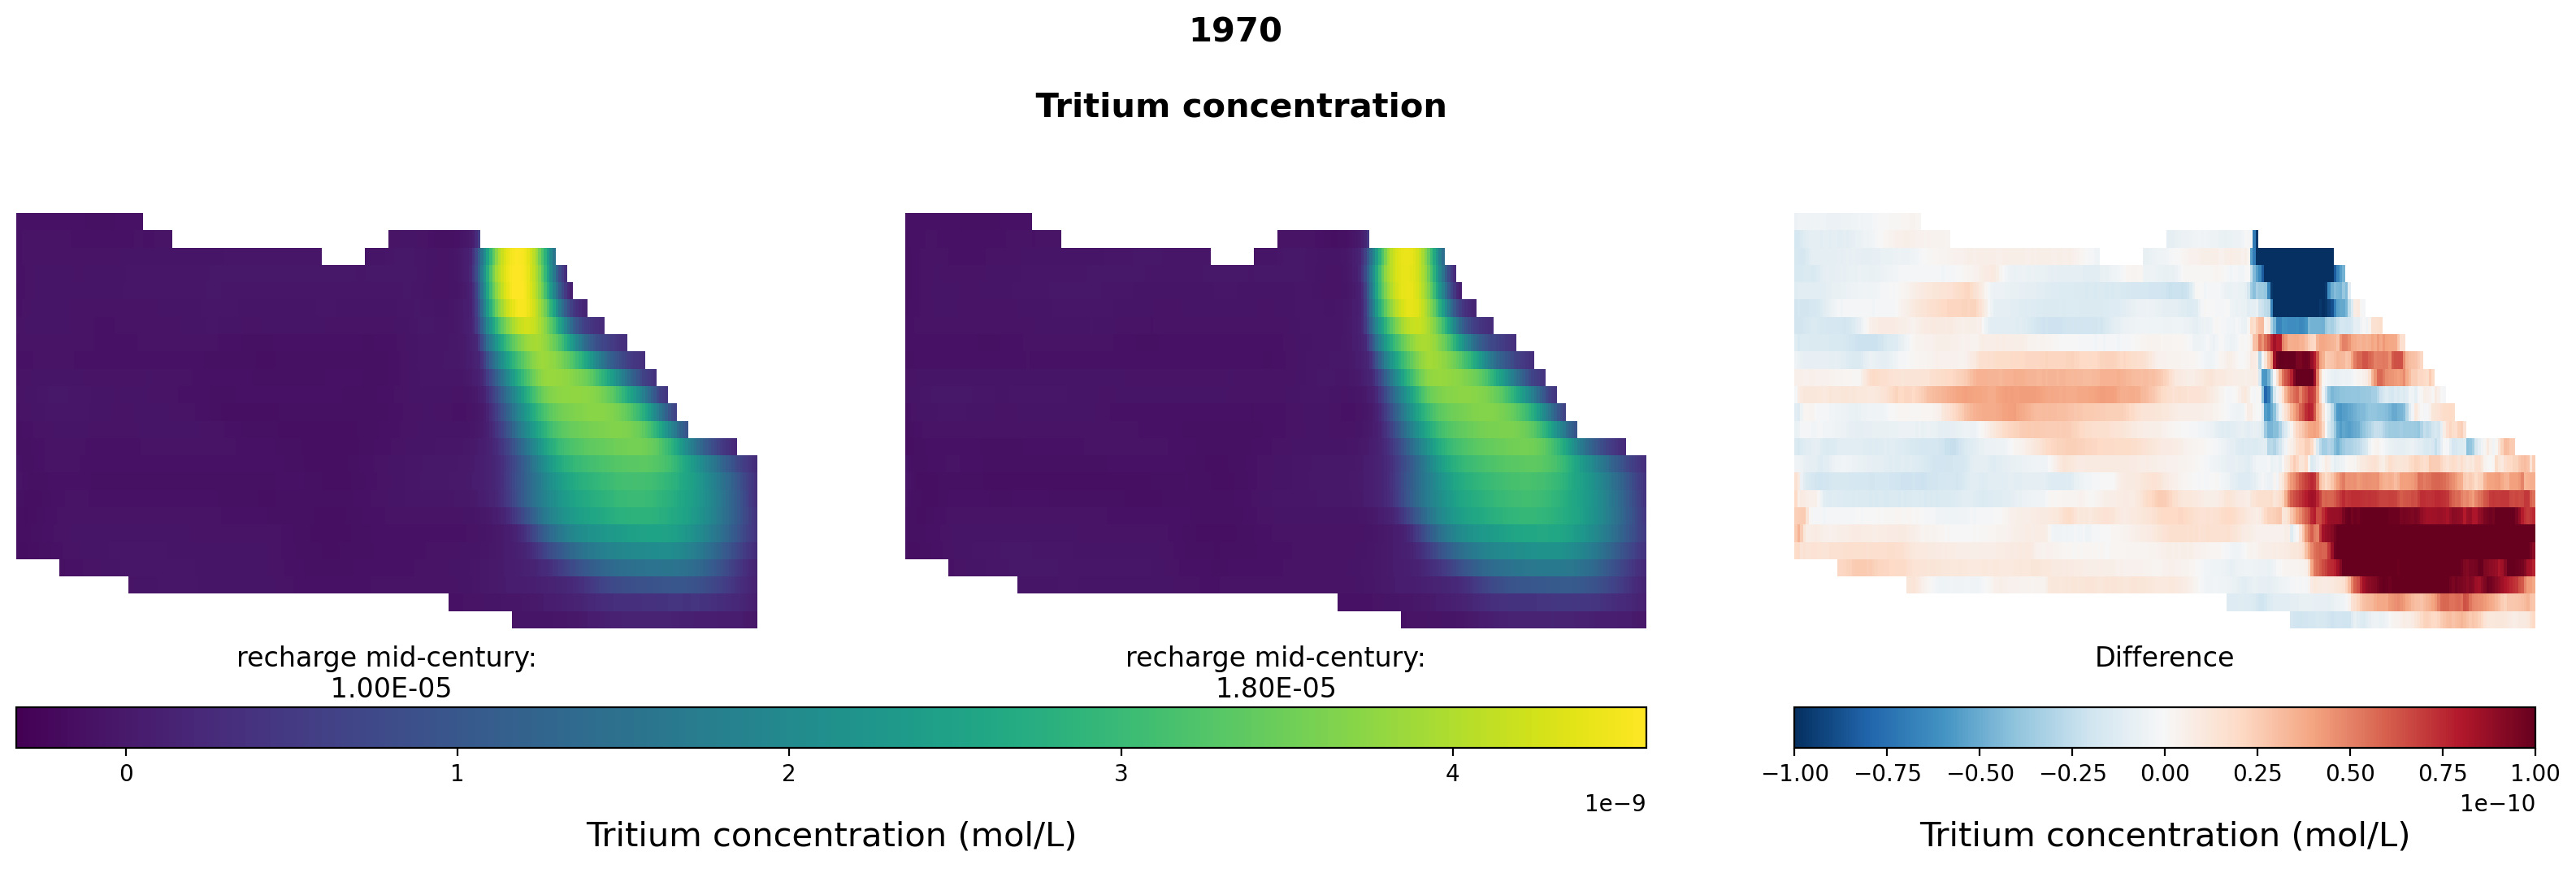

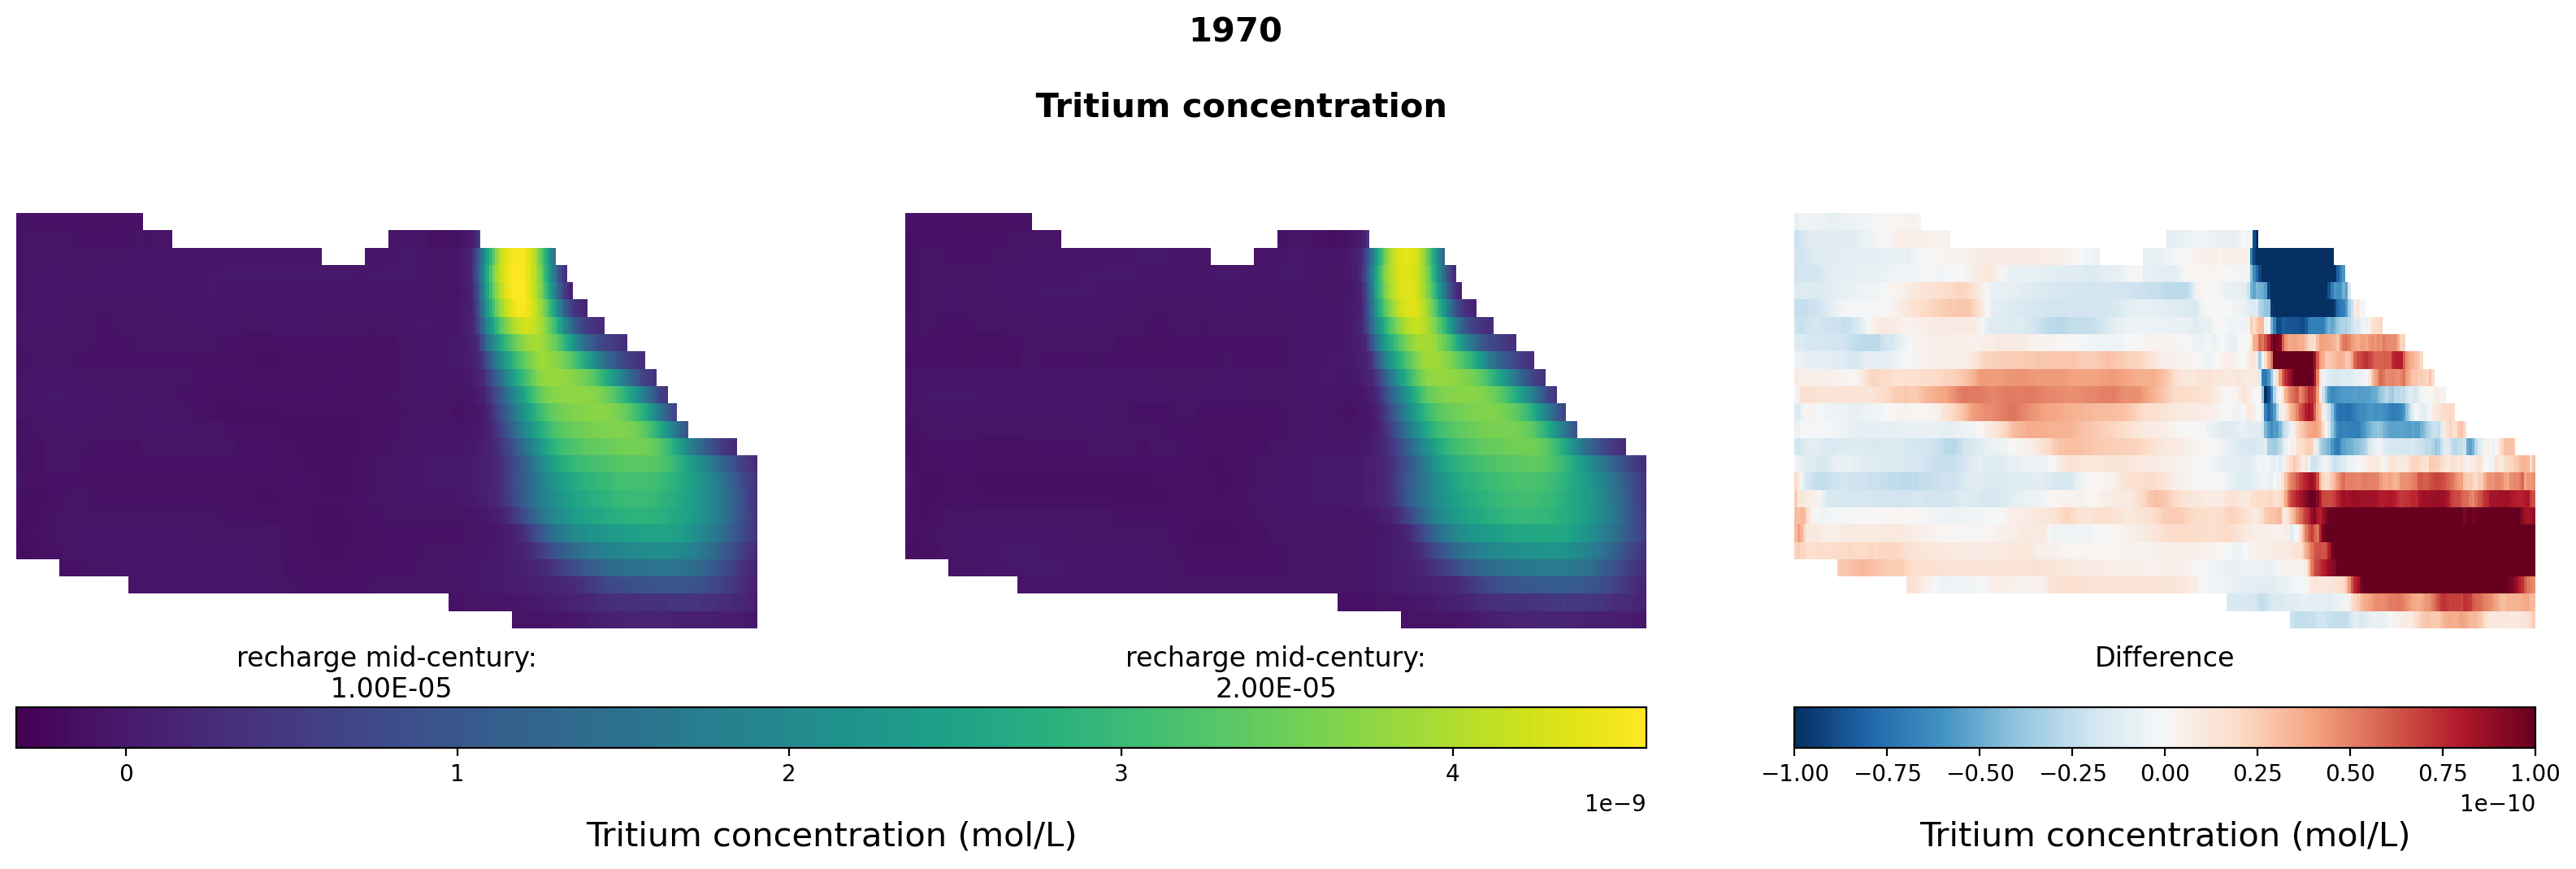

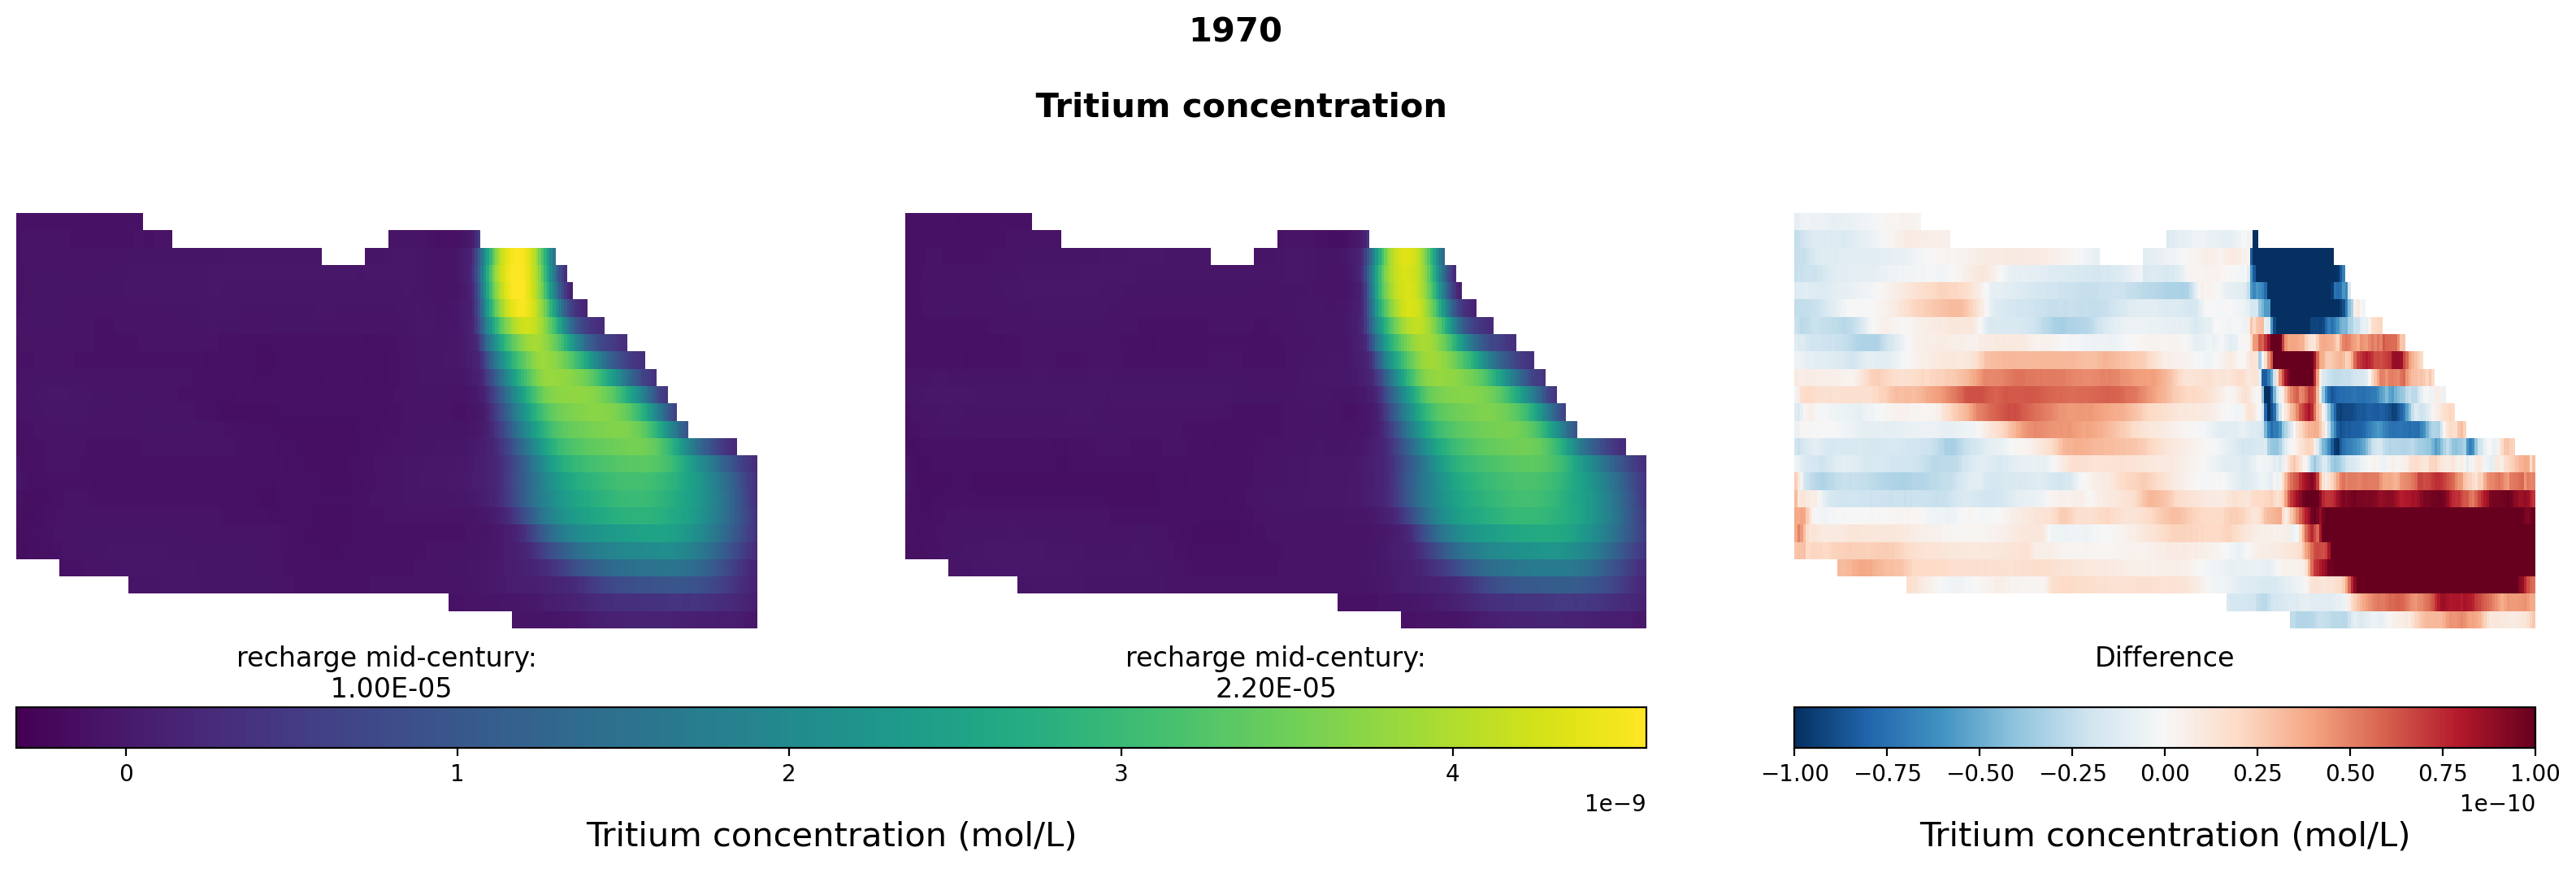

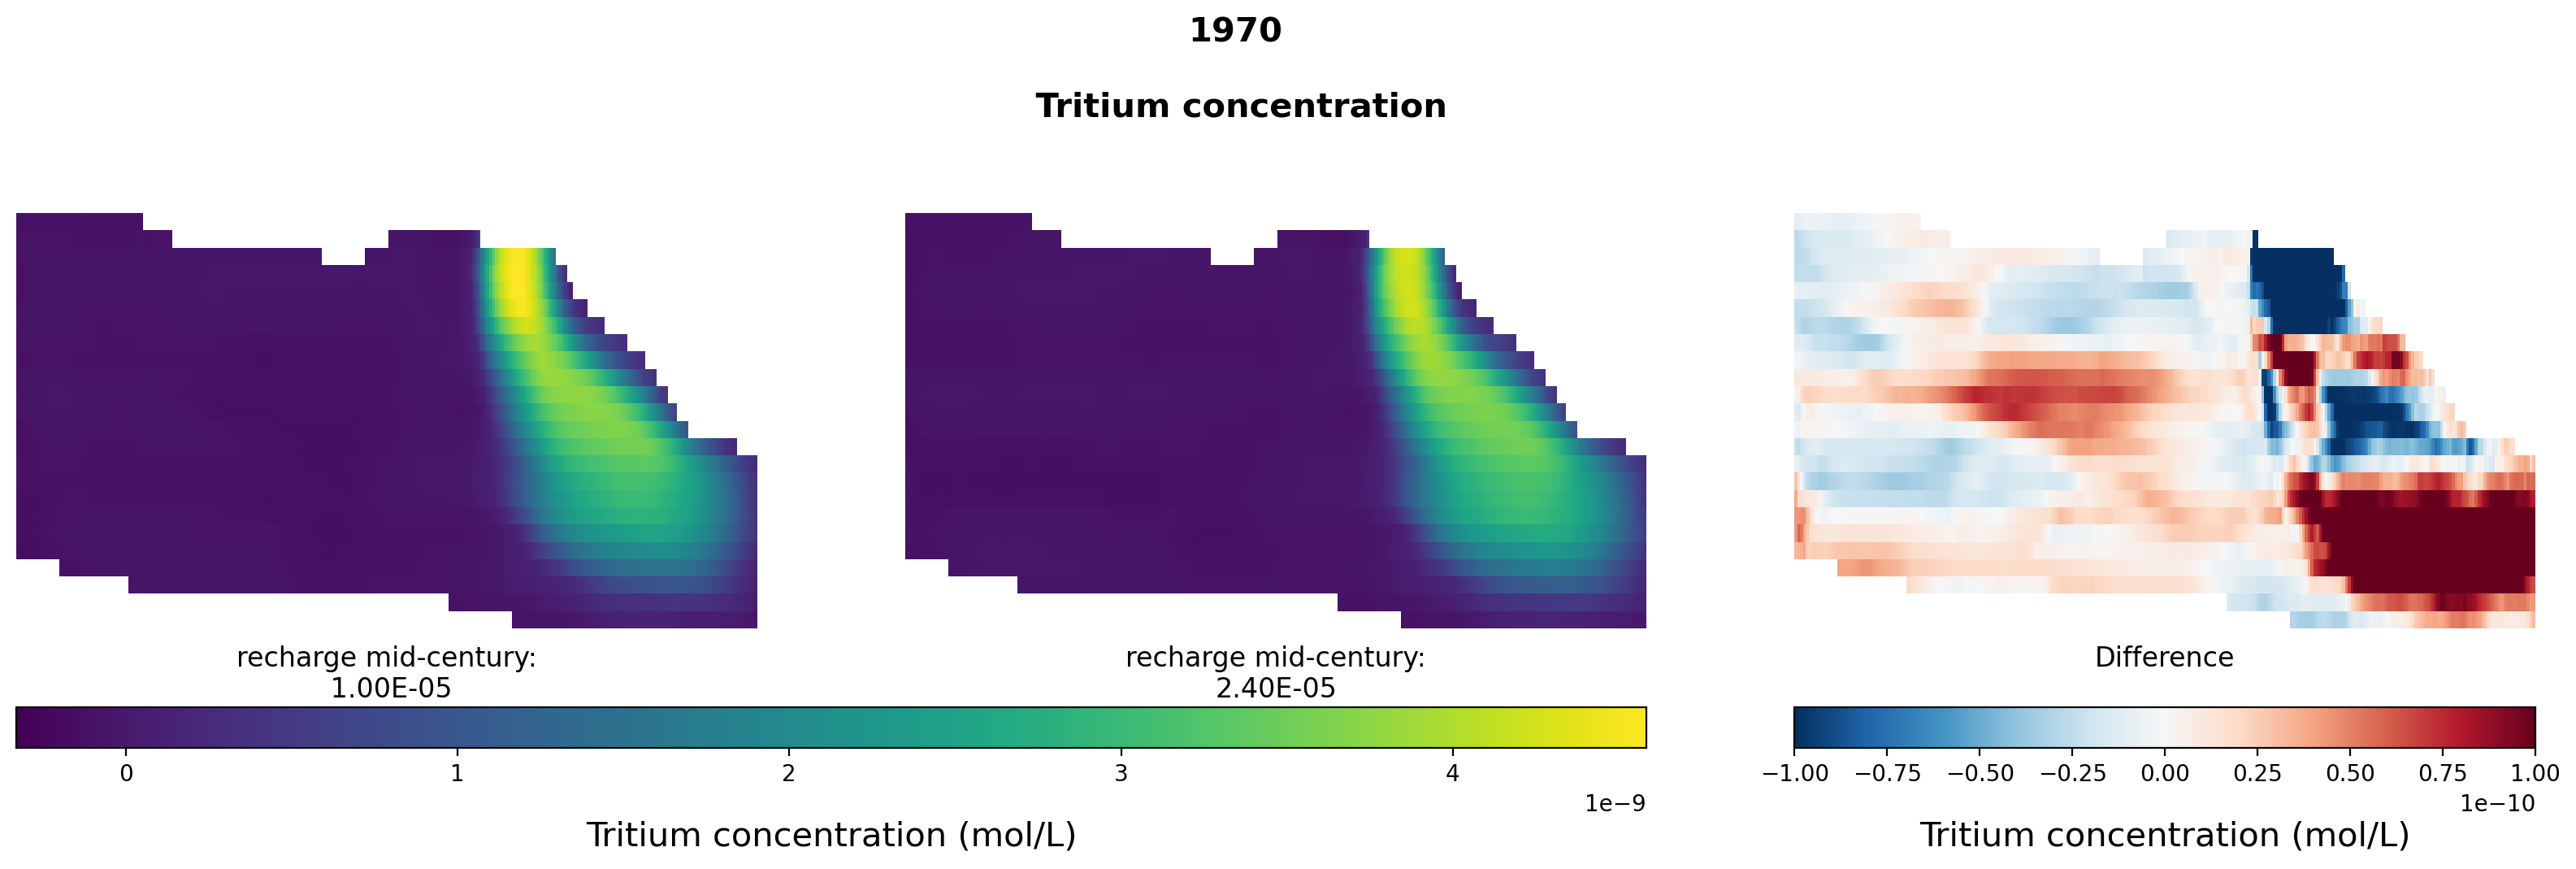

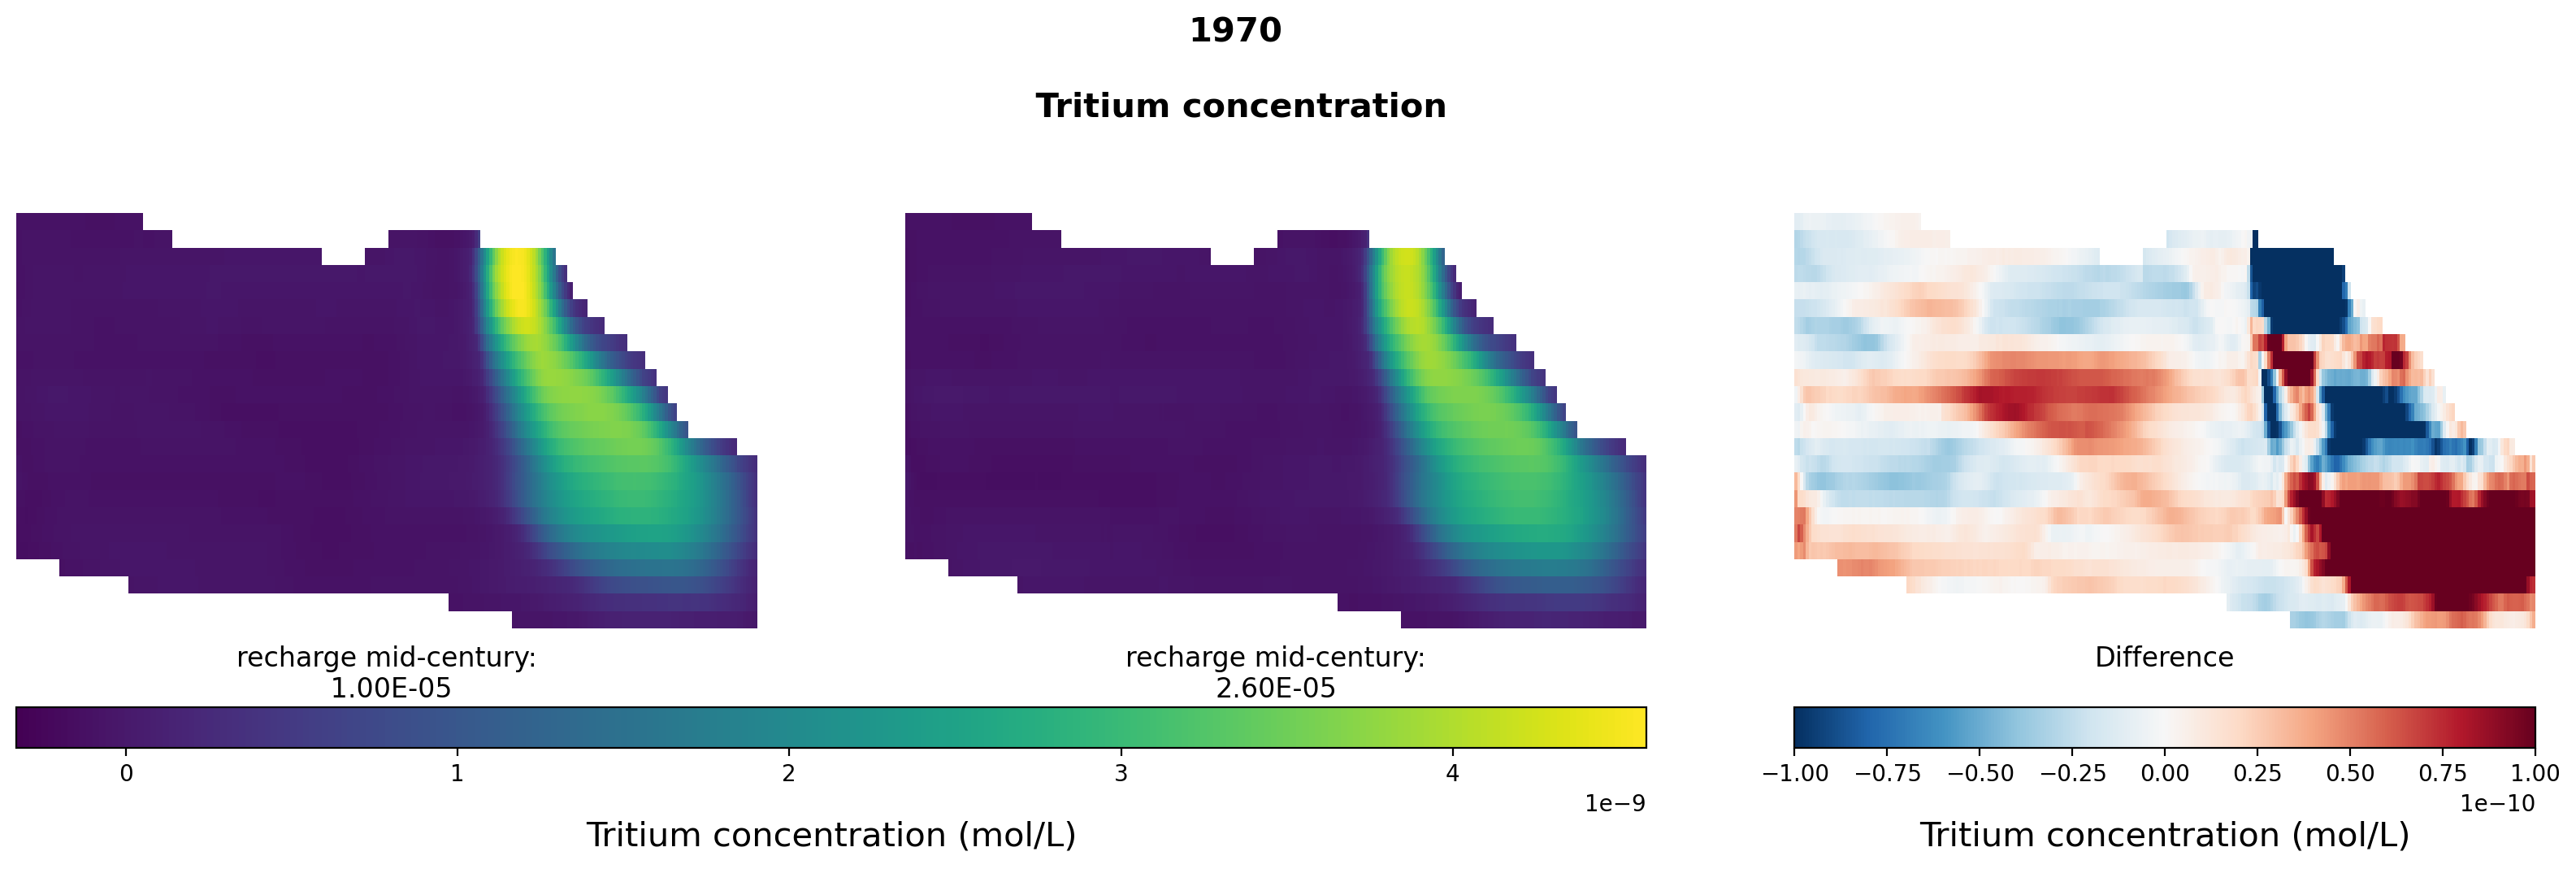

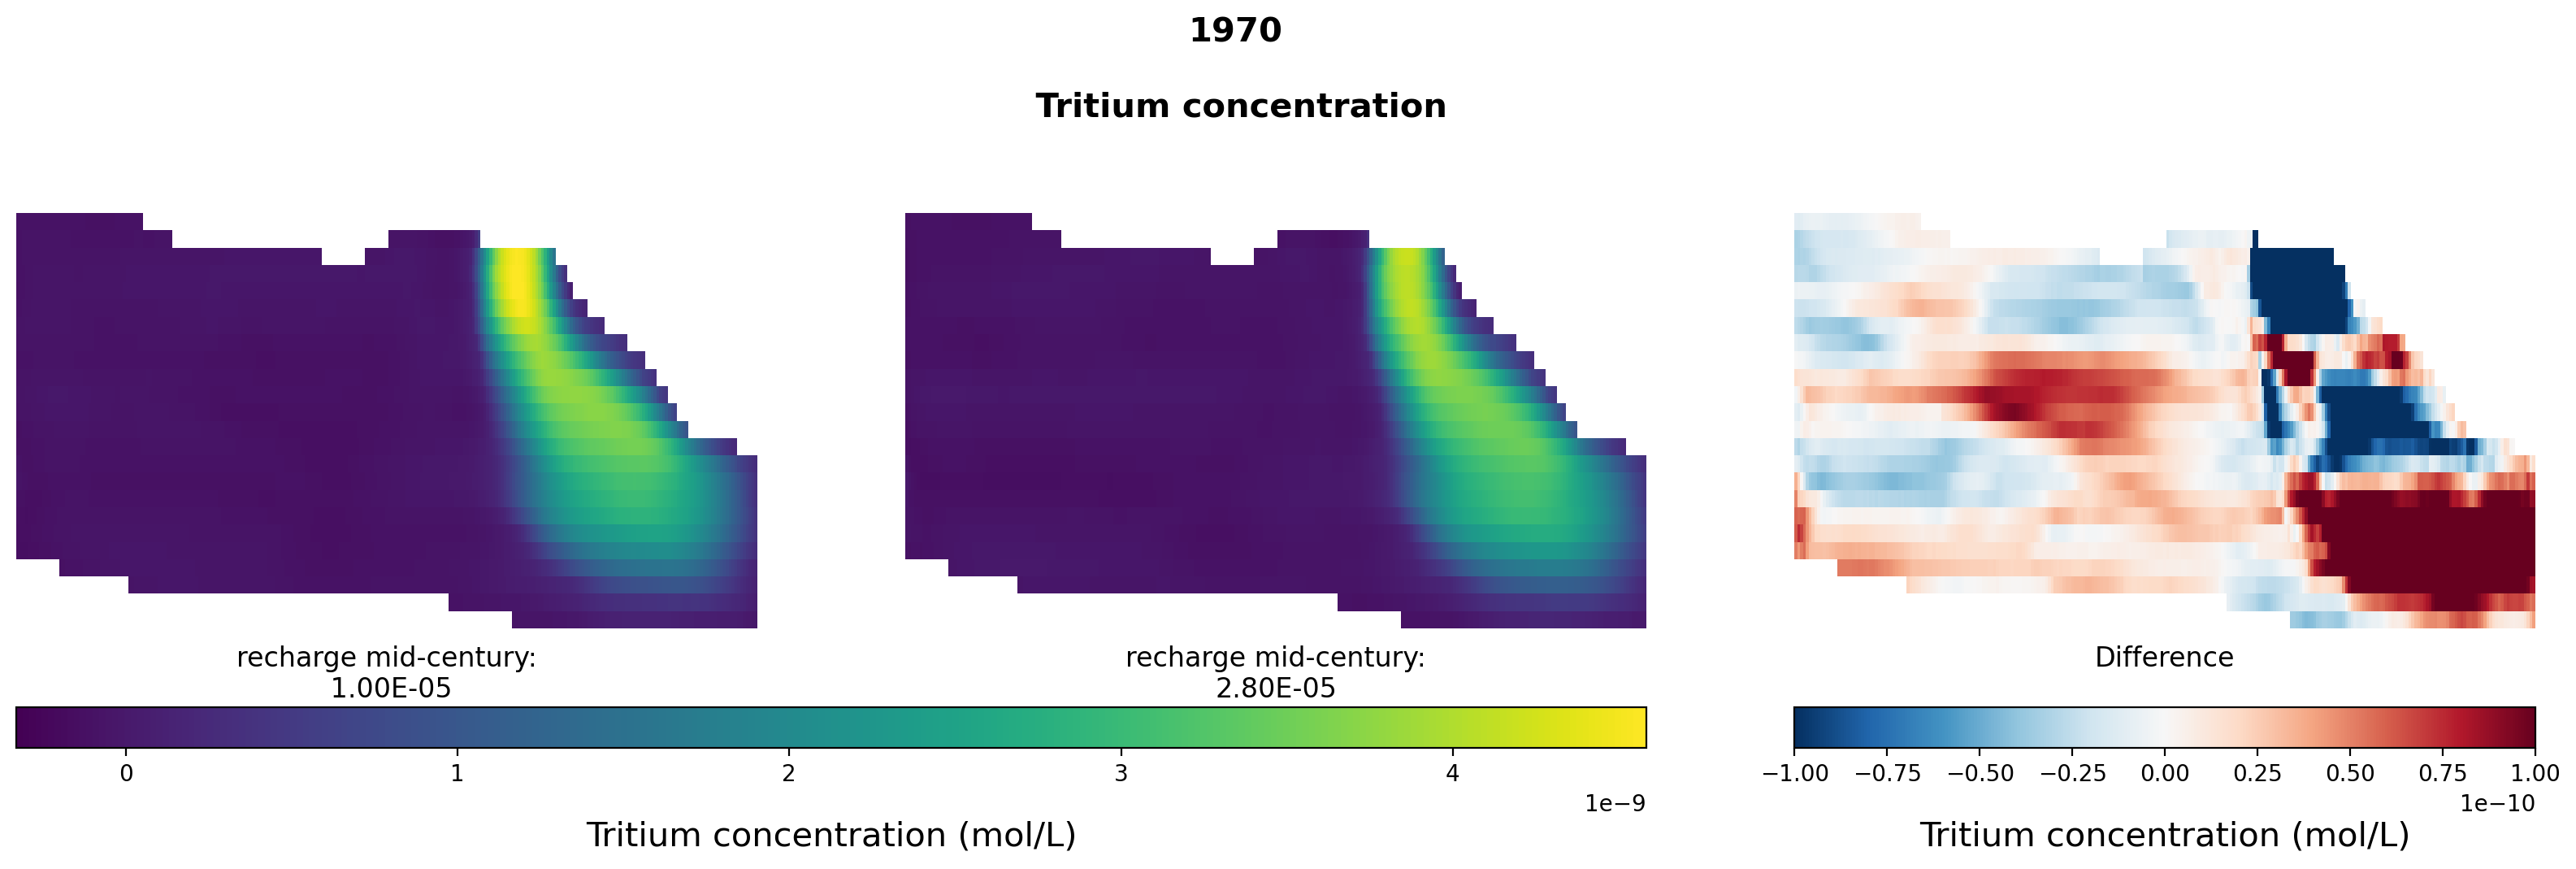

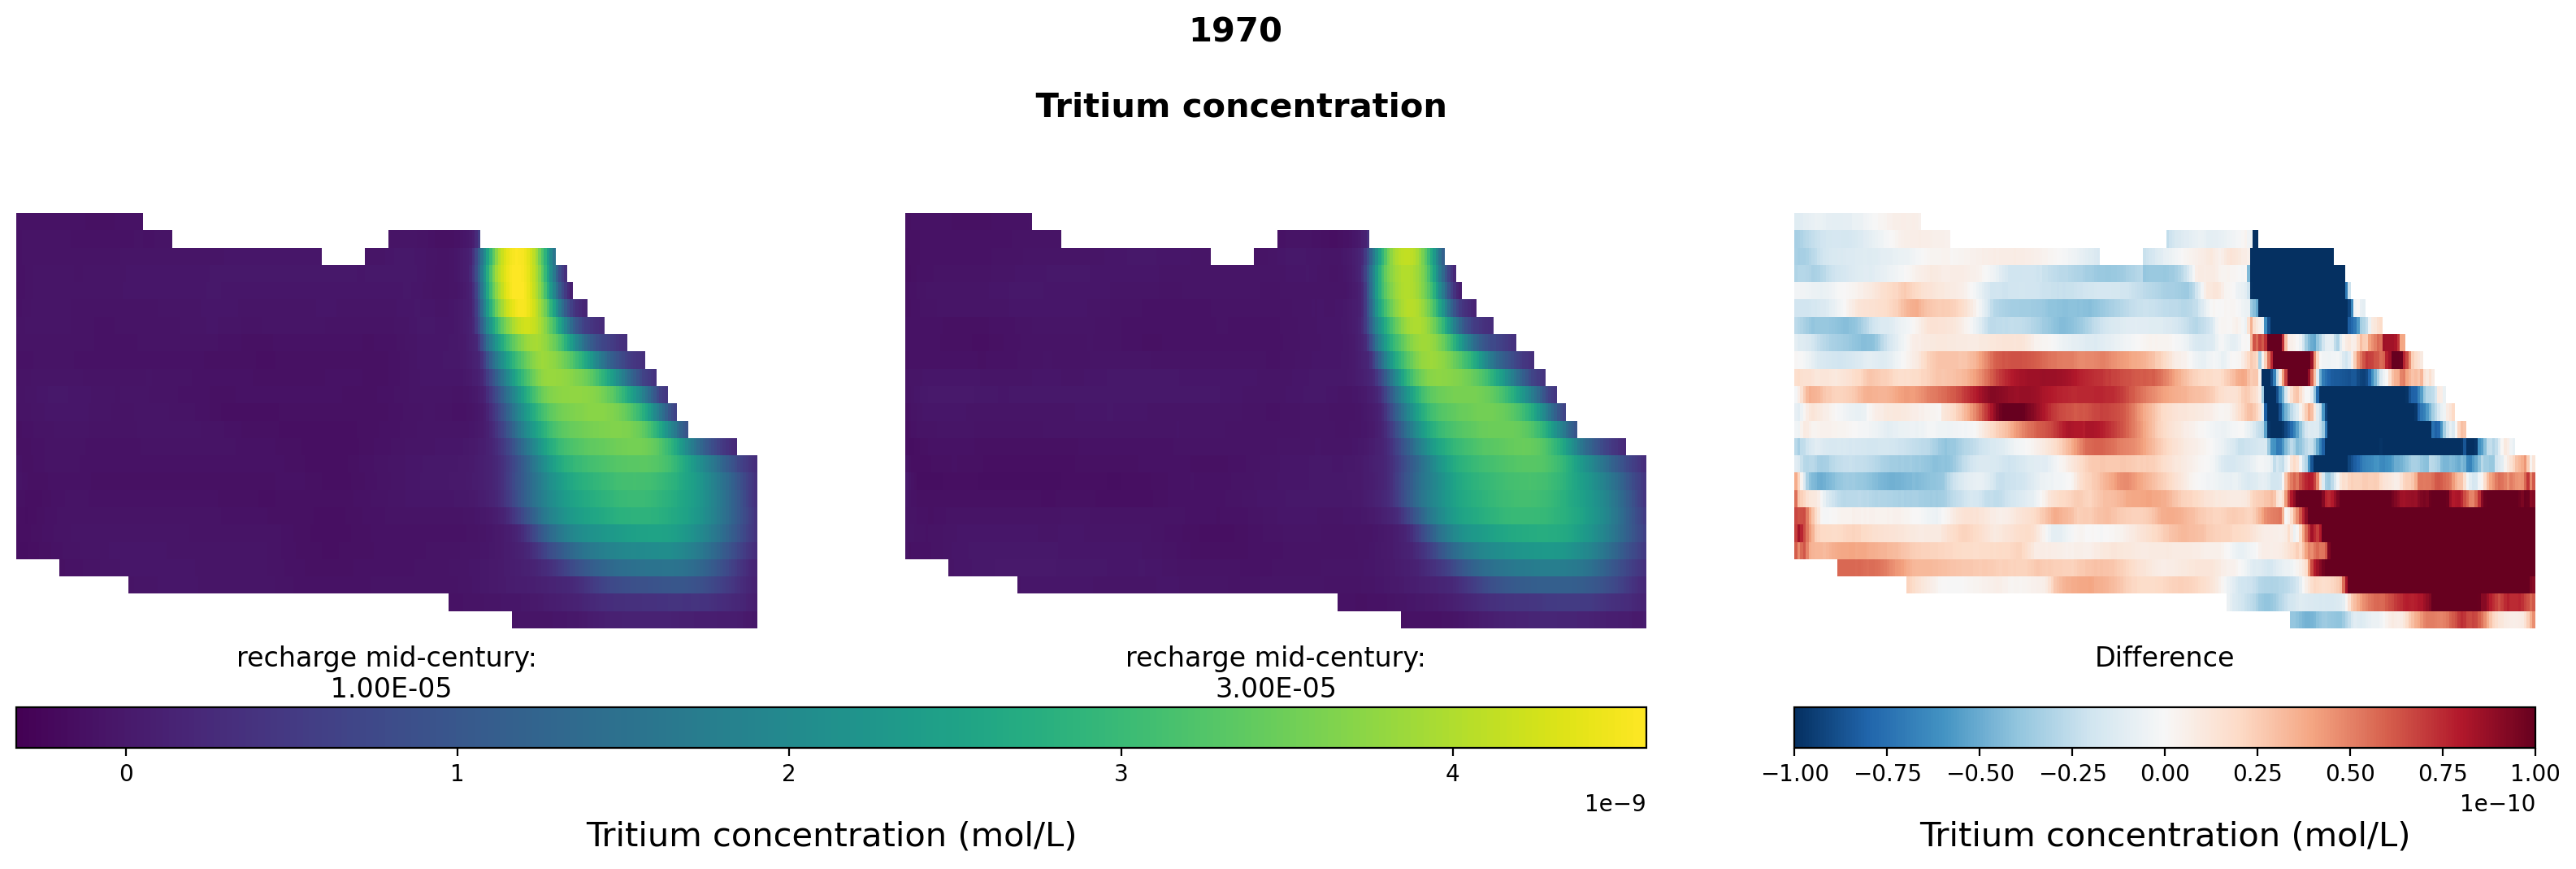

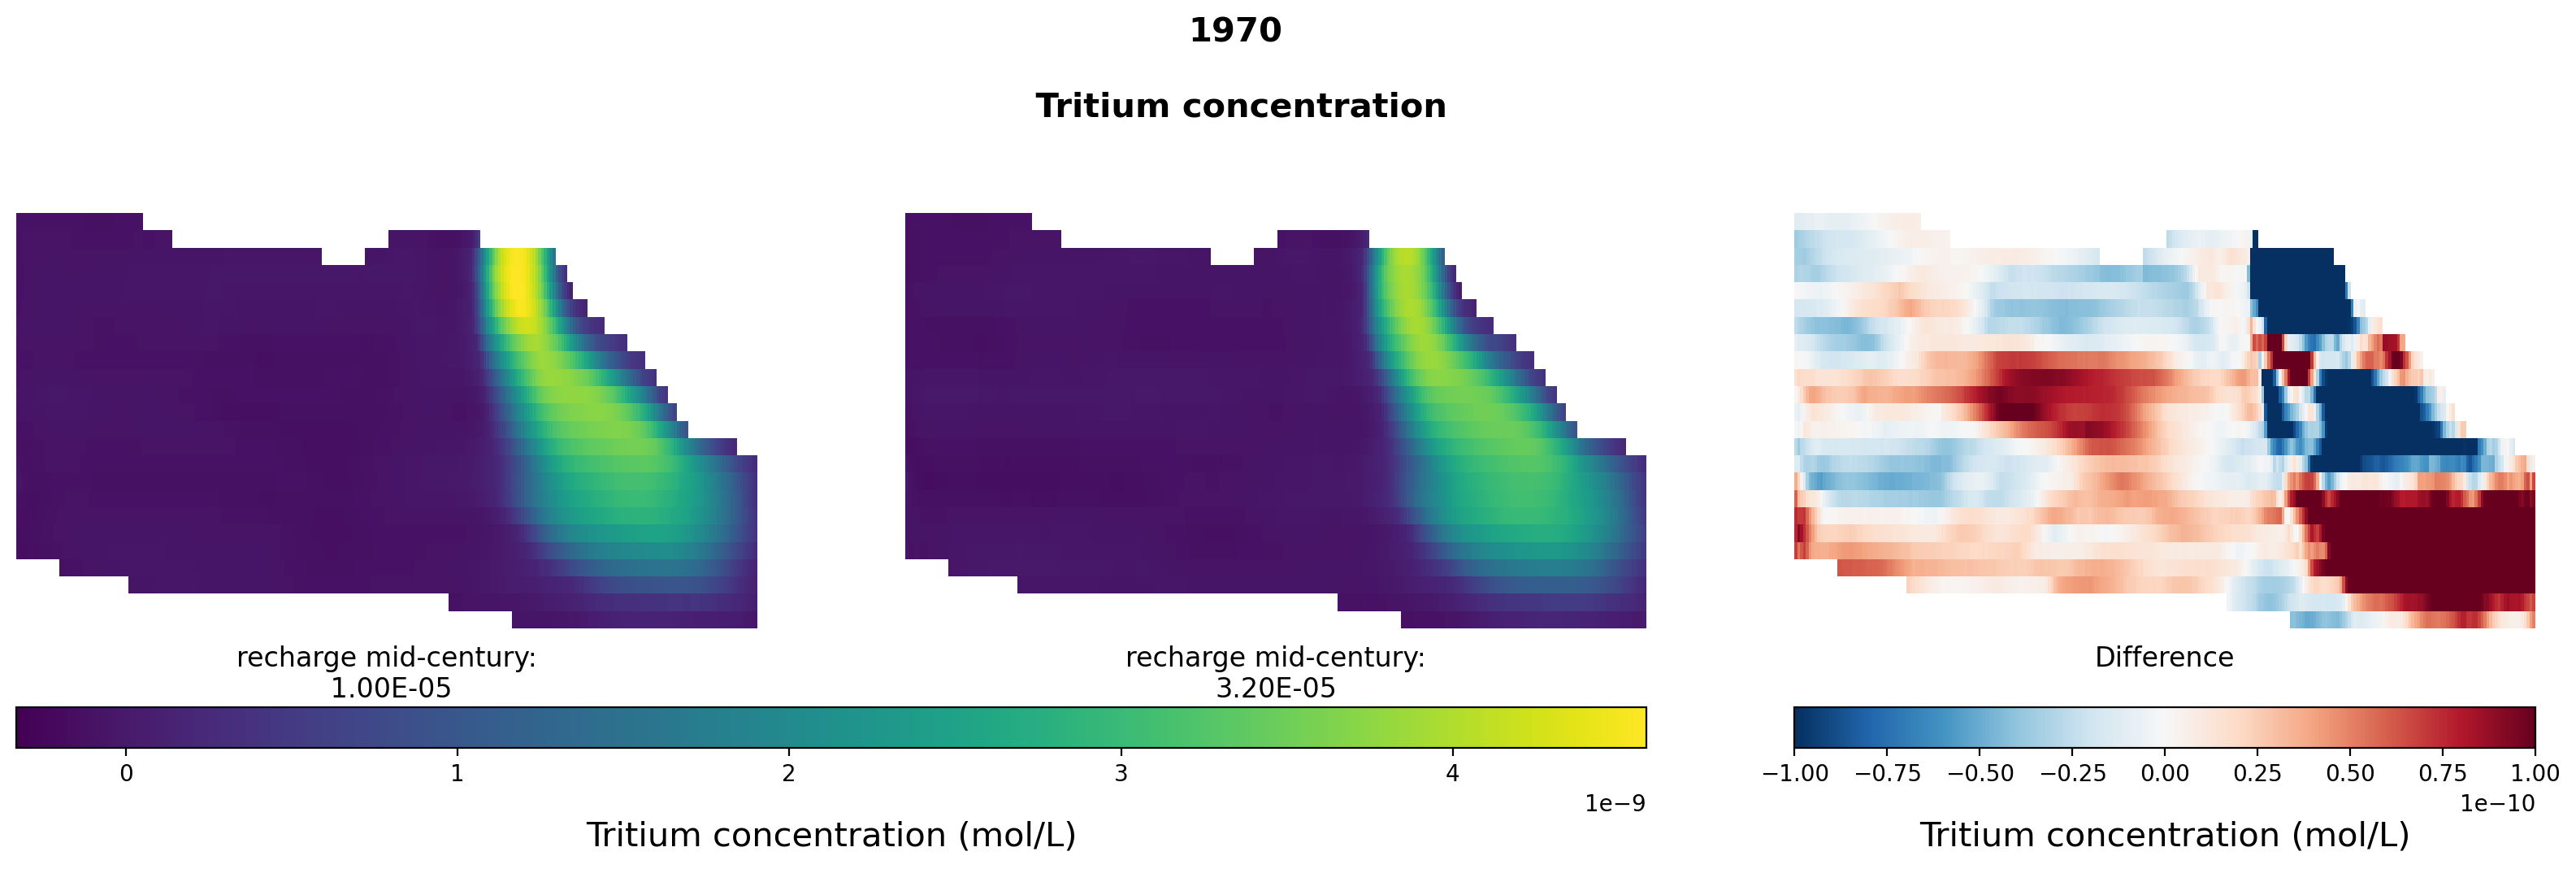

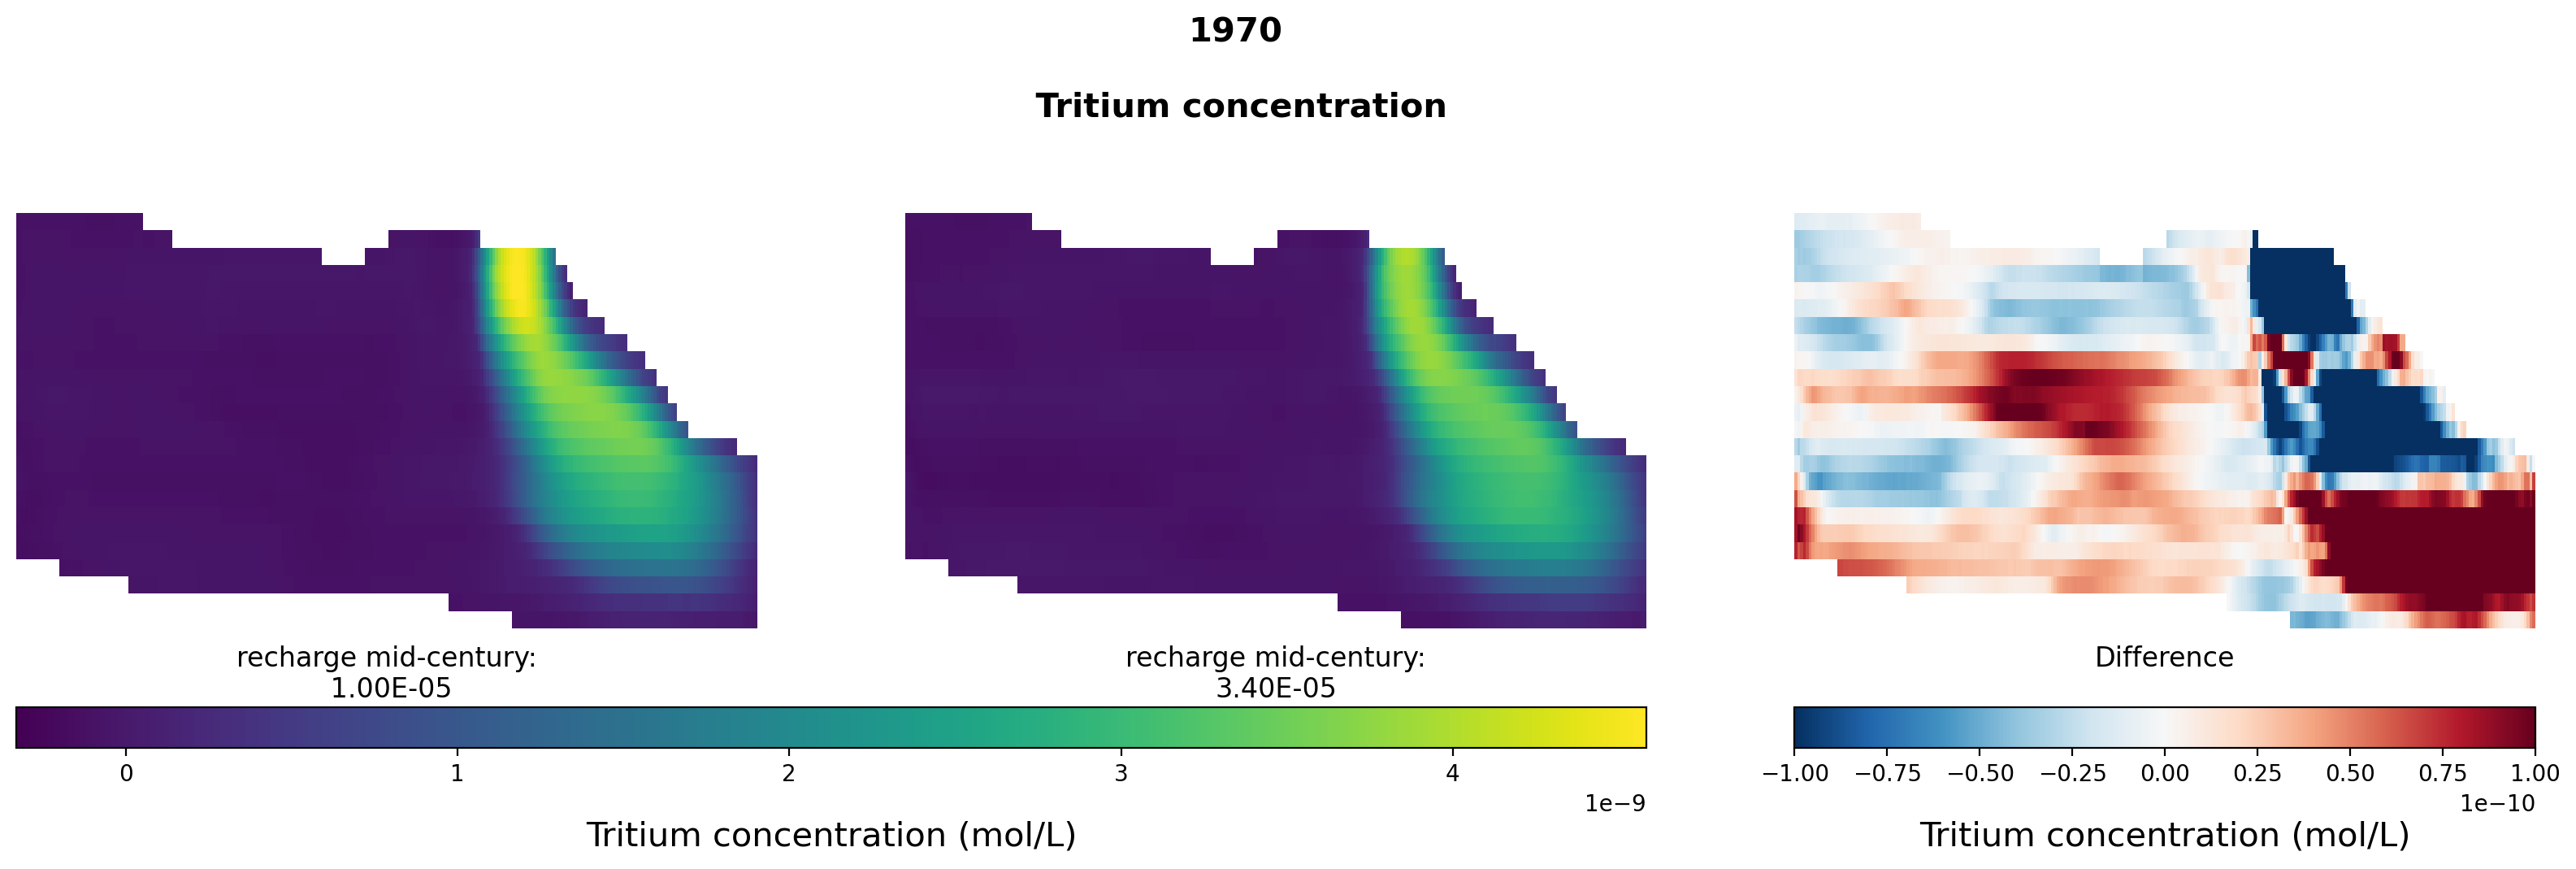

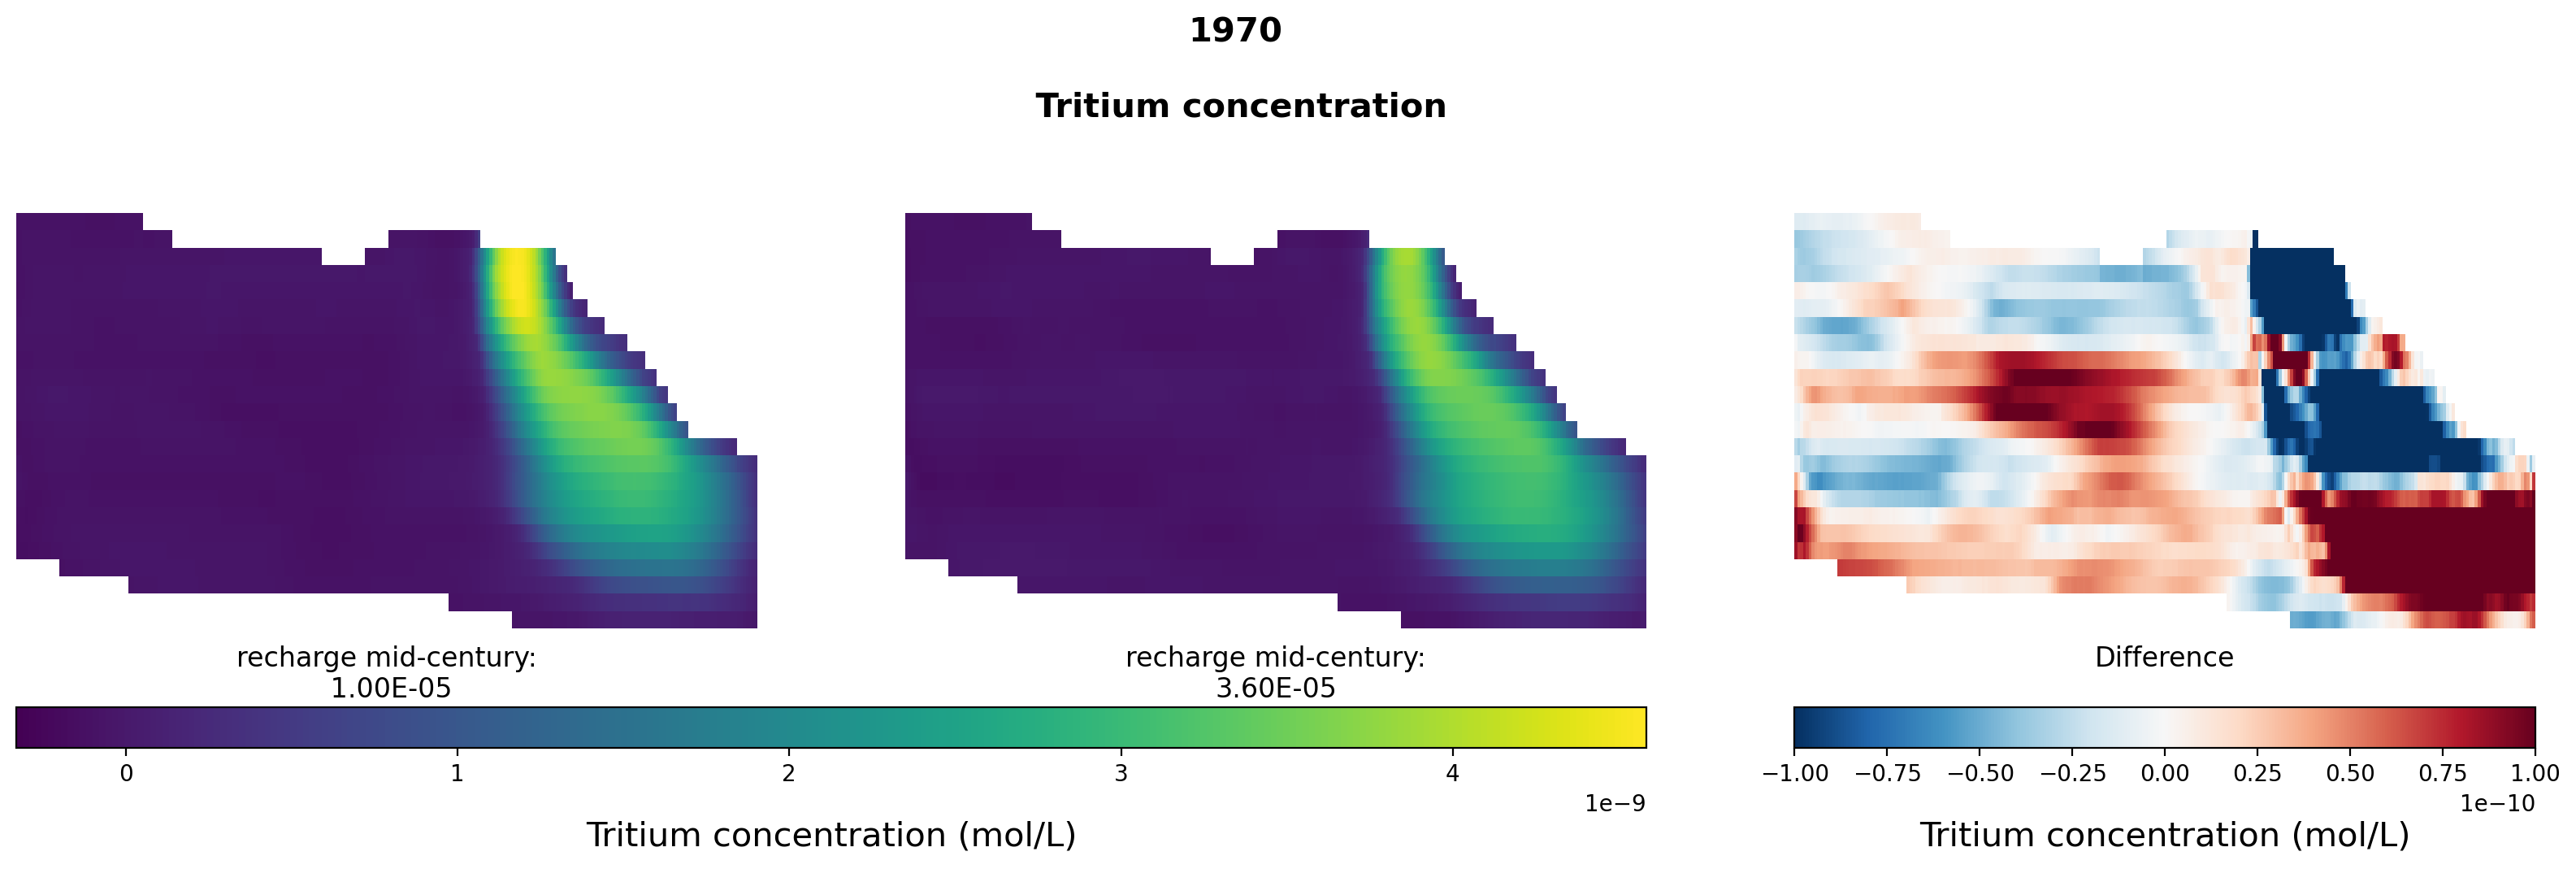

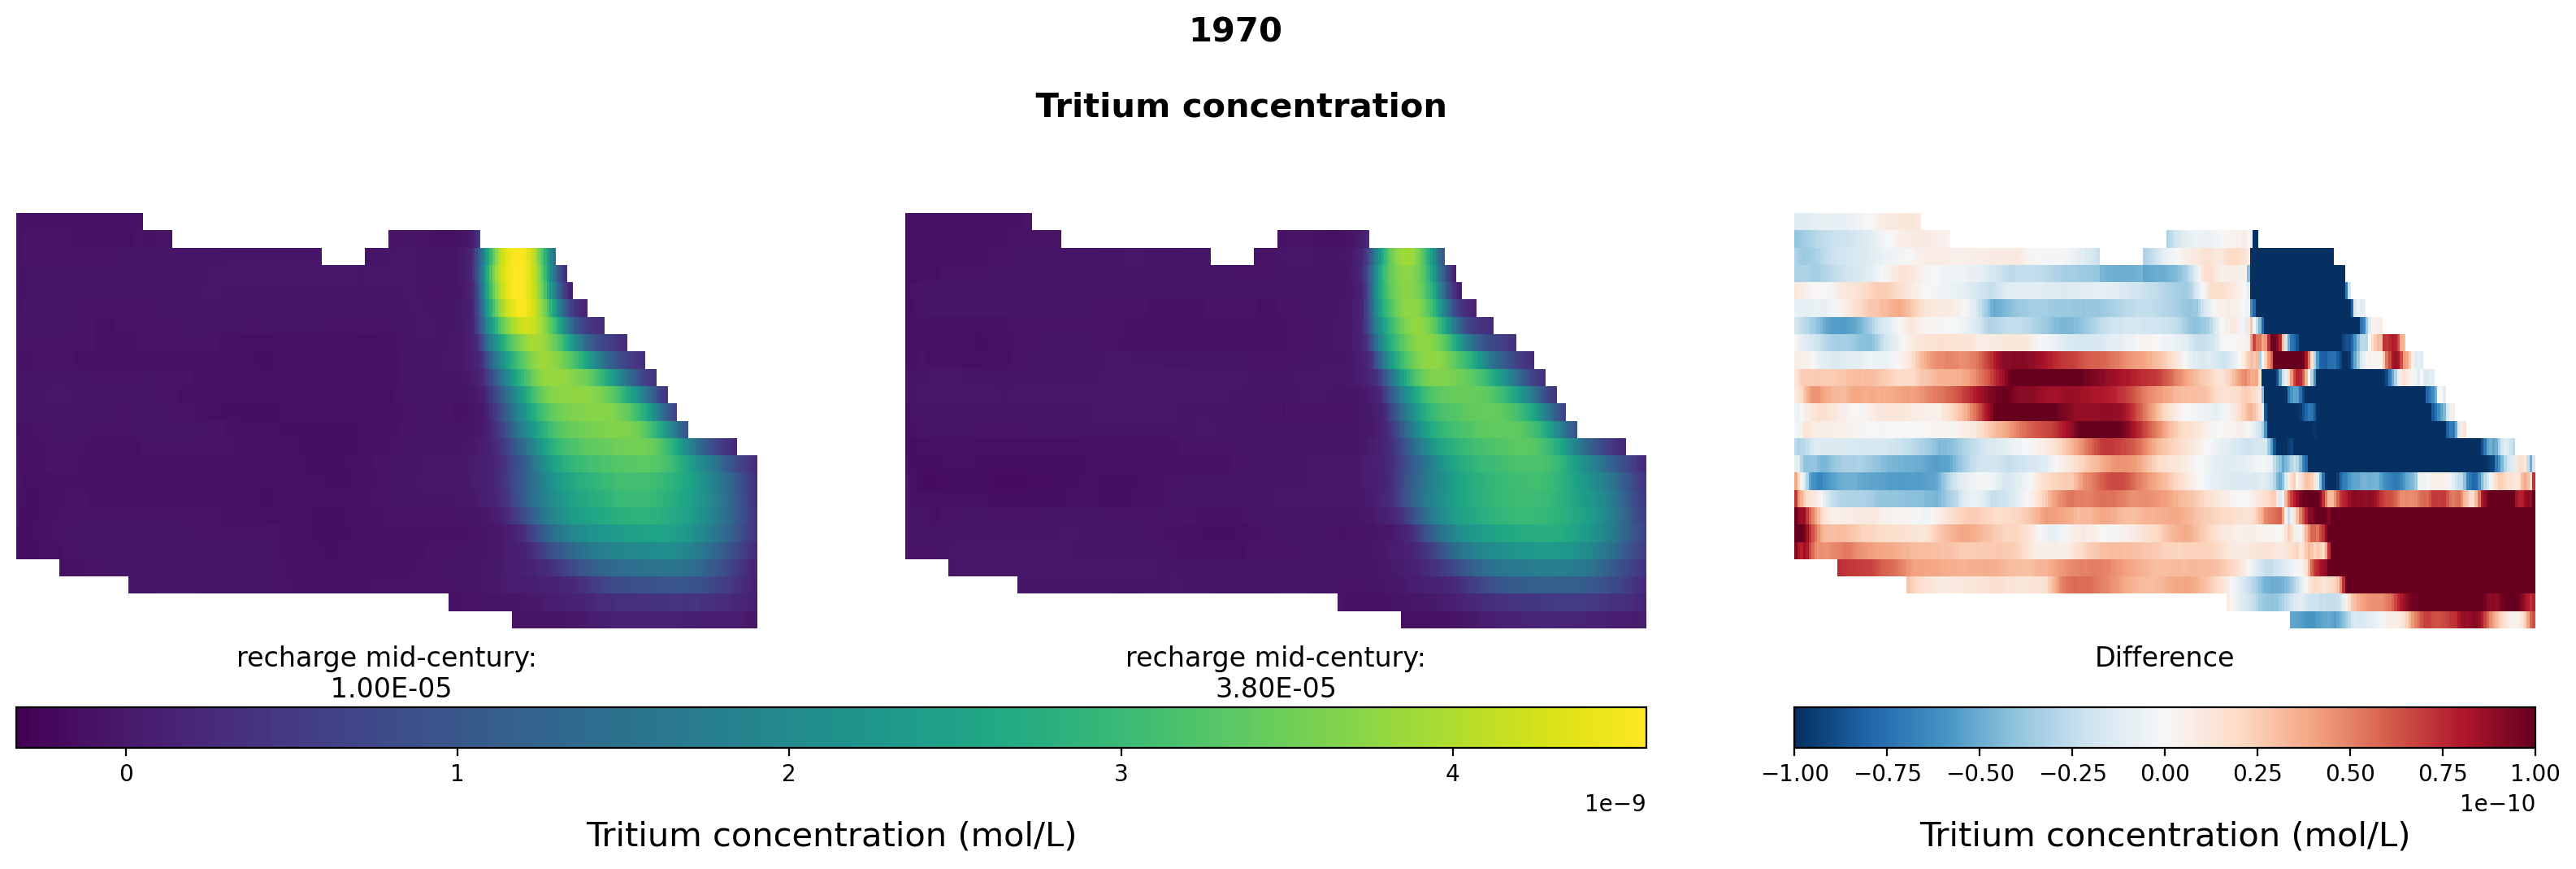

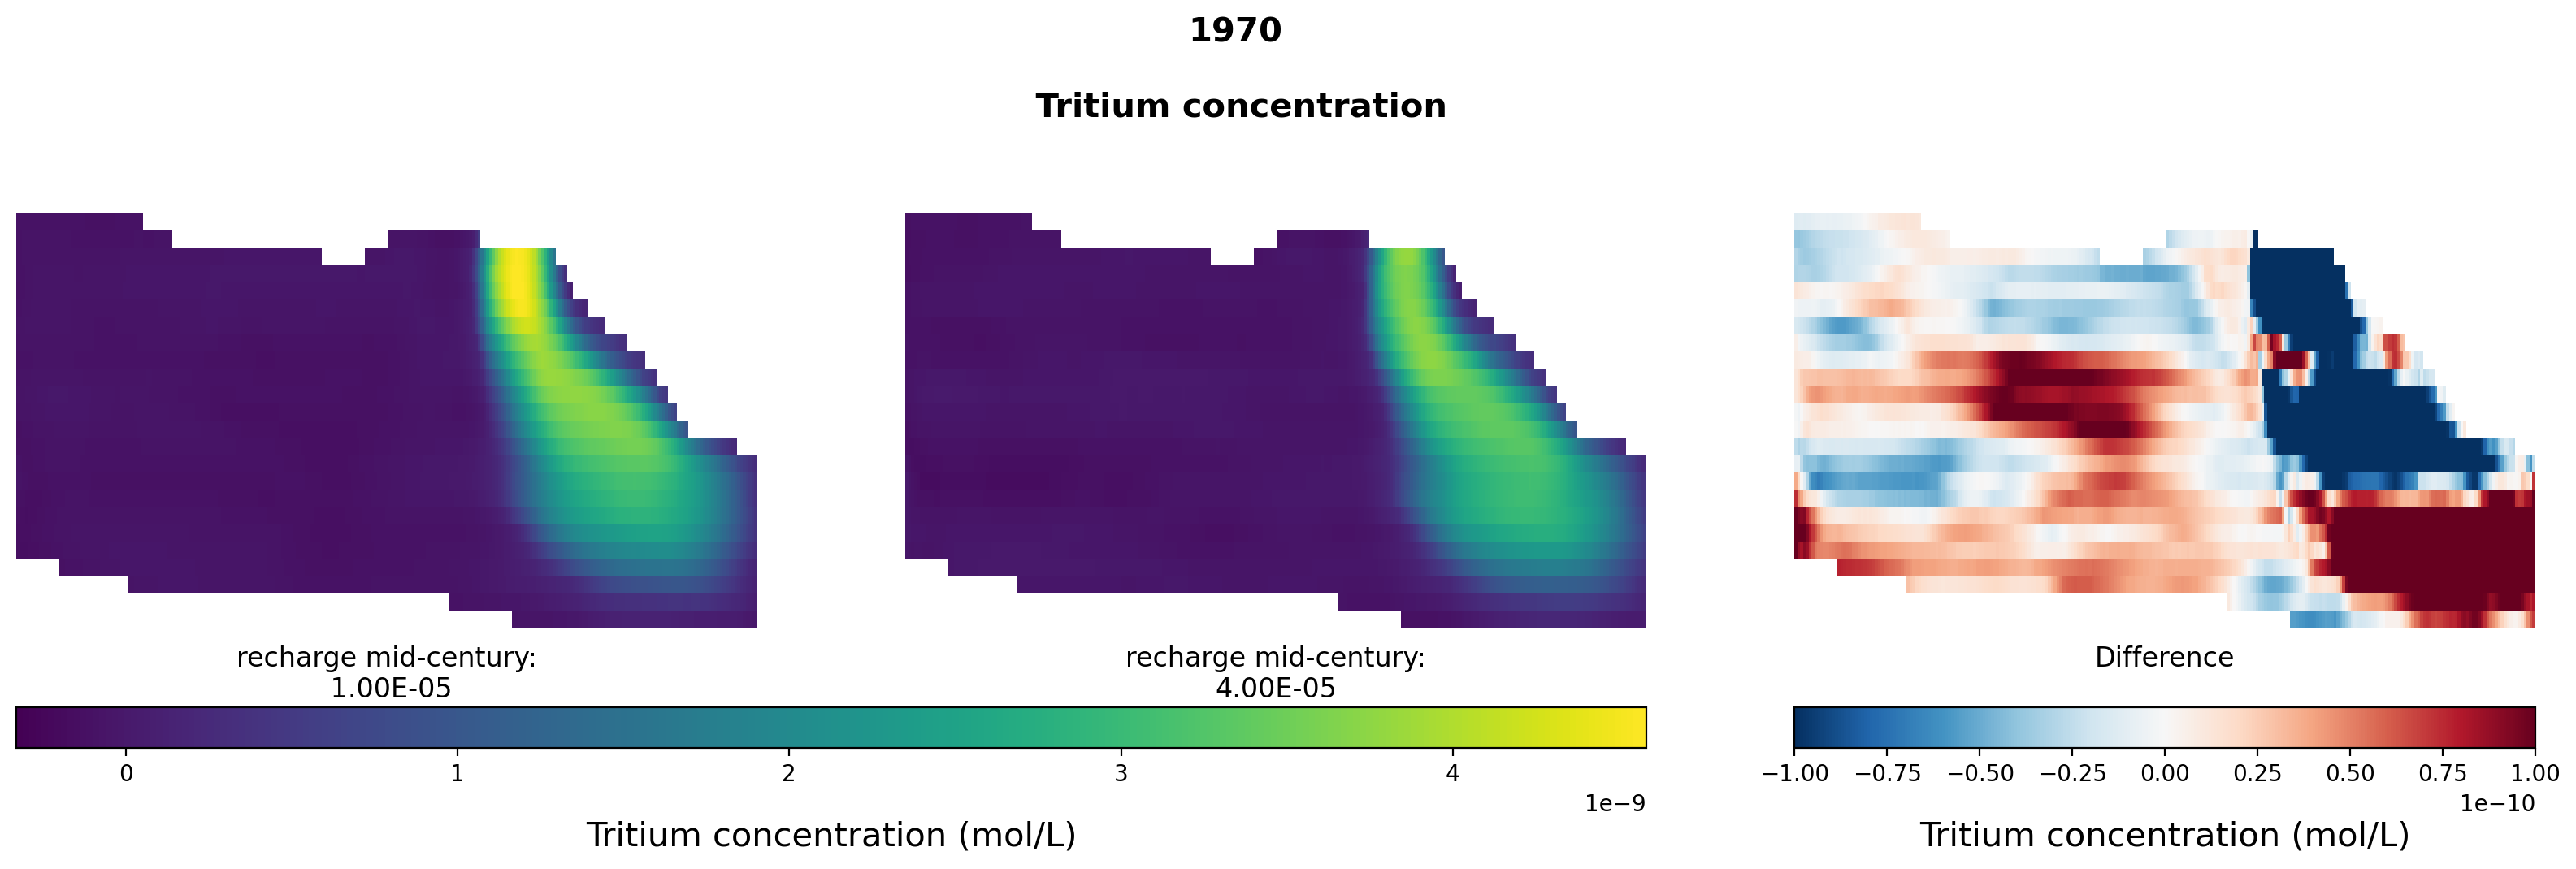

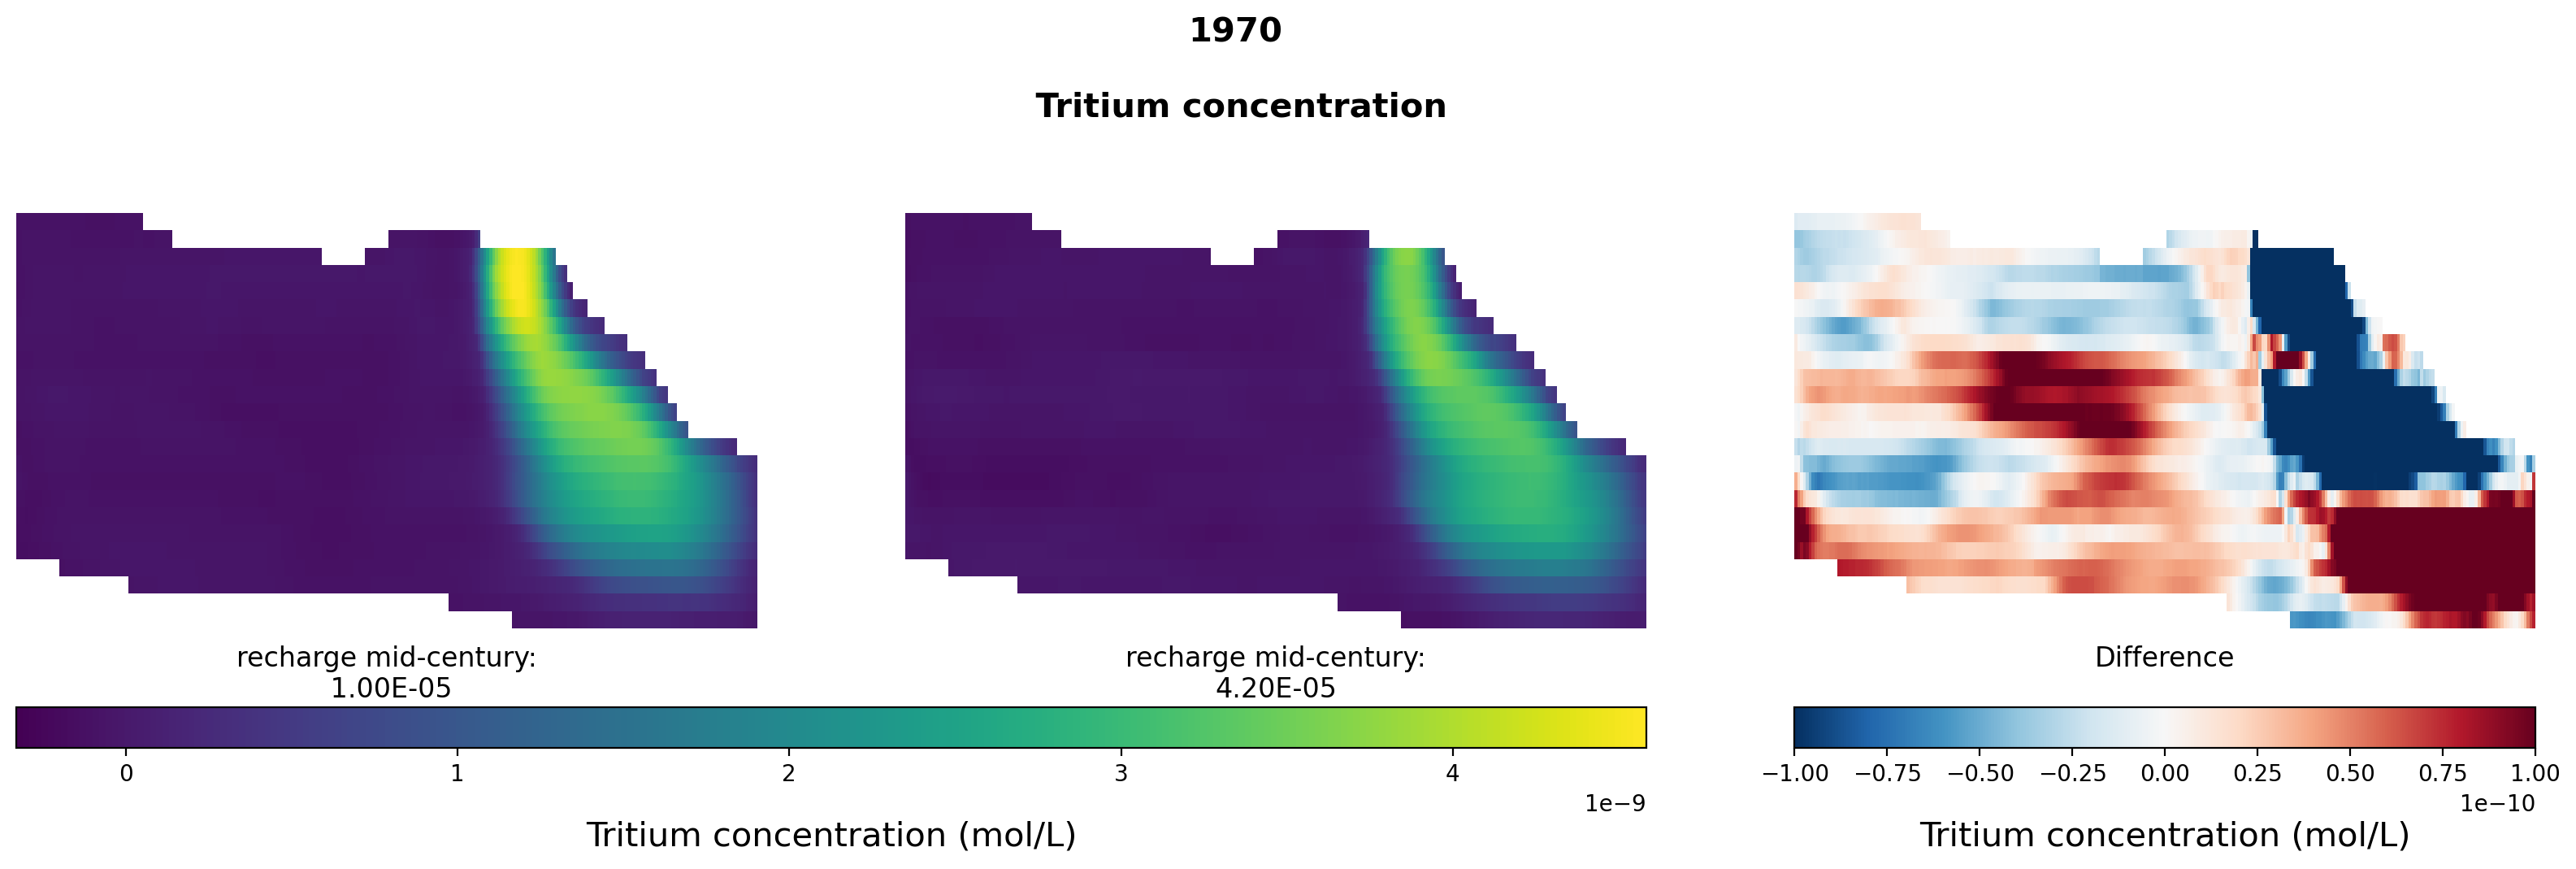

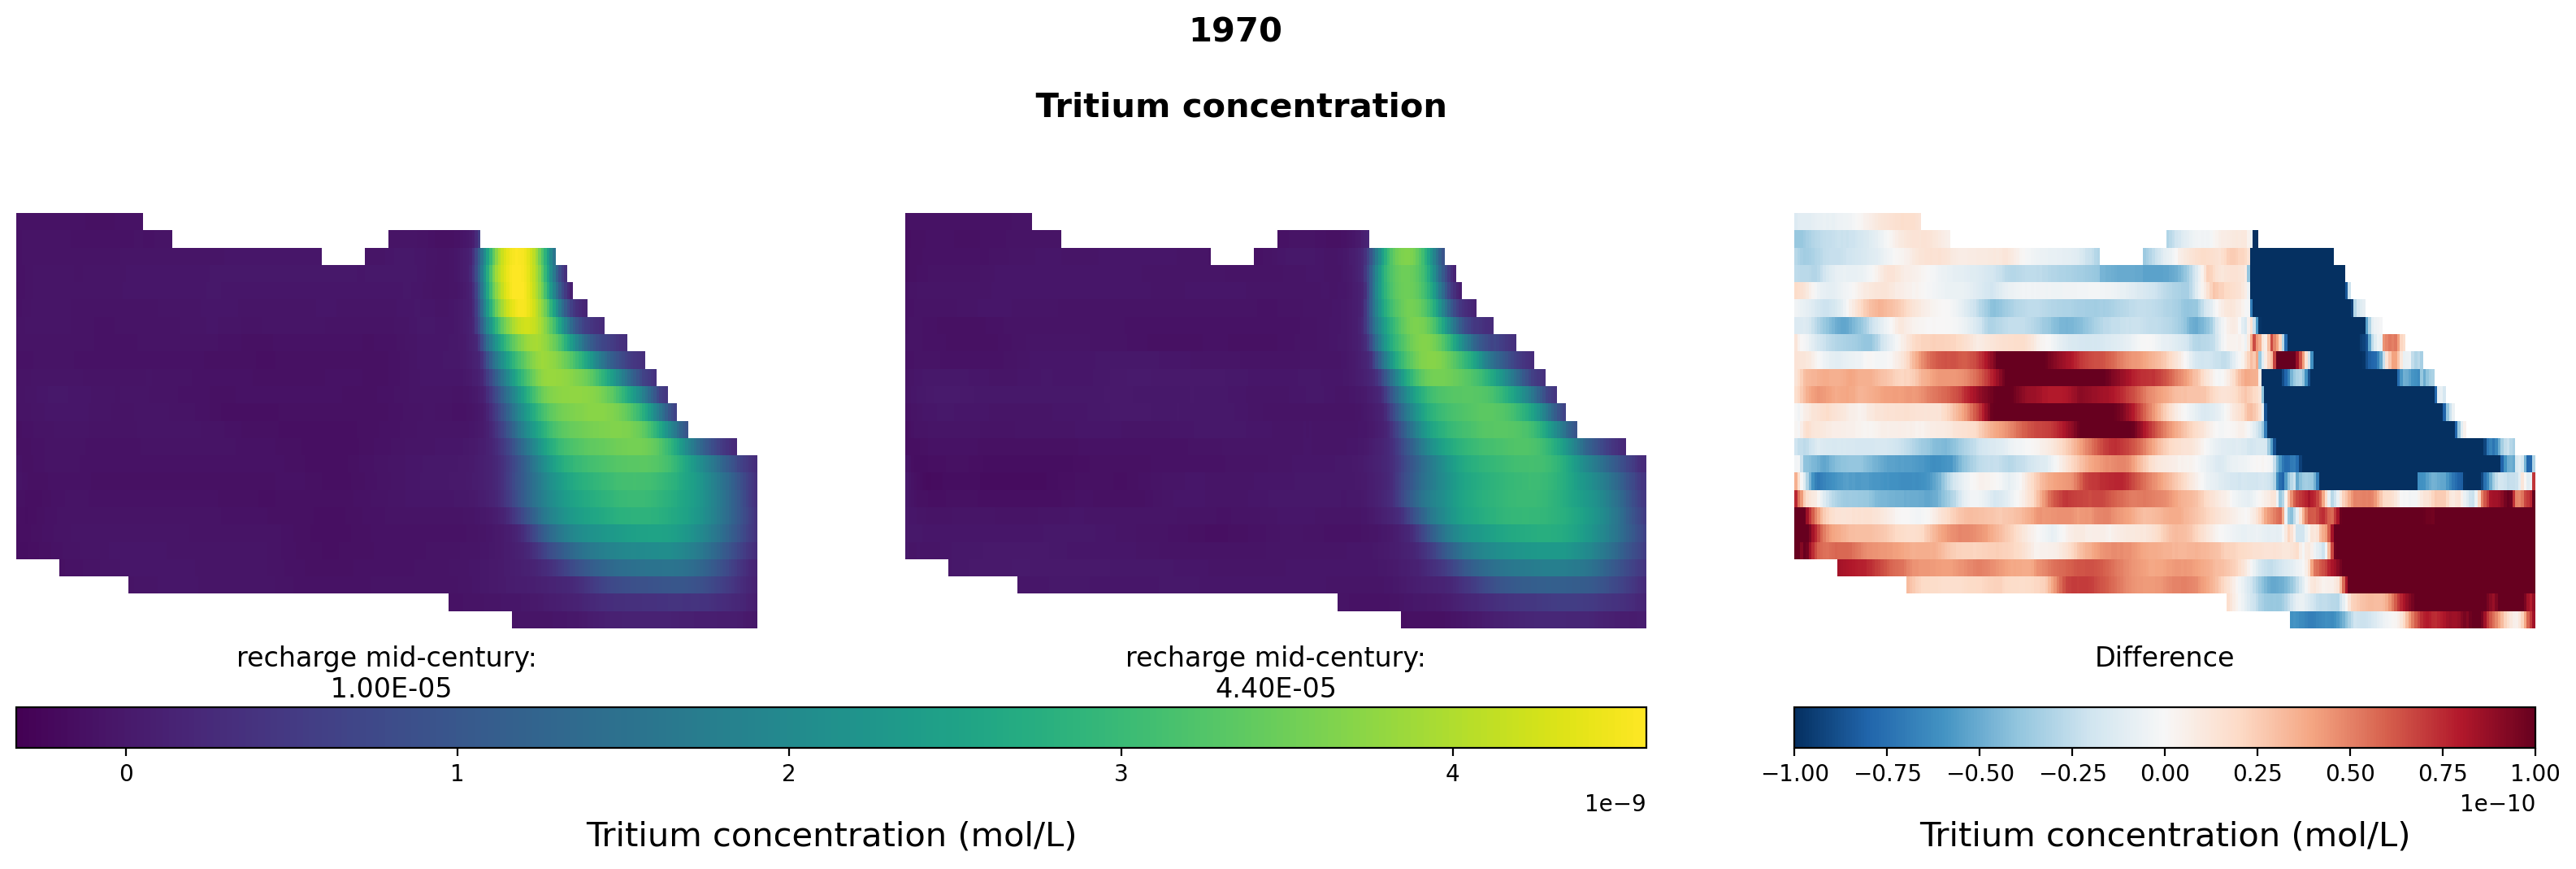

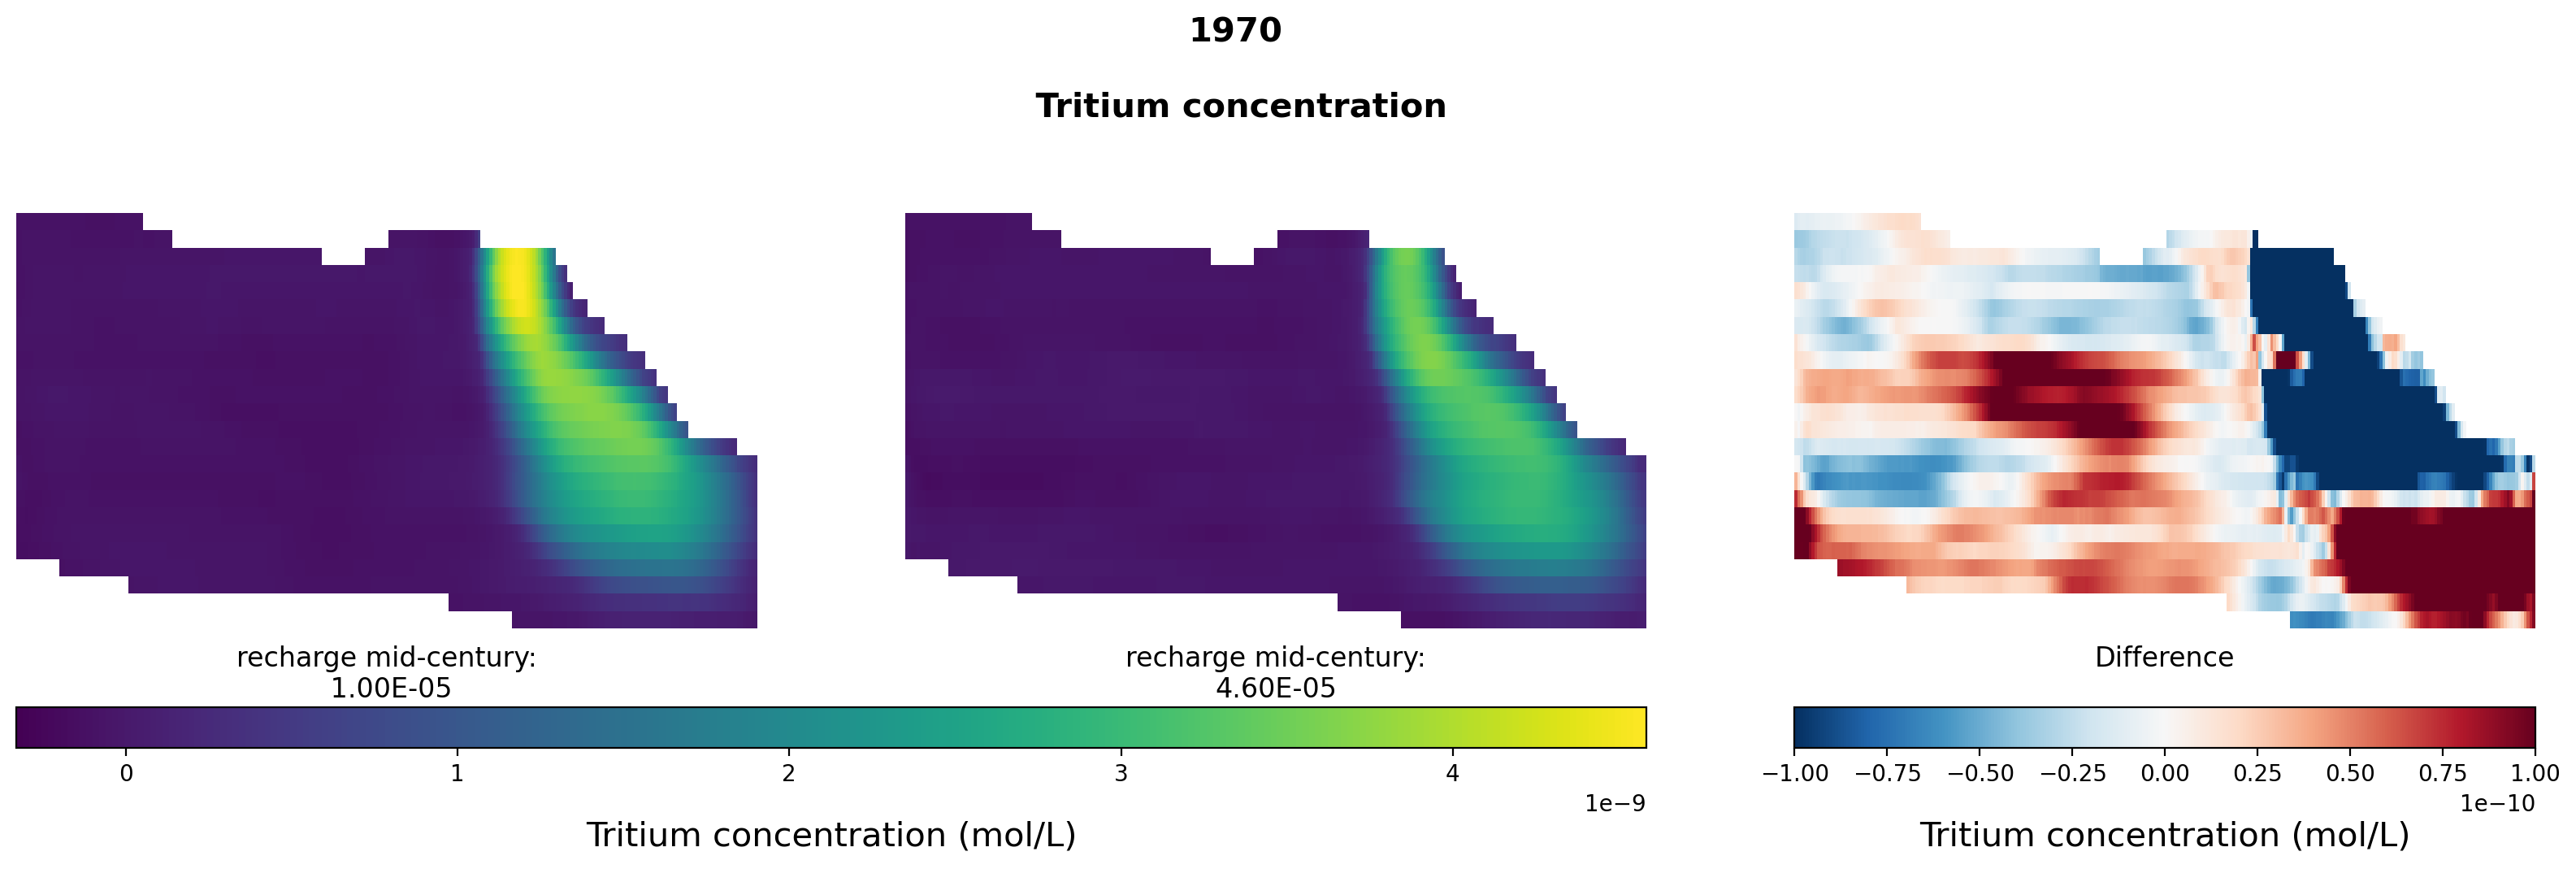

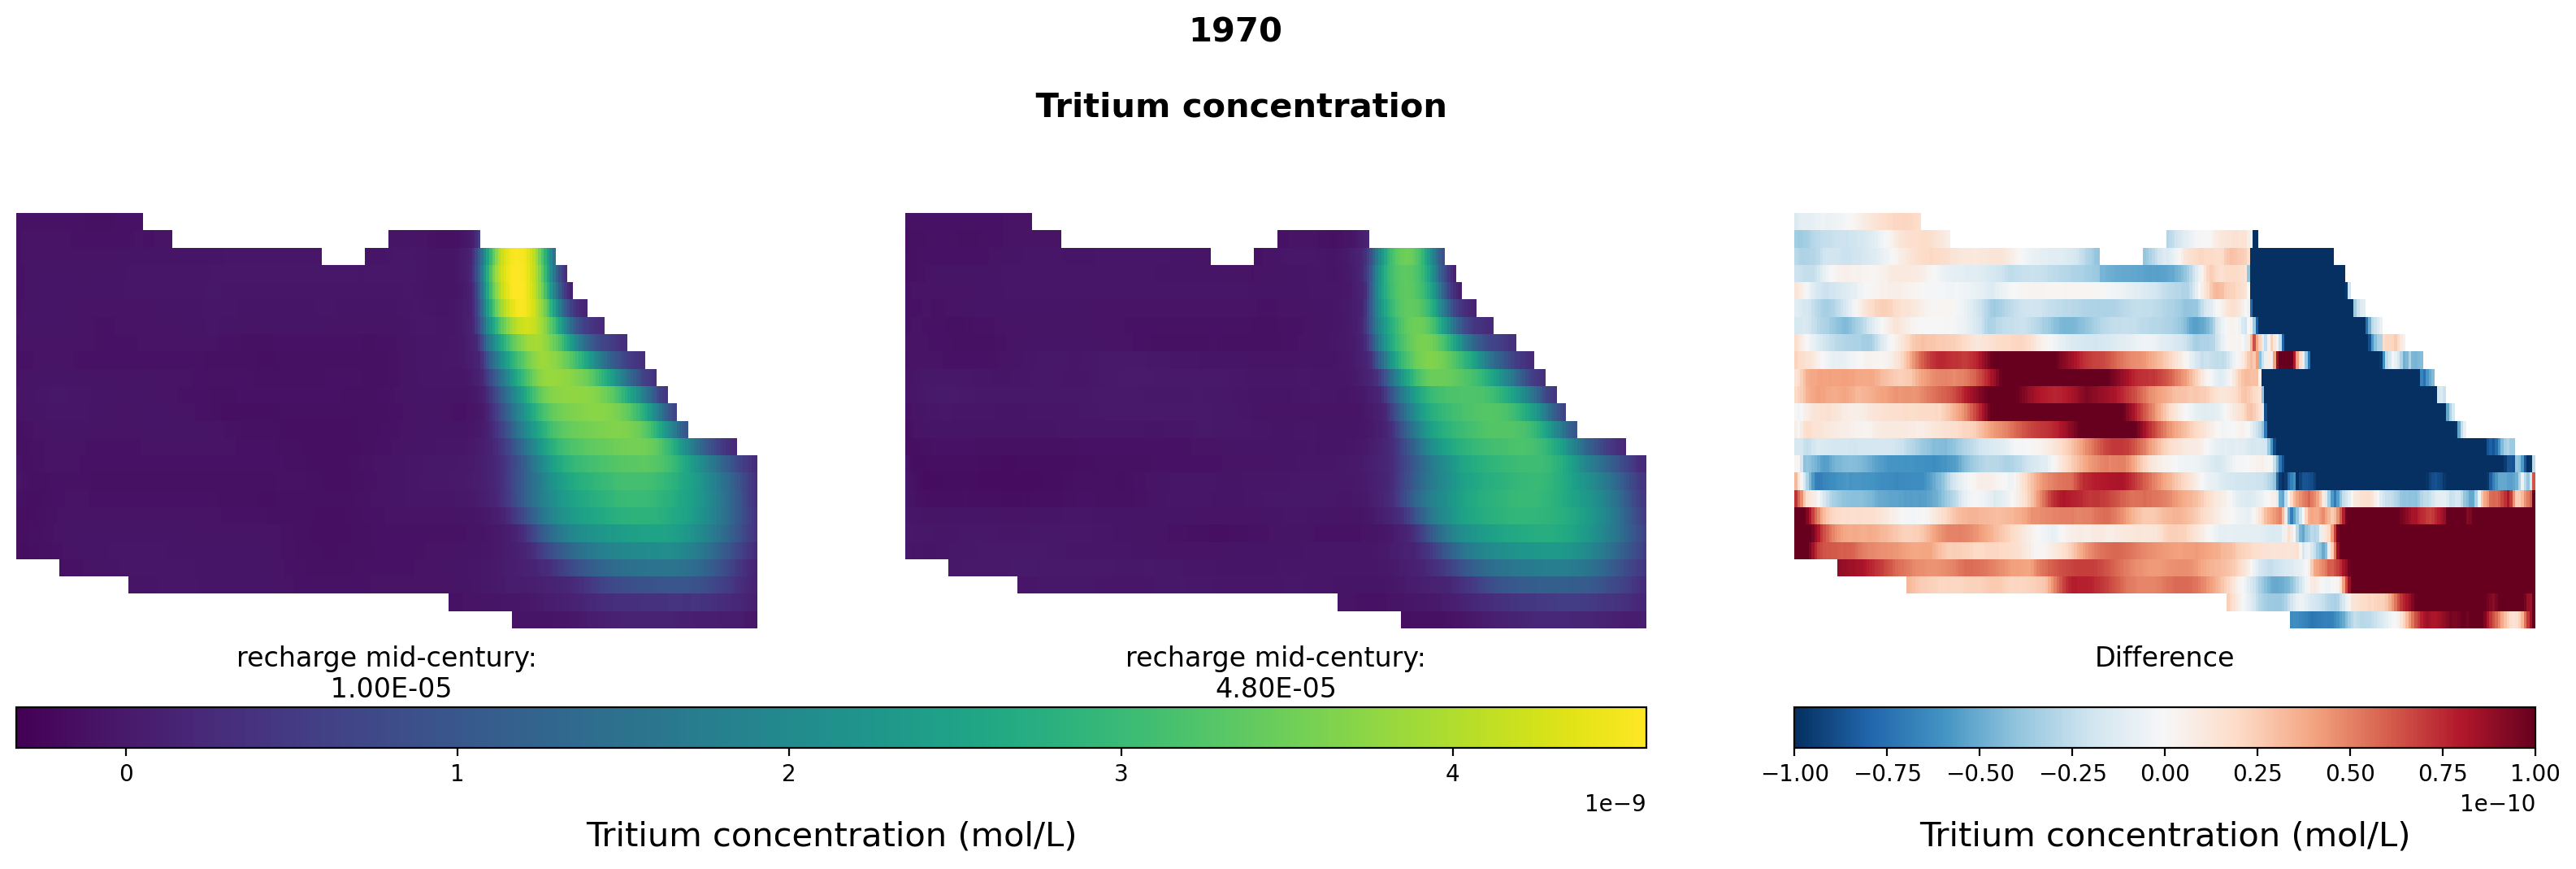

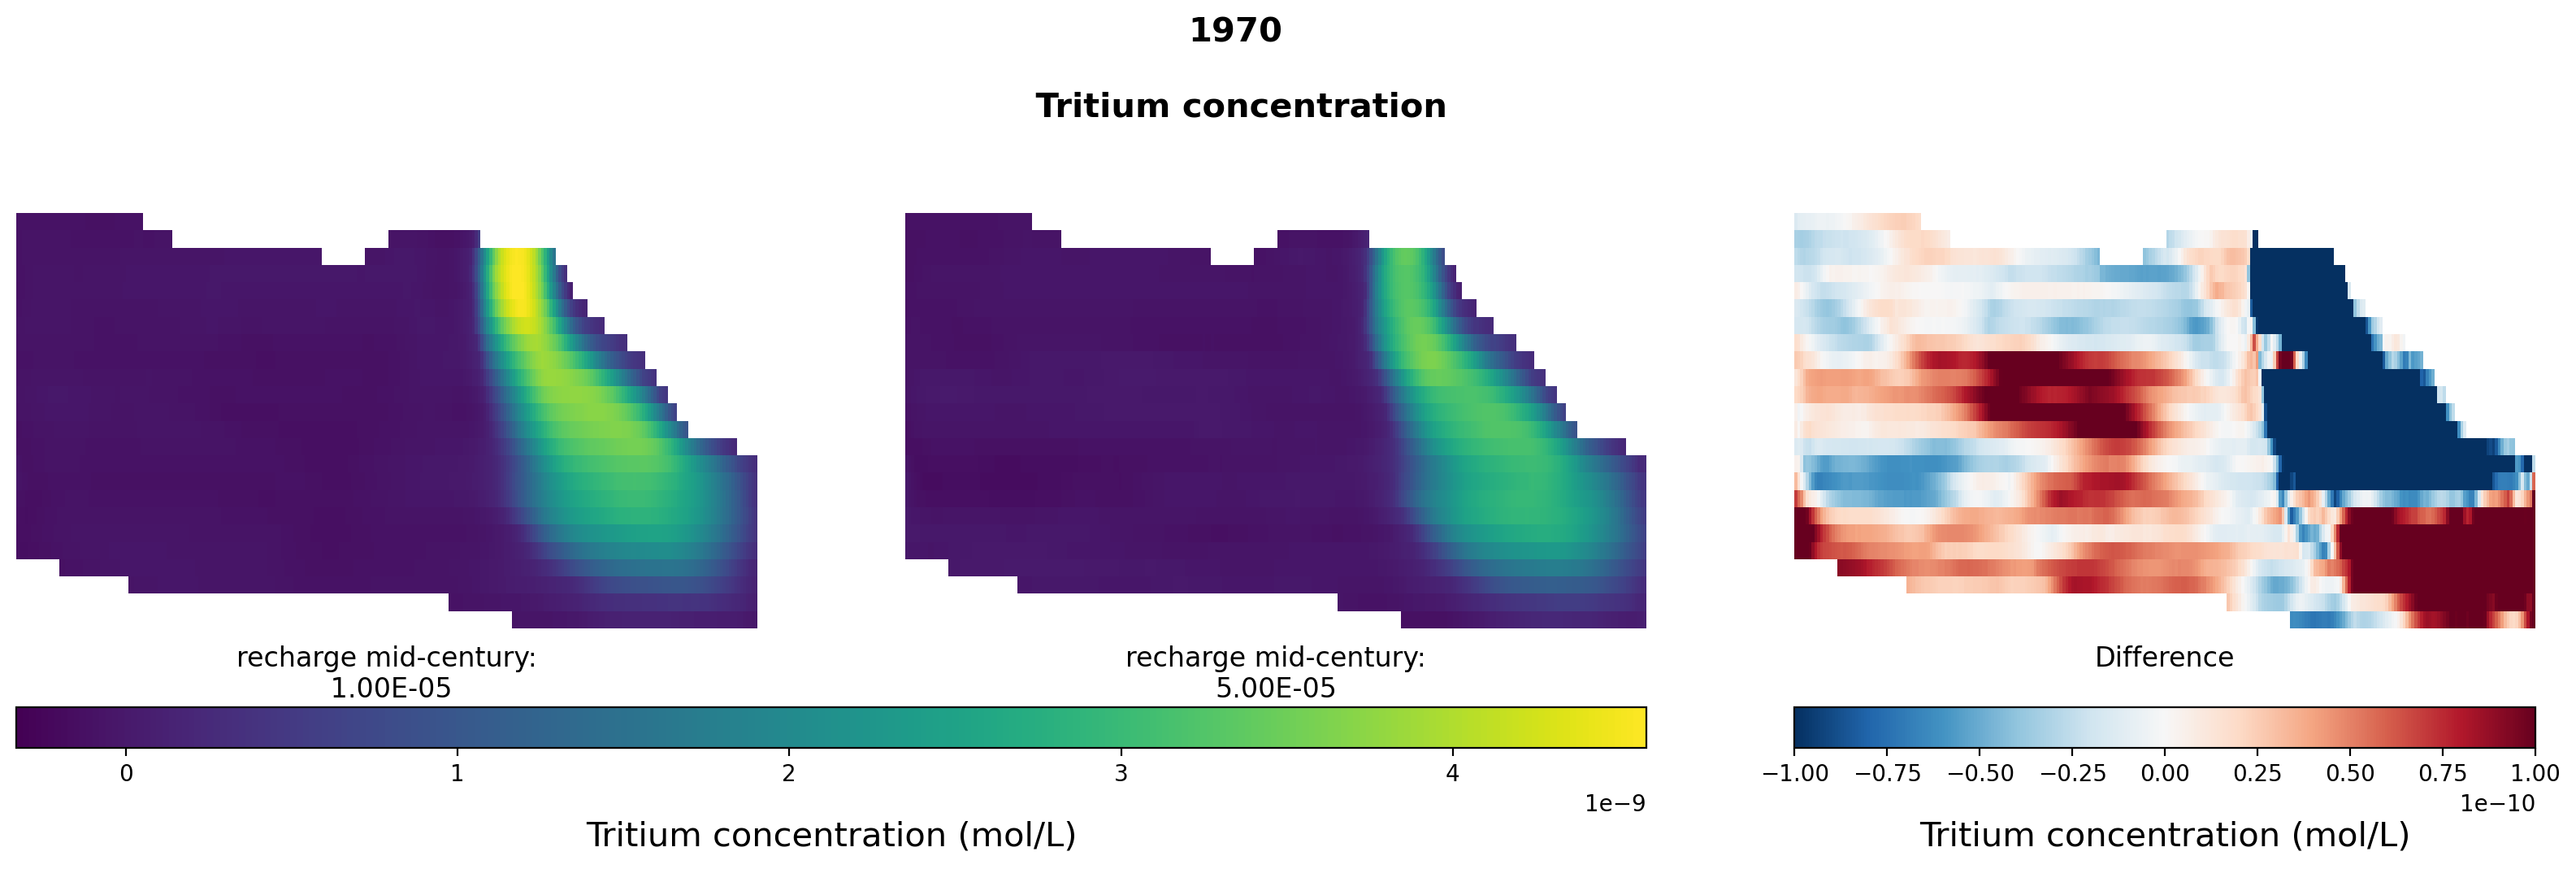

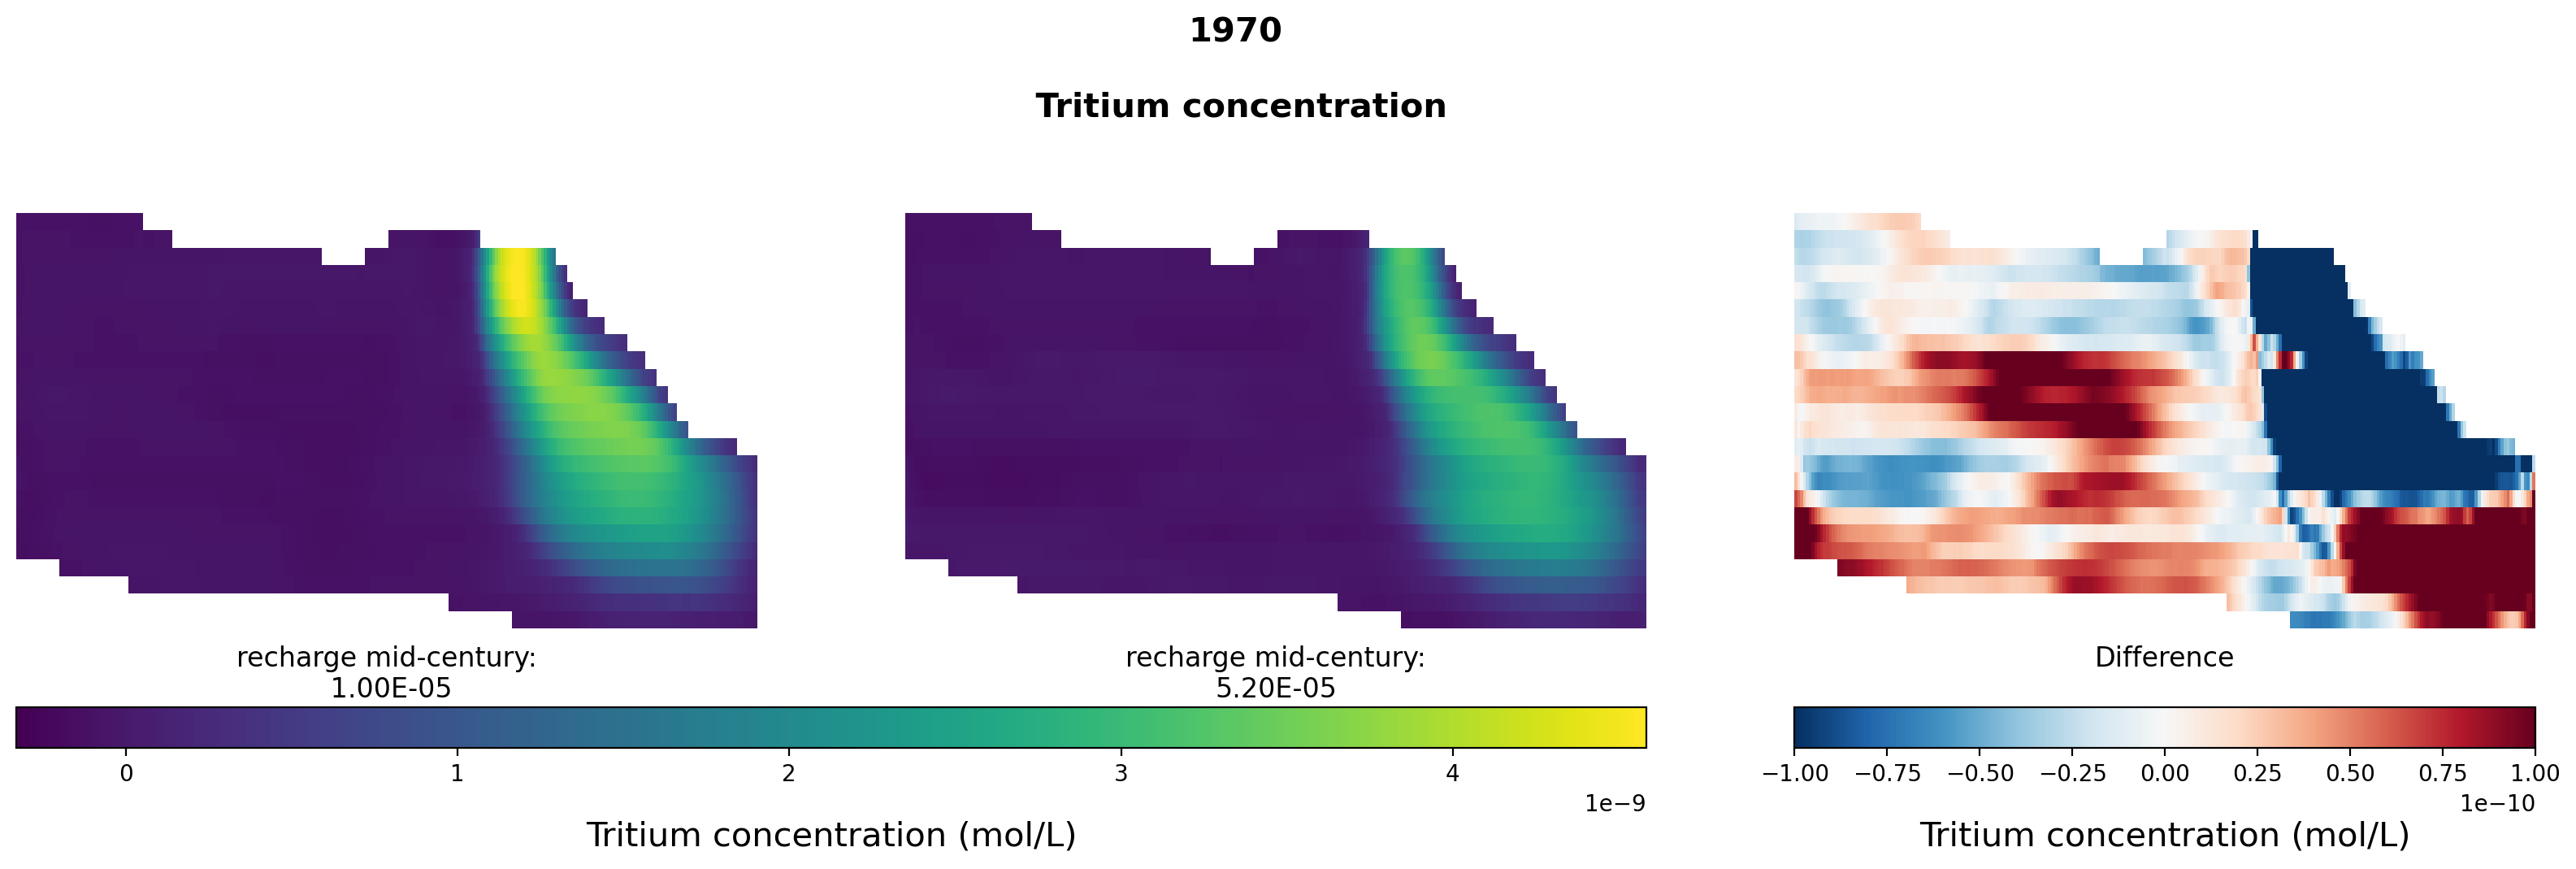

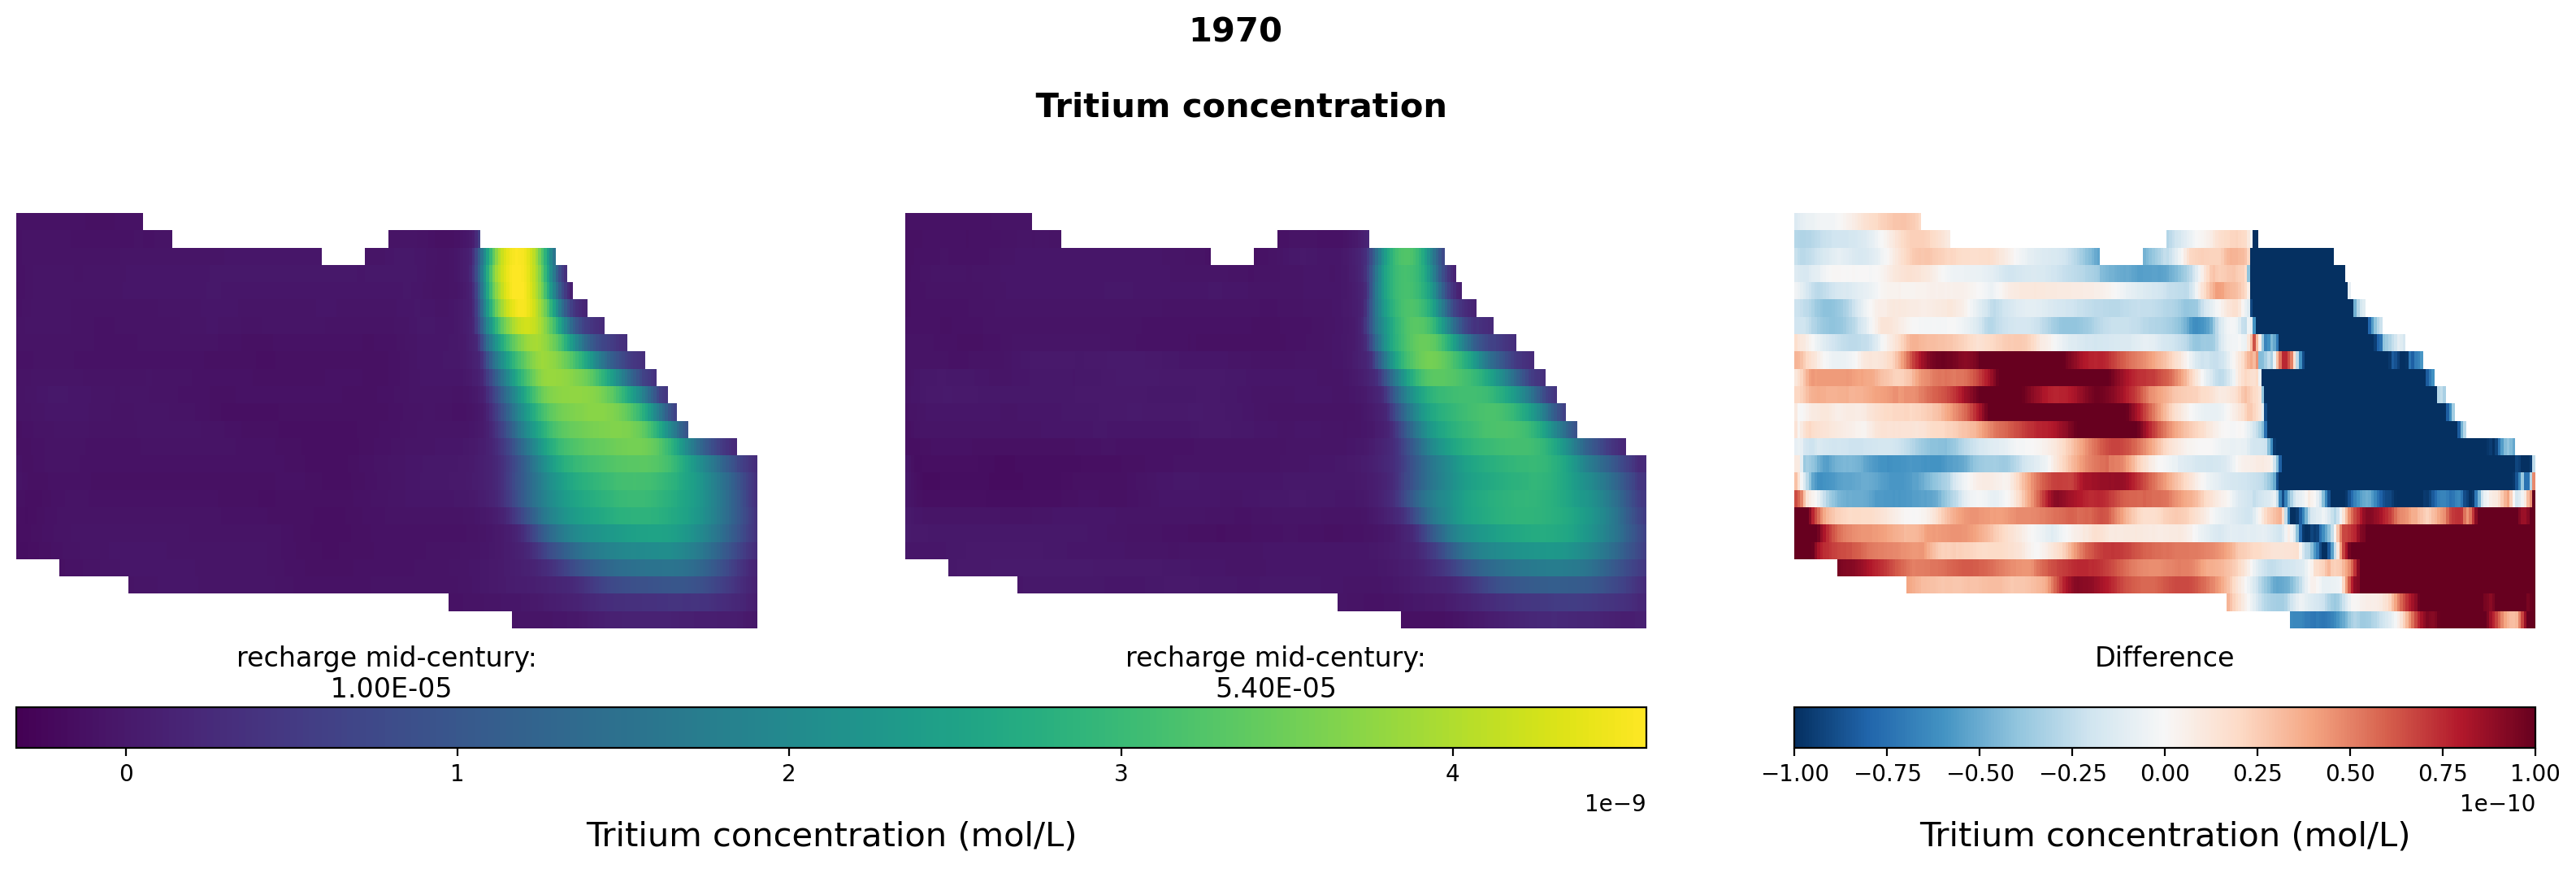

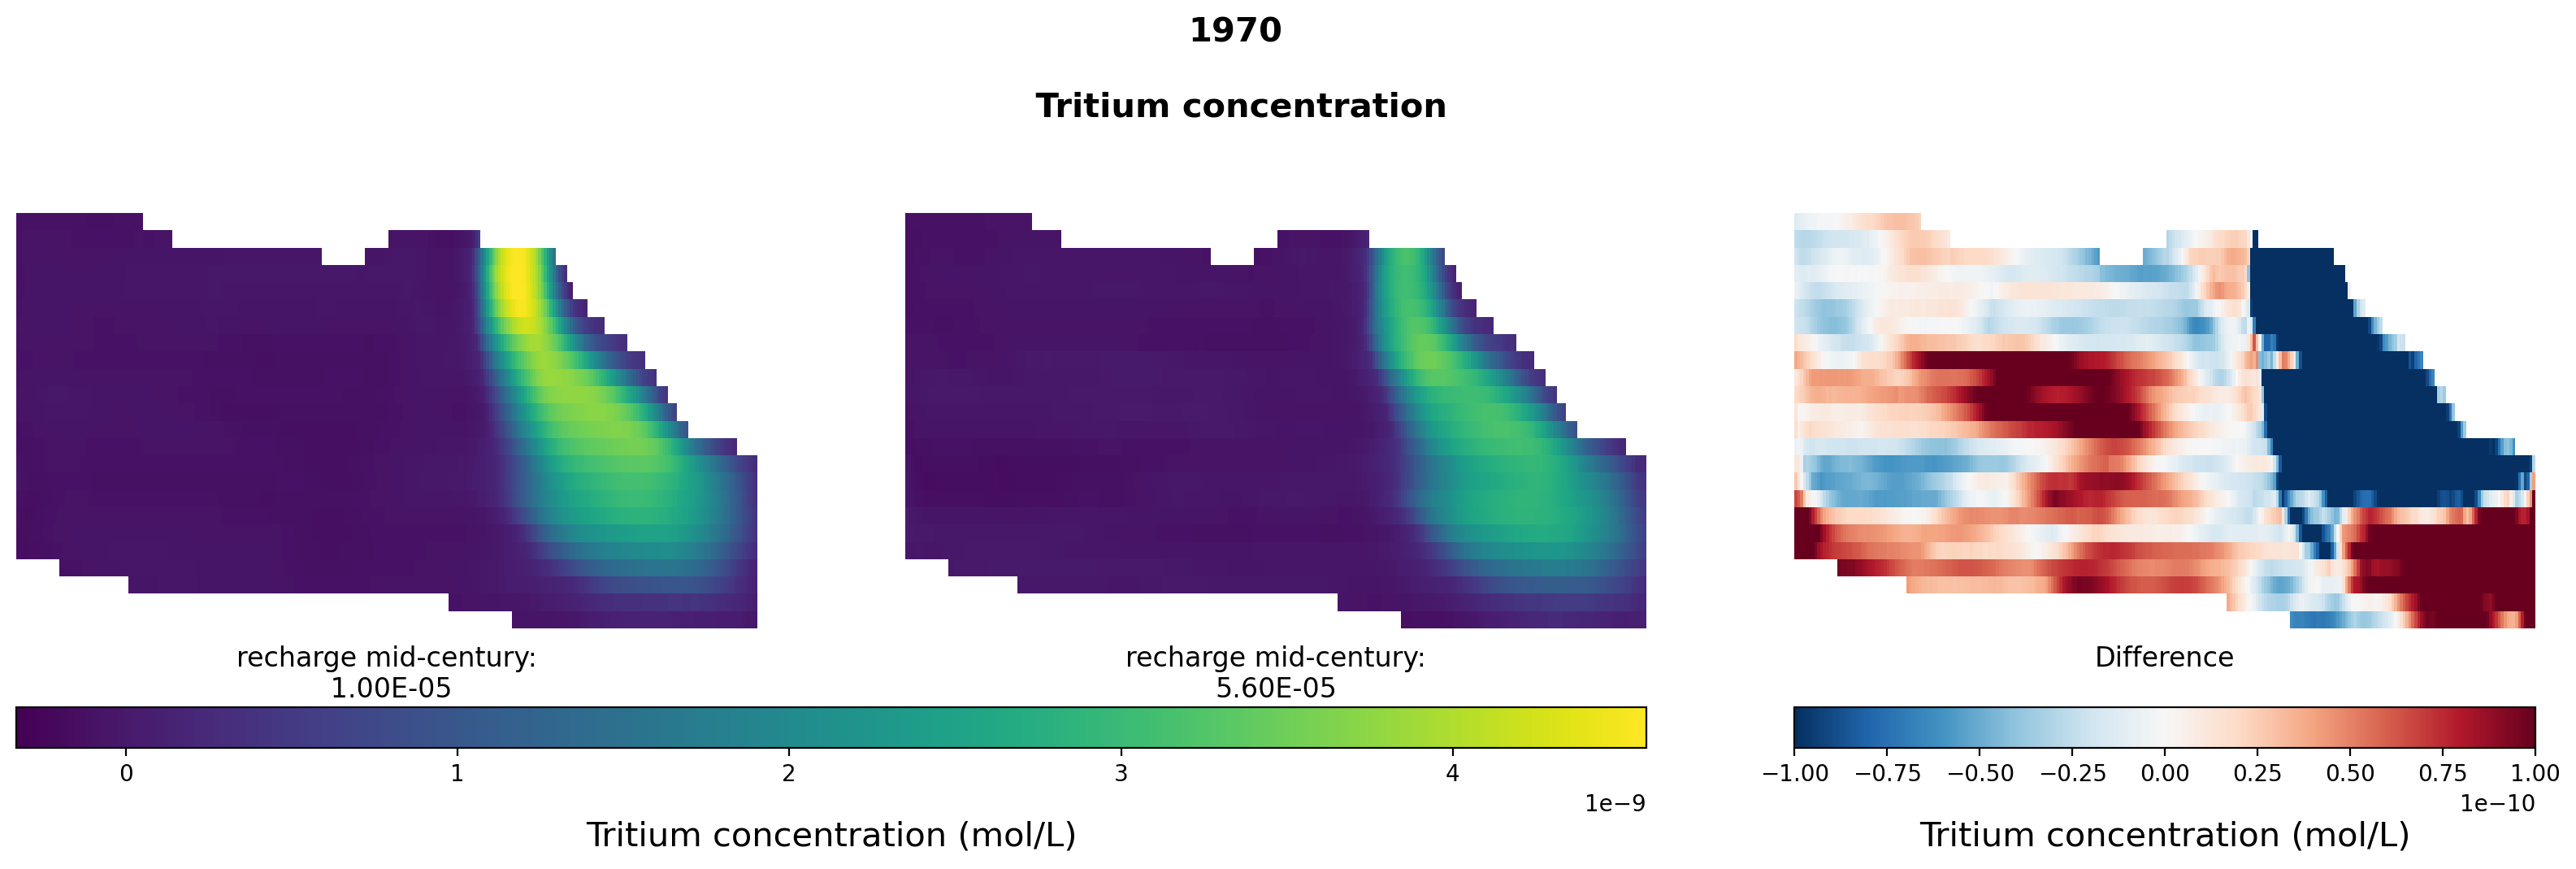

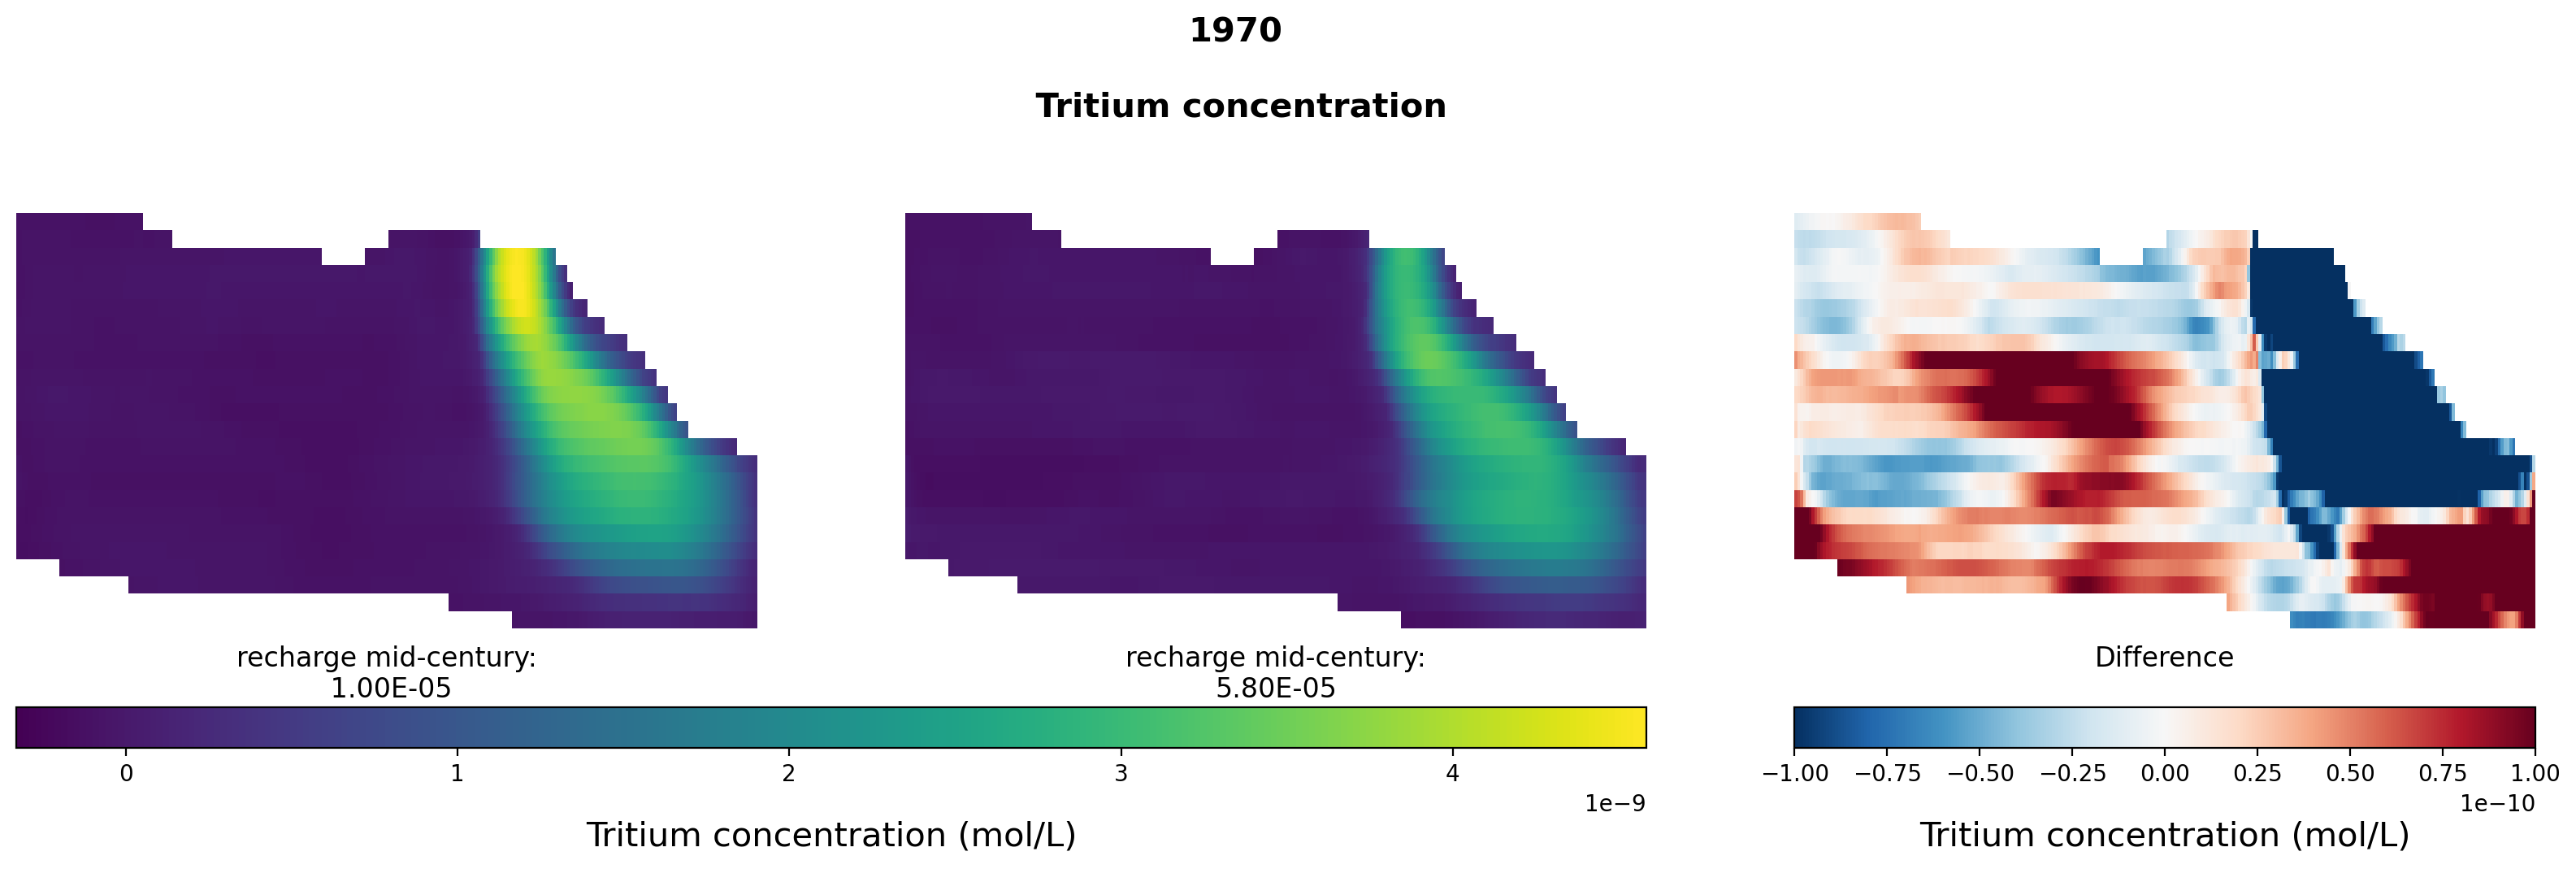

In [69]:
visualization_change_parameters(
    sample_num=30, 
    output_var=3, 
    time=3,
    static_val=1e-5, var_val_max=6e-5, interval=2e-6, 
    parameter_to_change='recharge mid-century', 
    path=path,
    diff_min=-1e-10, diff_max=1e-10,
    fps=8)

In [30]:
changed_values = [2e-6,1e-5,2e-5]
y_changed_values = np.zeros((len(changed_values),nz,nx,nt,4))
ii = 0
for rch in changed_values:
    x = change_input_sample_value(sample_num=0, values = [2e-6,rch,2e-6],name = ['recharge history', 'recharge mid-century','recharge late-century'])
    y = model(x.float().to(device)).cpu().detach().numpy()
    selected_idx = np.array([0,1,2,5])
    for i in range(len(selected_idx)):
        if(i==5):
            i=3
        y[:,:,:,i] = y[:,:,:,i] * (rescale_factors[selected_idx[i]]['max']-rescale_factors[selected_idx[i]]['min']) + rescale_factors[selected_idx[i]]['min']
    y_changed_values[ii,...] = y
    ii = ii+1

(-0.5, 256.5, -0.5, 23.5)

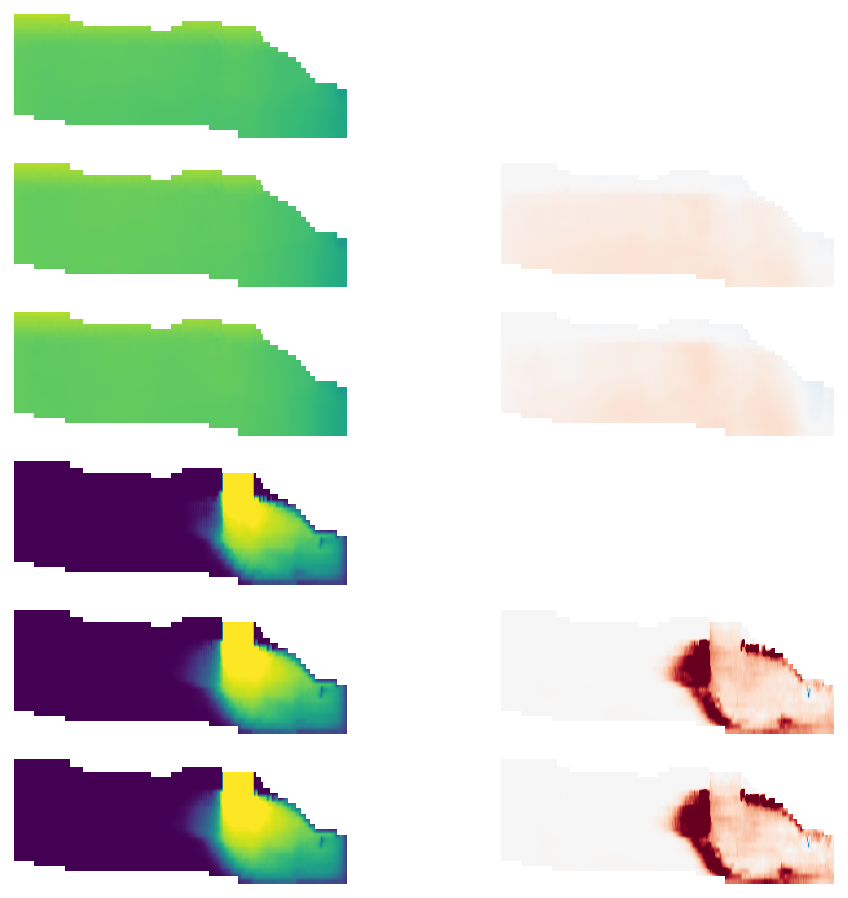

In [32]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.rcParams['font.size'] = 14

plt.figure(figsize = [8,8])#18

i = 1

var_max_list = [2e-6,1e-7,100,8e-9]
diff_list = [2e-6,1e-7,20,1e-9]

idx = 0
time  = 6 # 0,6,14

output_var = 2
#for time in [1,3,5]:
ax = plt.subplot(6, 2, 1)
var_min = 0
var_max = var_max_list[output_var]
plt.imshow((y_changed_values[0, :,:,time, output_var]*vis_mask).reshape(nz,nx), aspect=4, origin ='lower', vmin=var_min, vmax=var_max)
plt.axis('off')
#plt.colorbar(shrink = 0.7)
#plt.title(output_names_4[output_var]+' ('+output_units_4[output_var]+')')

ax = plt.subplot(6, 2, 3)
plt.imshow((y_changed_values[1, :,:,time, output_var]*vis_mask).reshape(nz,nx), aspect=4, origin ='lower', vmin=var_min, vmax=var_max)
plt.axis('off')
#plt.colorbar(shrink = 0.7)

diff_min = -diff_list[output_var]
diff_max = diff_list[output_var]
ax = plt.subplot(6, 2, 4)
plt.imshow((y_changed_values[1, :,:,time, output_var]*vis_mask).reshape(nz,nx)-(y_changed_values[0, :,:,time, output_var]*vis_mask).reshape(nz,nx), aspect=4, origin ='lower',  cmap = 'RdBu_r', vmin=diff_min, vmax=diff_max)
plt.axis('off')


ax = plt.subplot(6, 2, 5)
plt.imshow((y_changed_values[2, :,:,time, output_var]*vis_mask).reshape(nz,nx), aspect=4, origin ='lower', vmin=var_min, vmax=var_max)
plt.axis('off')

#plt.colorbar(shrink = 0.7)
#plt.title(output_names_4[output_var]+output_units_4[output_var])
ax = plt.subplot(6, 2, 6)
plt.imshow((y_changed_values[2, :,:,time, output_var]*vis_mask).reshape(nz,nx)-(y_changed_values[0, :,:,time, output_var]*vis_mask).reshape(nz,nx), aspect=4, origin ='lower',  cmap = 'RdBu_r', vmin=diff_min, vmax=diff_max)
plt.axis('off')

#plt.colorbar(shrink = 0.7)
#plt.title(output_names_4[output_var]+output_units_4[output_var])

output_var = 3
#for time in [1,3,5]:
ax = plt.subplot(6, 2, 7)
var_min = 0
var_max = var_max_list[output_var]
plt.imshow((y_changed_values[0, :,:,time, output_var]*vis_mask).reshape(nz,nx), aspect=4, origin ='lower', vmin=var_min, vmax=var_max)
plt.axis('off')
#plt.colorbar(shrink = 0.7)
#plt.title(output_names_4[output_var]+' ('+output_units_4[output_var]+')')

ax = plt.subplot(6, 2, 9)
plt.imshow((y_changed_values[1, :,:,time, output_var]*vis_mask).reshape(nz,nx), aspect=4, origin ='lower', vmin=var_min, vmax=var_max)
plt.axis('off')
#plt.colorbar(shrink = 0.7)

diff_min = -diff_list[output_var]
diff_max = diff_list[output_var]
ax = plt.subplot(6, 2, 10)
plt.imshow((y_changed_values[1, :,:,time, output_var]*vis_mask).reshape(nz,nx)-(y_changed_values[0, :,:,time, output_var]*vis_mask).reshape(nz,nx), aspect=4, origin ='lower',  cmap = 'RdBu_r', vmin=diff_min, vmax=diff_max)
plt.axis('off')


ax = plt.subplot(6, 2, 11)
plt.imshow((y_changed_values[2, :,:,time, output_var]*vis_mask).reshape(nz,nx), aspect=4, origin ='lower', vmin=var_min, vmax=var_max)
plt.axis('off')

#plt.colorbar(shrink = 0.7)
#plt.title(output_names_4[output_var]+output_units_4[output_var])
ax = plt.subplot(6, 2, 12)
plt.imshow((y_changed_values[2, :,:,time, output_var]*vis_mask).reshape(nz,nx)-(y_changed_values[0, :,:,time, output_var]*vis_mask).reshape(nz,nx), aspect=4, origin ='lower',  cmap = 'RdBu_r', vmin=diff_min, vmax=diff_max)
plt.axis('off')



In [ ]:
# # Replace values in input data
# sample_num = 30

# x = change_input_sample_value(sample_num=sample_num, values = [1e-5,1e-5,1e-5],name = ['recharge history','recharge mid-century','recharge late-century'])
# y1 =  model(x.float().to(device)).cpu().detach().numpy()
# x = change_input_sample_value(sample_num=sample_num, values = [1e-5,2e-5,1e-5],name = ['recharge history','recharge mid-century','recharge late-century'])
# y2 =  model(x.float().to(device)).cpu().detach().numpy()

In [ ]:
# # REVERSE RESCALE
# selected_idx = np.array([0,1,2,5])
# for i in range(len(selected_idx)):
#     if(i==5):
#         i=3
#     y1[:,:,:,i] = y1[:,:,:,i] * (rescale_factors[selected_idx[i]]['max']-rescale_factors[selected_idx[i]]['min']) + rescale_factors[selected_idx[i]]['min']
#     y2[:,:,:,i] = y2[:,:,:,i] * (rescale_factors[selected_idx[i]]['max']-rescale_factors[selected_idx[i]]['min']) + rescale_factors[selected_idx[i]]['min']

# diff = y2-y1